## คู่มือการใช้งาน

### อินพุตและเอาต์พุต
1. Input: ส่วนที่จำเป็นมีสองไฟล์และมี Option อีกหนึ่งไฟล์ ประกอบด้วย
   1. Structure.xlsx เก็บโครงสร้างของคลองส่งน้ำ
   2. Scada Section Detailed Information.xlsx เก็บความต้องการน้ำ ความเร็วน้ำที่ผ่านประตูน้ำ และอื่น ๆ (สามารถใช้ไฟล์ชื่ออื่น ๆ ได้ โดยอัปโหลดด้วยแท็บด้านซ้ายมือ จากนั้นให้แก้ชื่อไฟล์ใน cell `Initialization` บรรทัดที่ 35)
   3. Excel File เก็บสถานะปัจจุบันของประตูน้ำ มีรูปแบบเดียวกันกับไฟล์ Output
2. Output: มีสองรูปแบบ คือ jobs.xlsx และเก็บลง Database

### ขั้นตอนการทำงาน
1. Section Data Preparation ทำหน้าที่ download file อินพุตที่จำเป็น ซึ่งตรงนี้สามารถ upload ขึ้นจากเครื่องคอมพิวเตอร์ใด ๆ ได้ โดยใช้แท็บด้านซ้ายมือ
2. Section Display Structure ใช้แสดงโครงสร้าง (ไม่จำเป็นต้อง run ก็ได้)
3. Section Calculation ส่วนนี้จำเป็นต้องรัน เพื่อคำนวณลำดับการเปิดปิดประตูน้ำ
4. Section Export to jobs.xlsx เป็นไฟล์ผลลัพธ์ แสดงลำดับการเปิดปิดประตูน้ำ
5. Section Export to SQL Server เป็นแบบฟอร์มที่ต้องกรอกรายละเอียดของ Server ซึ่งเมื่อทำงานเสร็จ จะได้ table ชื่อ tb_tasks ในรูปแบบเดียวกับ jobs.xlsx



## Data Preparation

In [ ]:
! wget https://github.com/ssukree/water_gate/raw/main/Structure.xlsx
! wget https://github.com/ssukree/water_gate/raw/main/SCADA%20Section%20Detailed%20Information%202024-01-15%20V0.9%20SL.xlsx

--2024-07-15 03:22:41--  https://github.com/ssukree/water_gate/raw/main/Structure.xlsx
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ssukree/water_gate/main/Structure.xlsx [following]
--2024-07-15 03:22:42--  https://raw.githubusercontent.com/ssukree/water_gate/main/Structure.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11633 (11K) [application/octet-stream]
Saving to: ‘Structure.xlsx’

Structure.xlsx      100%[===================>]  11.36K  --.-KB/s    in 0s      

2024-07-15 03:22:42 (59.4 MB/s) - ‘Structure.xlsx’ saved [11633/11633]

--2024-07-15 03:22:42--  https://github.com/ssukr

In [ ]:
import pandas as pd

structure_df=pd.read_excel('Structure.xlsx')
structure_df

Outlet                    Source                   Target
0             LMC                    M(0,0)                   M(0,1)
1             LMC                    M(0,1)                   M(0,2)
2             LMC                    M(0,2)            JM (0,2; 1,0)
3             RMC             JM (0,2; 1,0)             M (0,2; 1,0)
4             LMC             JM (0,2; 1,0)                   M(0,3)
..            ...                       ...                      ...
65     4L-38R-LMC  JM (0,13; 1,2; 1,0; 1,0)       M (0,13; 1,2; 1,1)
66     4L-38R-LMC        M (0,13; 1,2; 1,1)       M (0,13; 1,2; 1,2)
67  5R-4L-38R-LMC   M (0,13; 1,2; 1,0; 1,0)  M (0,13; 1,2; 1,0; 1,1)
68     6R-38R-LMC        M (0,13; 1,3; 1,0)       M (0,13; 1,3; 1,1)
69     8R-38R-LMC        M (0,13; 1,4; 1,0)       M (0,13; 1,4; 1,1)

[70 rows x 3 columns]

In [ ]:
import networkx as nx

edges = list(zip(structure_df['Source'], structure_df['Target']))

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)
G.add_edge('S','M(0,0)')

## Display Structure

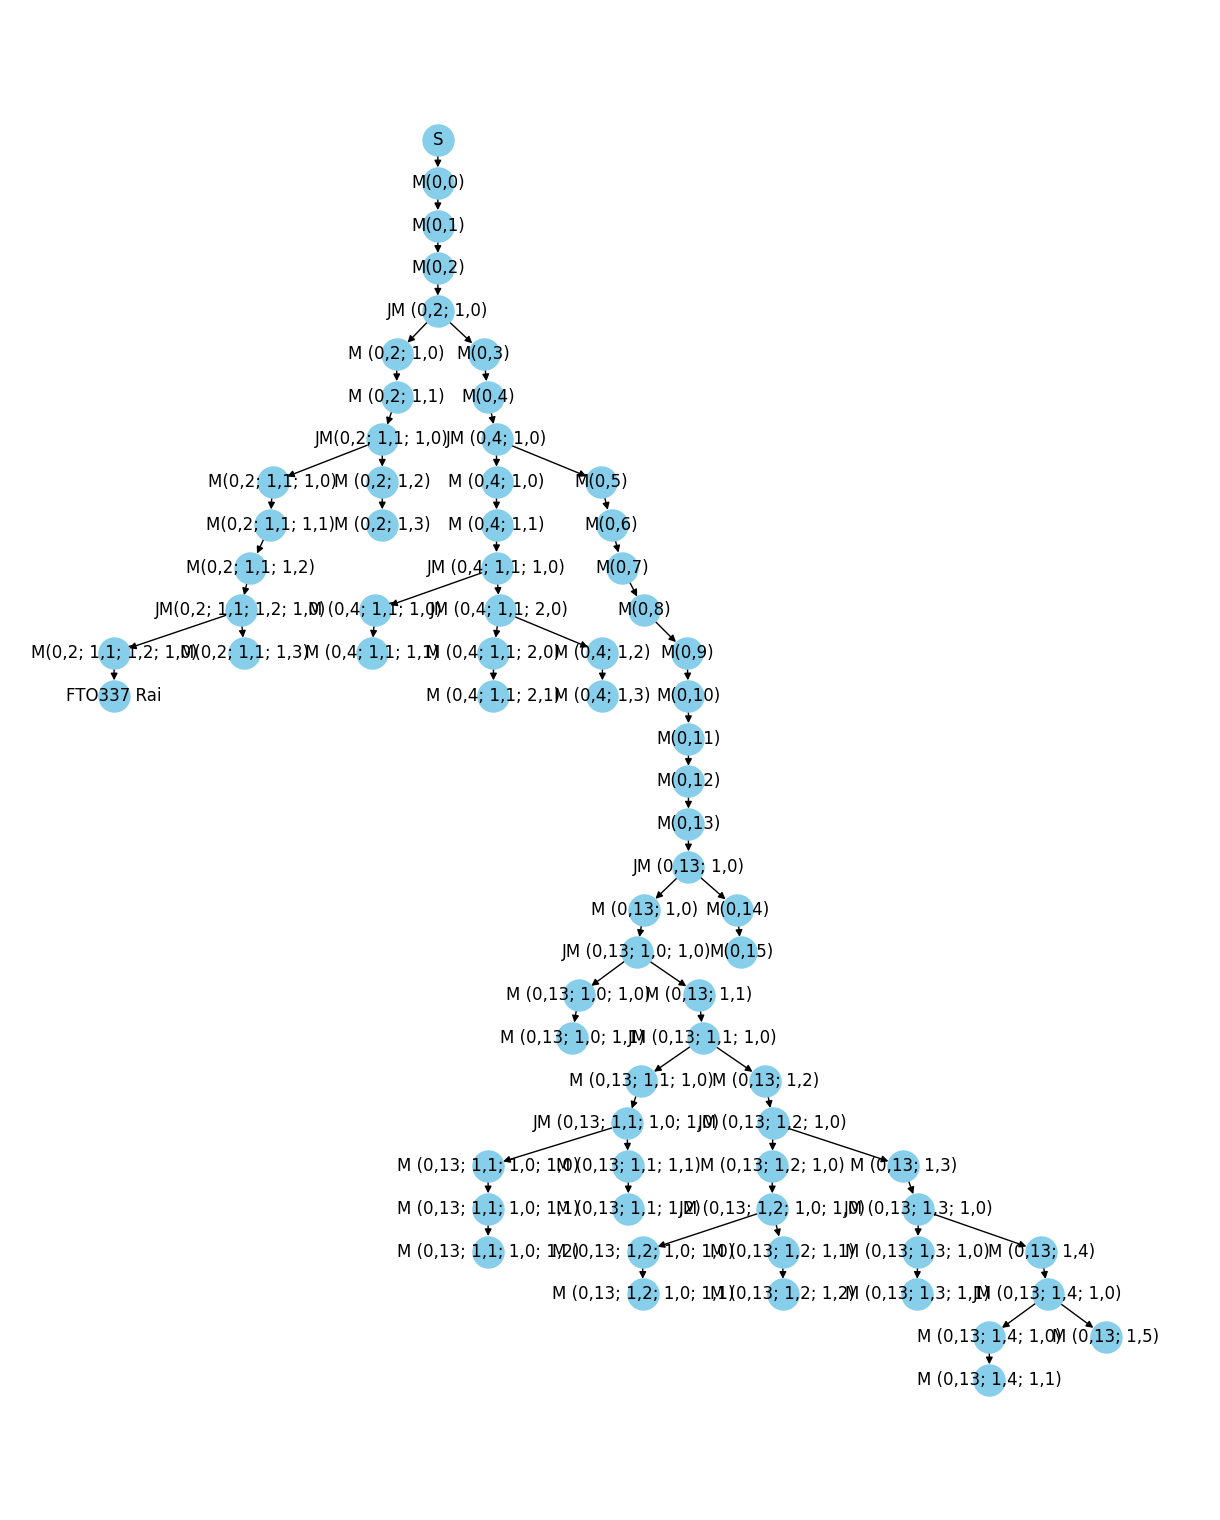

In [ ]:
import matplotlib.pyplot as plt
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')  # Use Graphviz for layout
plt.figure(figsize=(12, 15))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', arrowsize=10)

# Show the plot
plt.show()

## Calculation

### Initialization

In [ ]:
import pandas as pd

def initialize(requirement_filename):
  req_df=pd.read_excel(requirement_filename,skiprows=1)
  req_df=req_df[['Gate Valve','q_max (m^3/s)','Required Daily Water (cm)','Required Daily Volume (m3)']].dropna(subset=['Gate Valve'])
  gate_info=req_df.fillna(0).set_index('Gate Valve').to_dict(orient='index')
  all_open_gates=set()
  for g in req_df[req_df['Required Daily Volume (m3)'] > 0]['Gate Valve']:
    all_open_gates=all_open_gates.union(set(nx.shortest_path(G,'S',g)))
  adjustable_gates=[g for g in all_open_gates if g[0] != 'J']
  current_G=G.subgraph(all_open_gates)
  for node in G.nodes:
    for n in G.neighbors(node):
      if n in gate_info:
        gate_info[n]['parent'] = node
      else:
        gate_info[n]=dict()
        gate_info[n]['parent'] = node
  for n in adjustable_gates:
    if n in gate_info and gate_info[n]['q_max (m^3/s)'] > 0:
      current_G[gate_info[n]['parent']][n]['capacity'] = gate_info[n]['q_max (m^3/s)']
  working_G = nx.DiGraph()
  working_G.add_nodes_from(current_G.nodes(data=True))  # Include node attributes
  working_G.add_edges_from(current_G.edges(data=True))
  for g in gate_info:
    if 'Required Daily Volume (m3)' in gate_info[g]:
      if gate_info[g]['Required Daily Volume (m3)'] > 0:
        working_G.add_edge(g,'T')
  return working_G,gate_info

edges = list(zip(structure_df['Source'], structure_df['Target']))
G = nx.DiGraph()
G.add_edges_from(edges)
G.add_edge('S','M(0,0)')
working_G,gate_info=initialize('SCADA Section Detailed Information 2024-01-15 V0.9 SL.xlsx')

#### Actual Calculation


Step 1
258 mins
Fill Area:  M (0,2; 1,0) 21285.0
Fill Area:  M(0,4) 132369.0


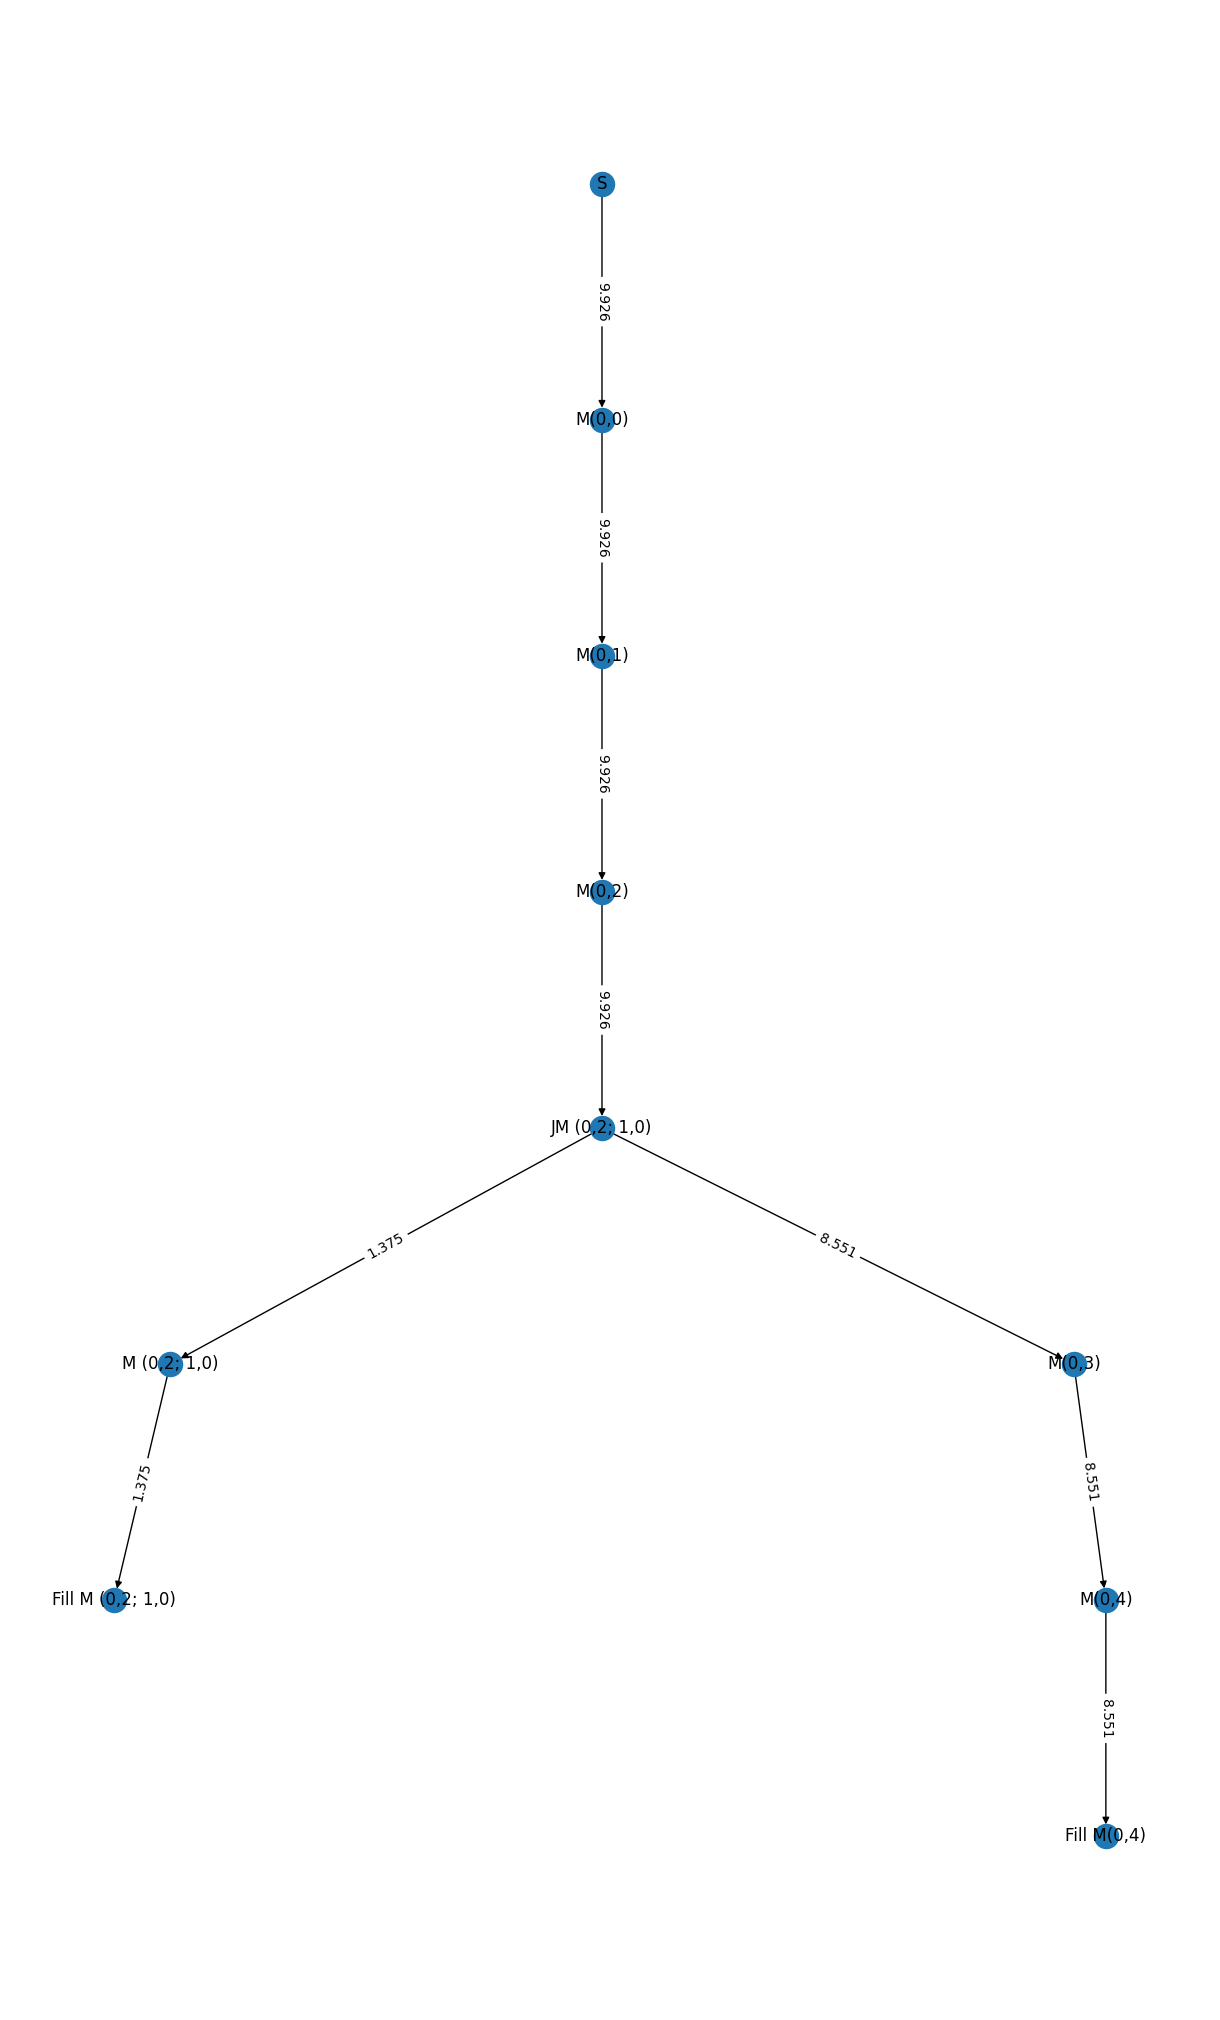


Step 2
374 mins
Fill Area:  M (0,2; 1,0) 30855.0
Fill Area:  M(0,5) 133810.0
Fill Area:  M (0,4; 1,1) 43242.0


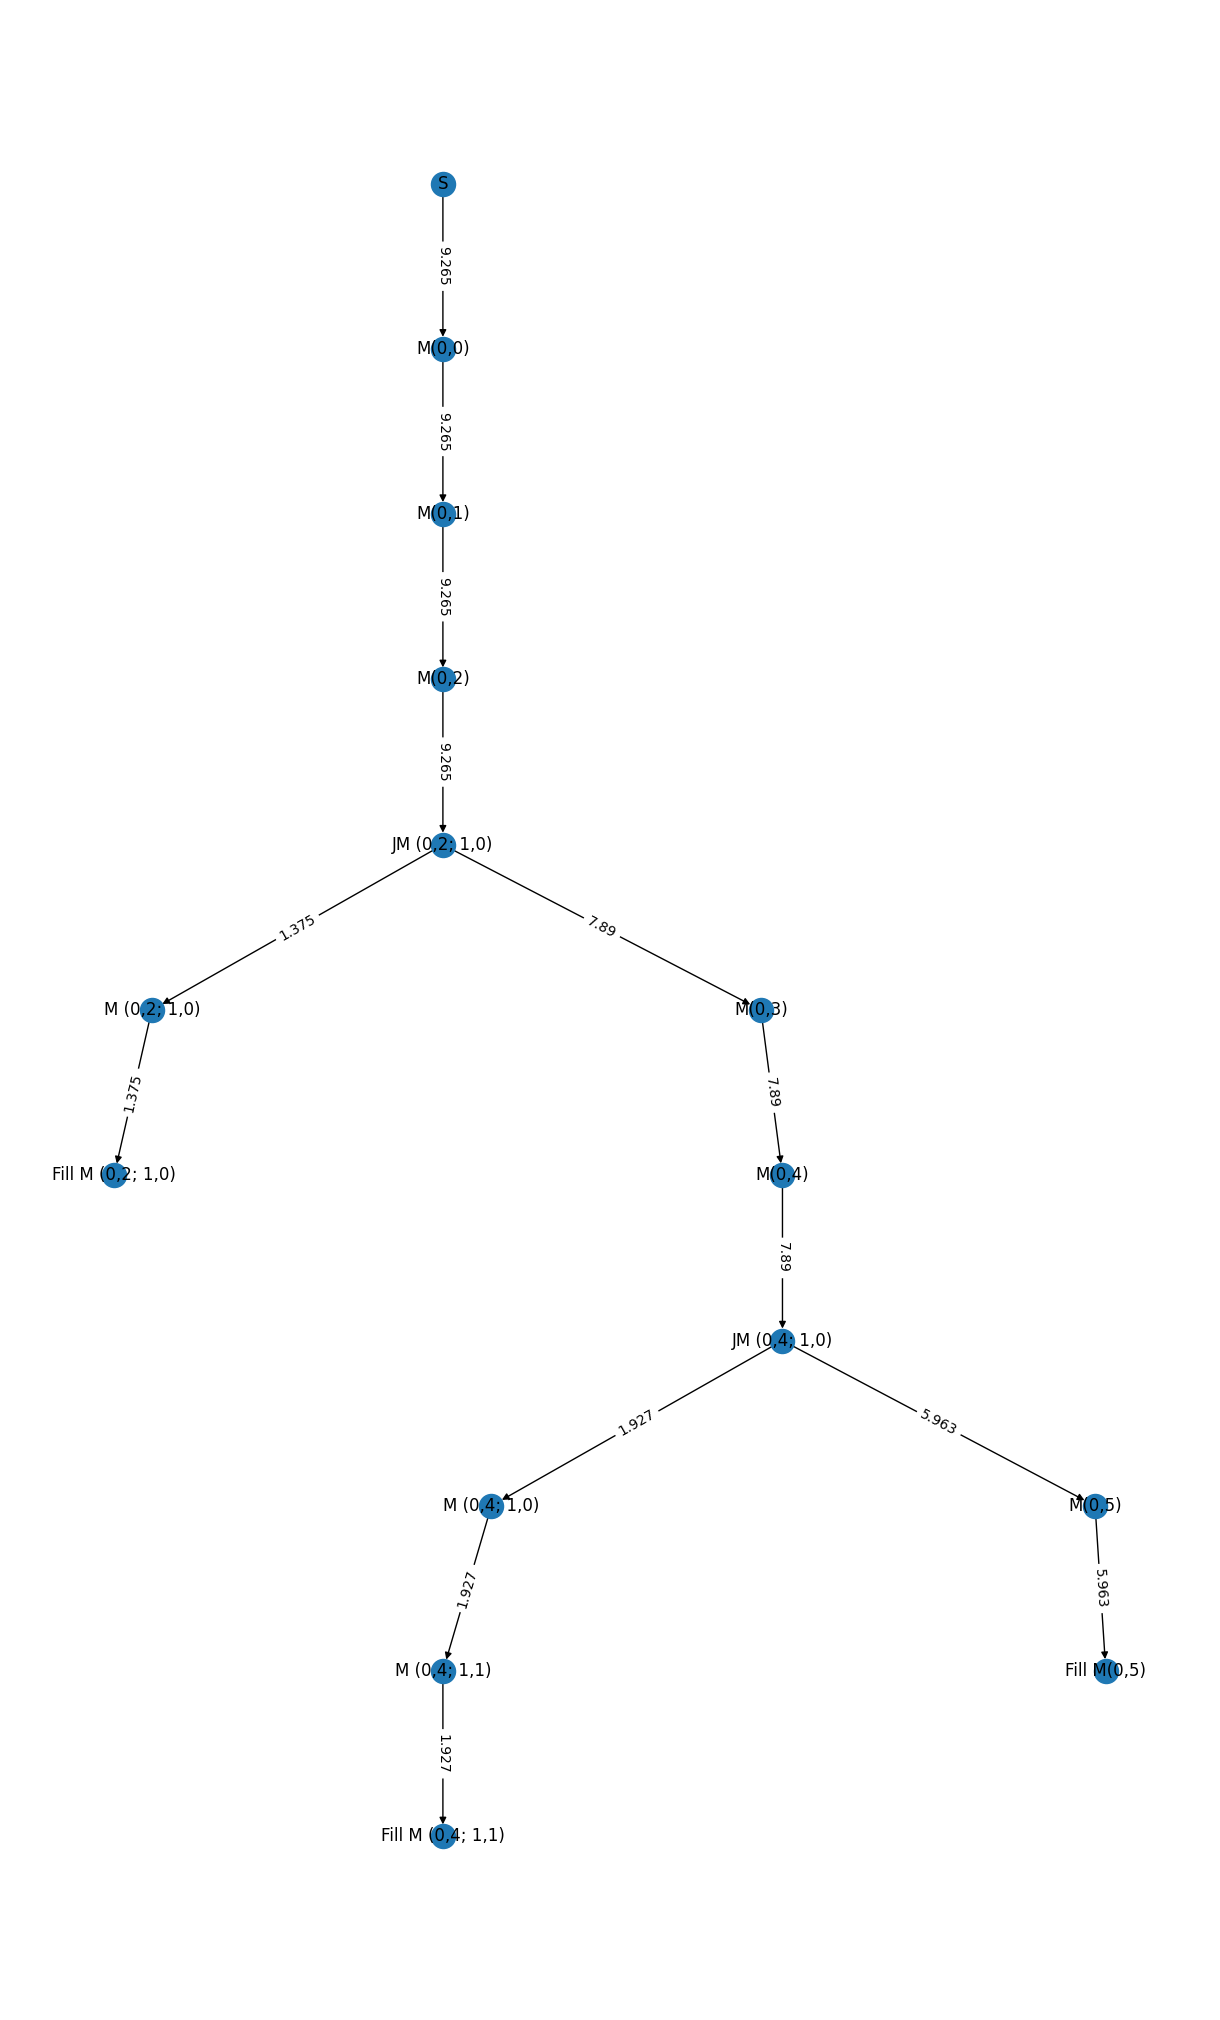


Step 3
100 mins
Fill Area:  M (0,2; 1,0) 8250.0
Fill Area:  M(0,5) 35778.0
Fill Area:  M (0,4; 1,1; 1,0) 2193.0
Fill Area:  M (0,4; 1,1; 2,0) 1617.0
Fill Area:  M (0,4; 1,2) 3728.0


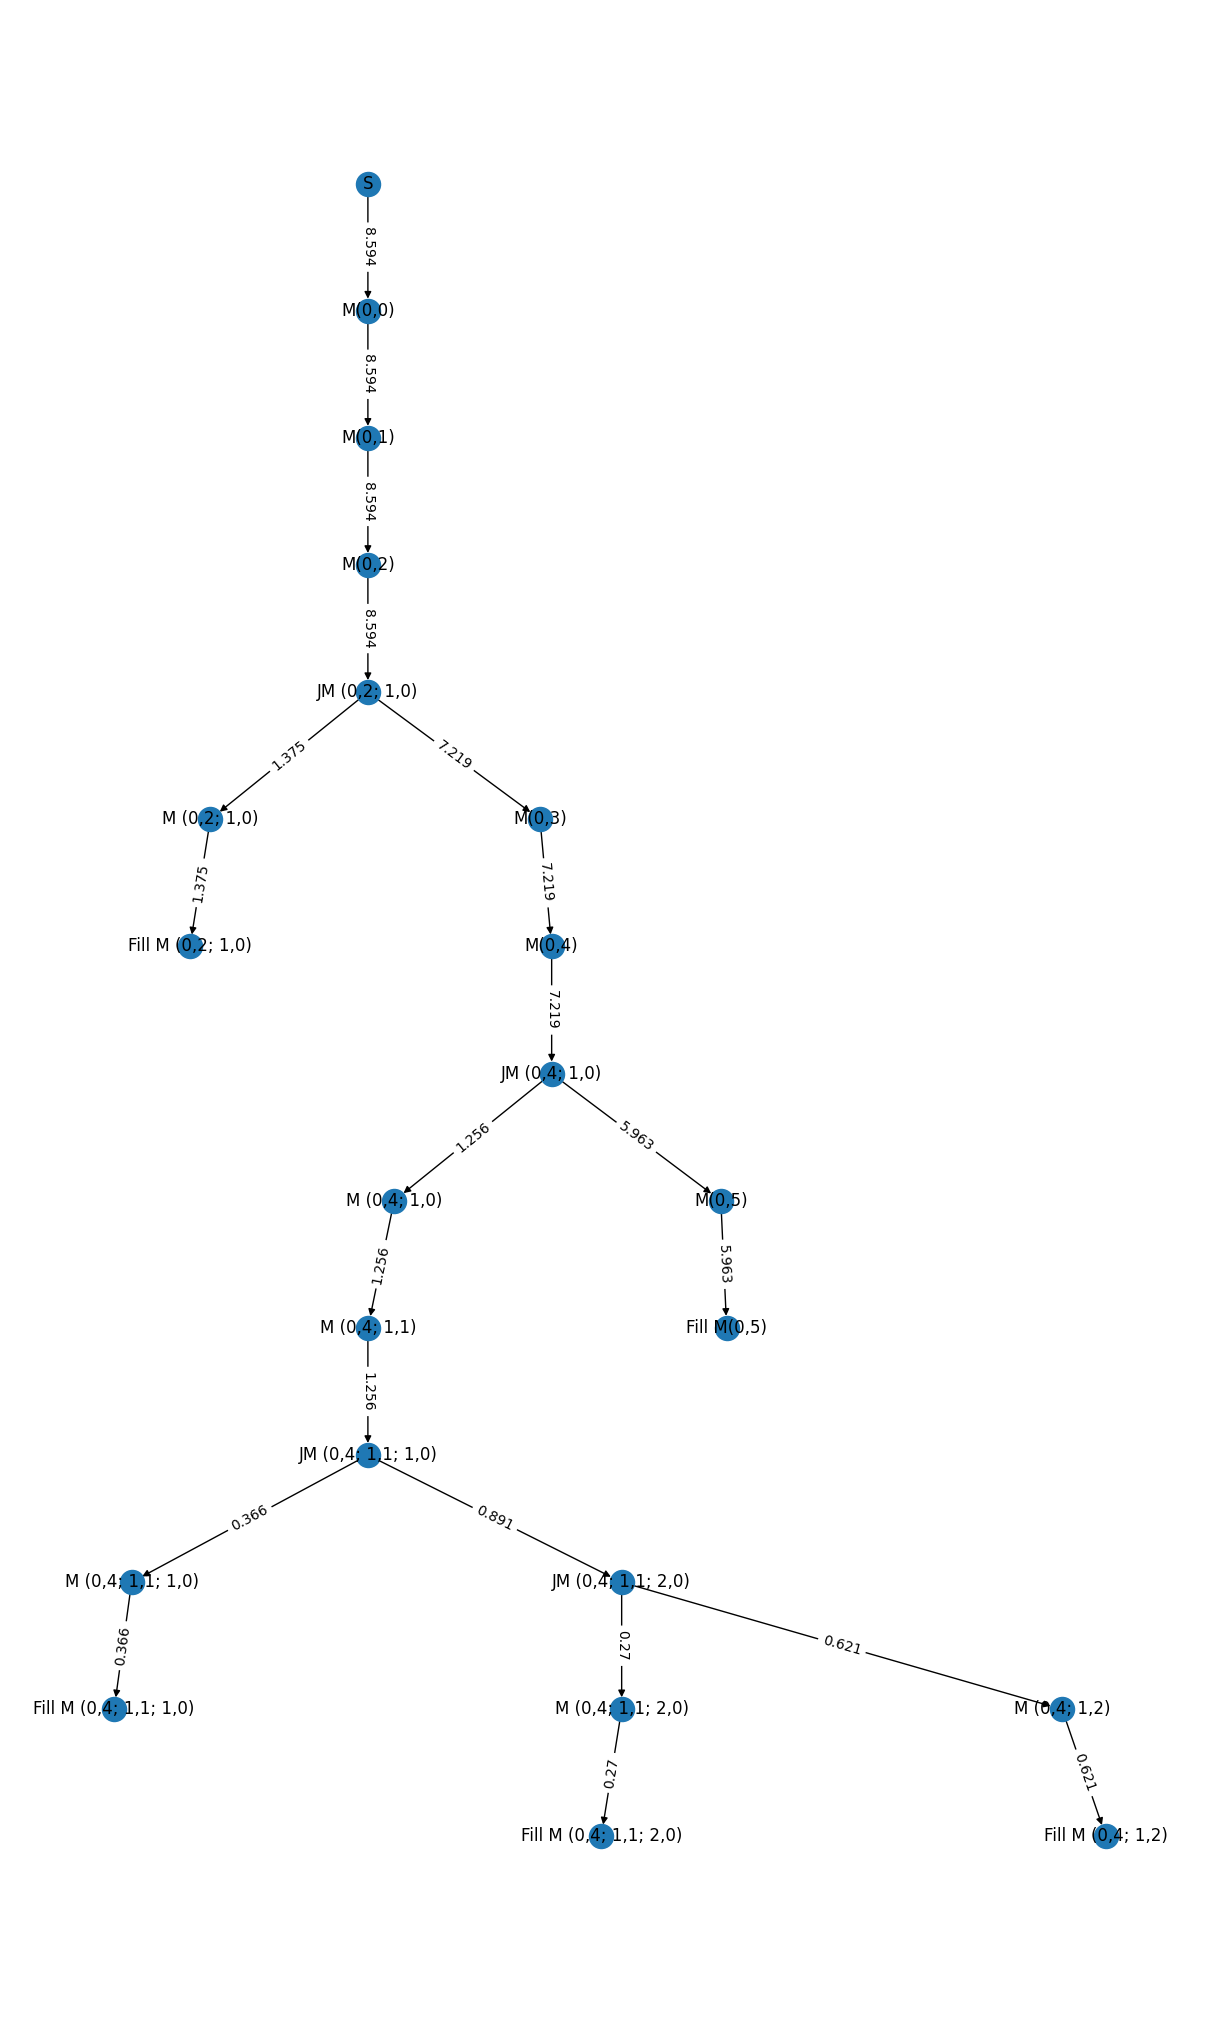


Step 4
163 mins
Fill Area:  M(0,5) 58318.0
Fill Area:  M (0,2; 1,1) 13448.0
Fill Area:  M (0,4; 1,1; 1,0) 3575.0
Fill Area:  M (0,4; 1,1; 2,0) 2636.0
Fill Area:  M (0,4; 1,2) 6077.0


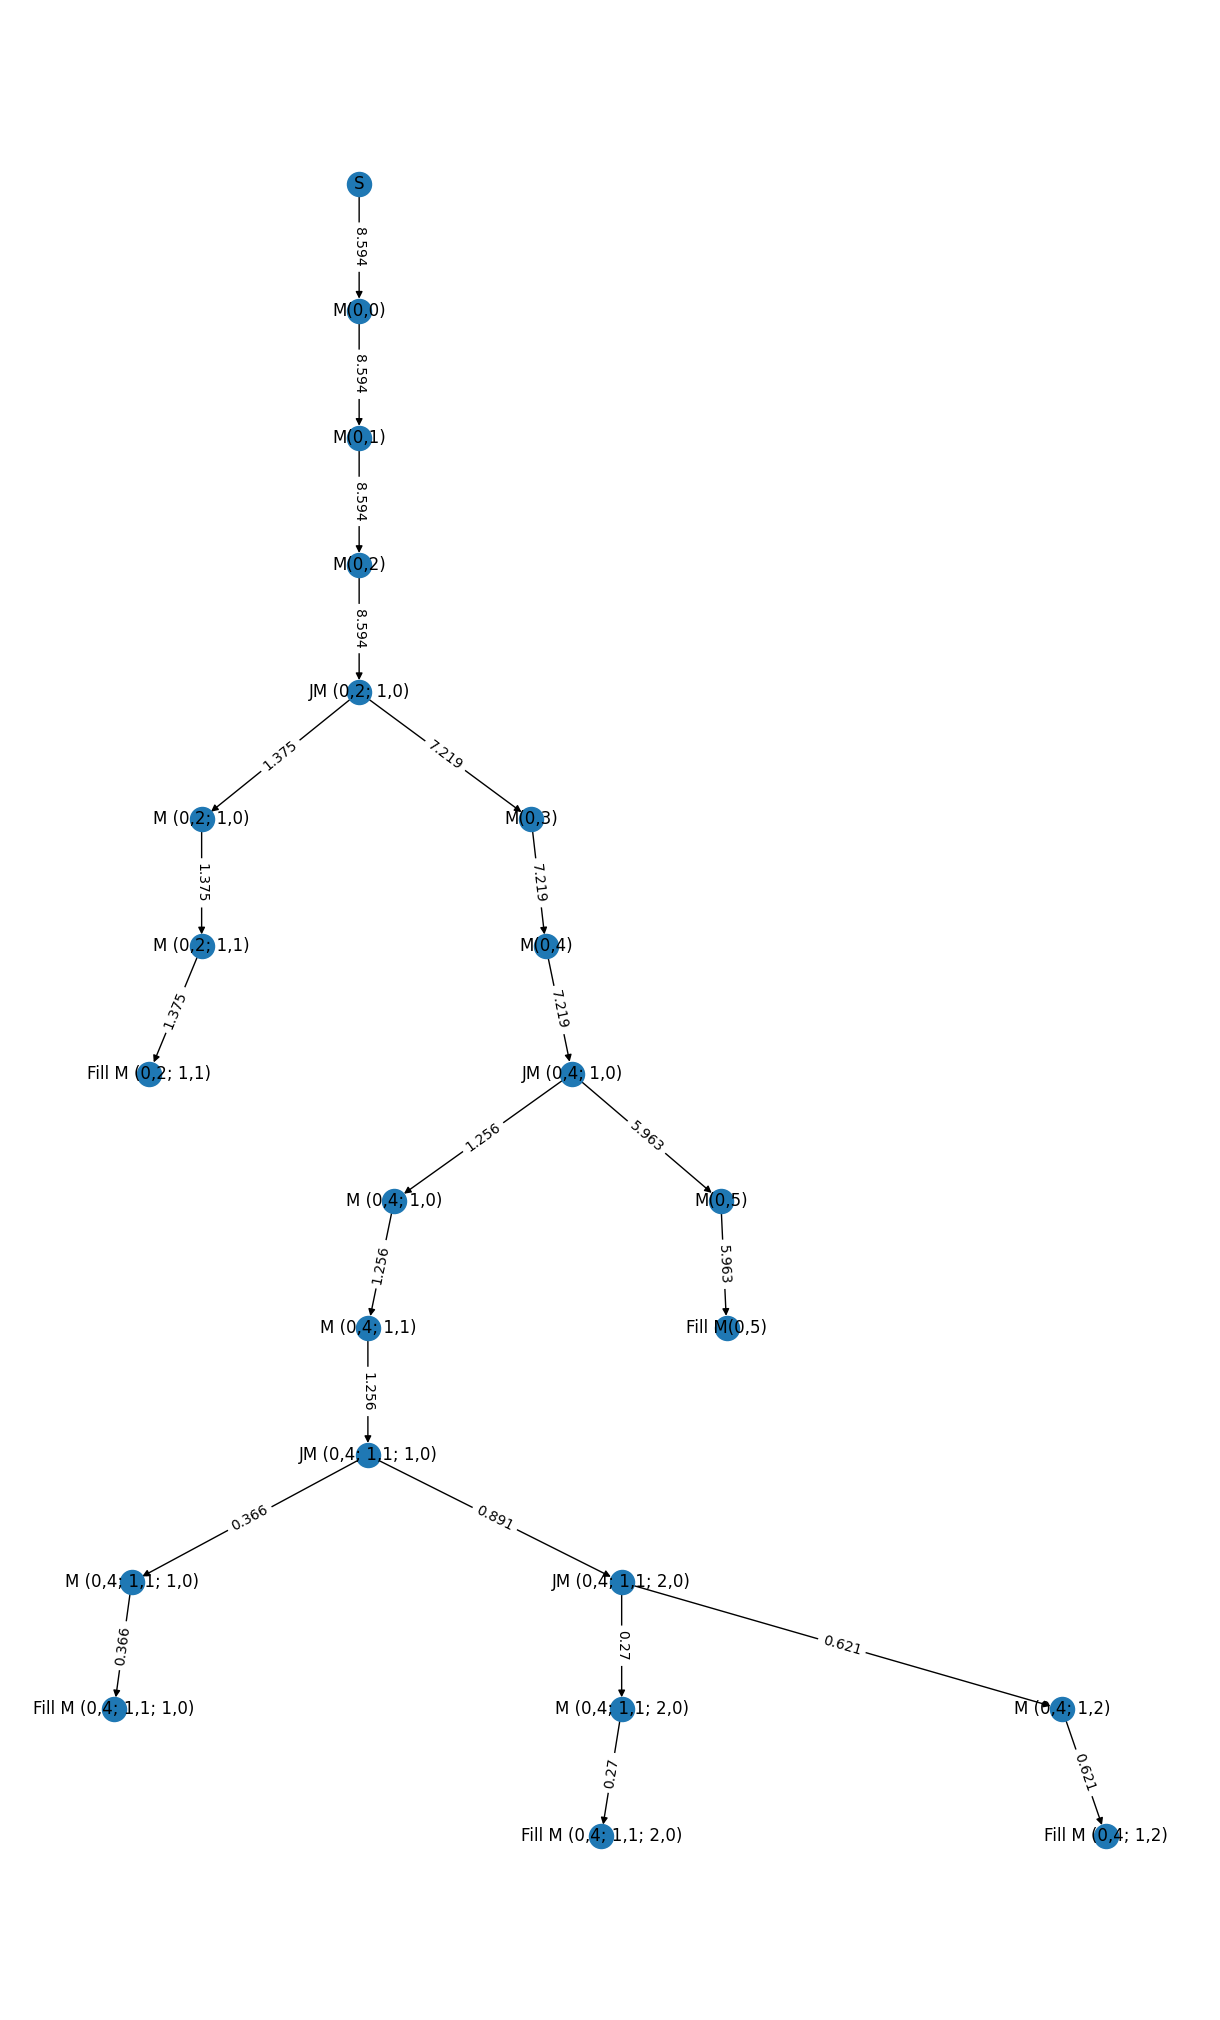


Step 5
422 mins
Fill Area:  M(0,6) 150983.0
Fill Area:  M (0,2; 1,1) 34815.0
Fill Area:  M (0,4; 1,1; 1,0) 9254.0
Fill Area:  M (0,4; 1,1; 2,0) 6824.0
Fill Area:  M (0,4; 1,2) 15732.0


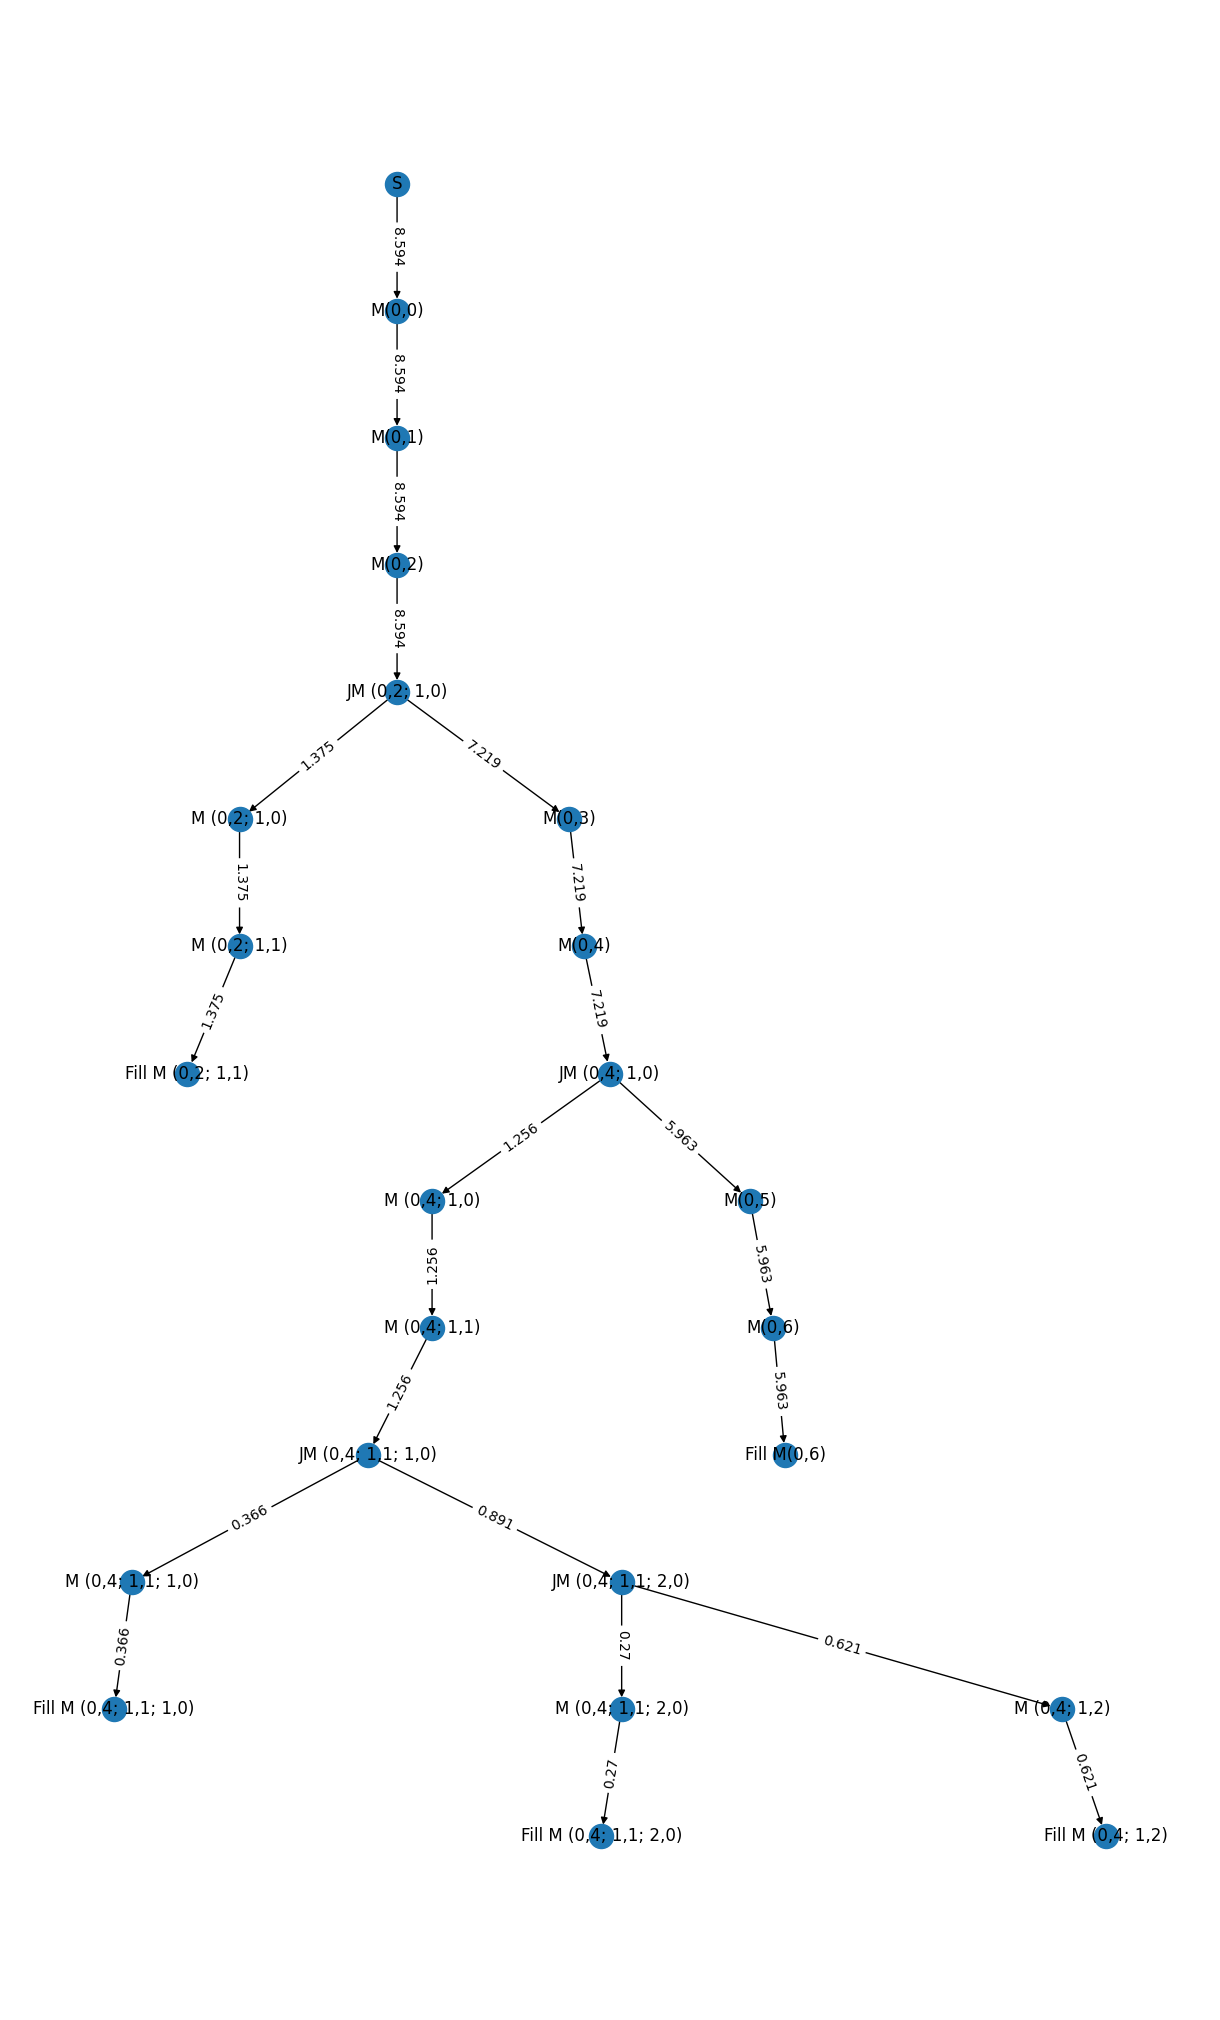


Step 6
578 mins
Fill Area:  M(0,7) 193480.0
Fill Area:  M (0,2; 1,1) 47685.0
Fill Area:  M (0,4; 1,1; 1,0) 12676.0
Fill Area:  M (0,4; 1,1; 2,0) 9346.0
Fill Area:  M (0,4; 1,2) 21548.0


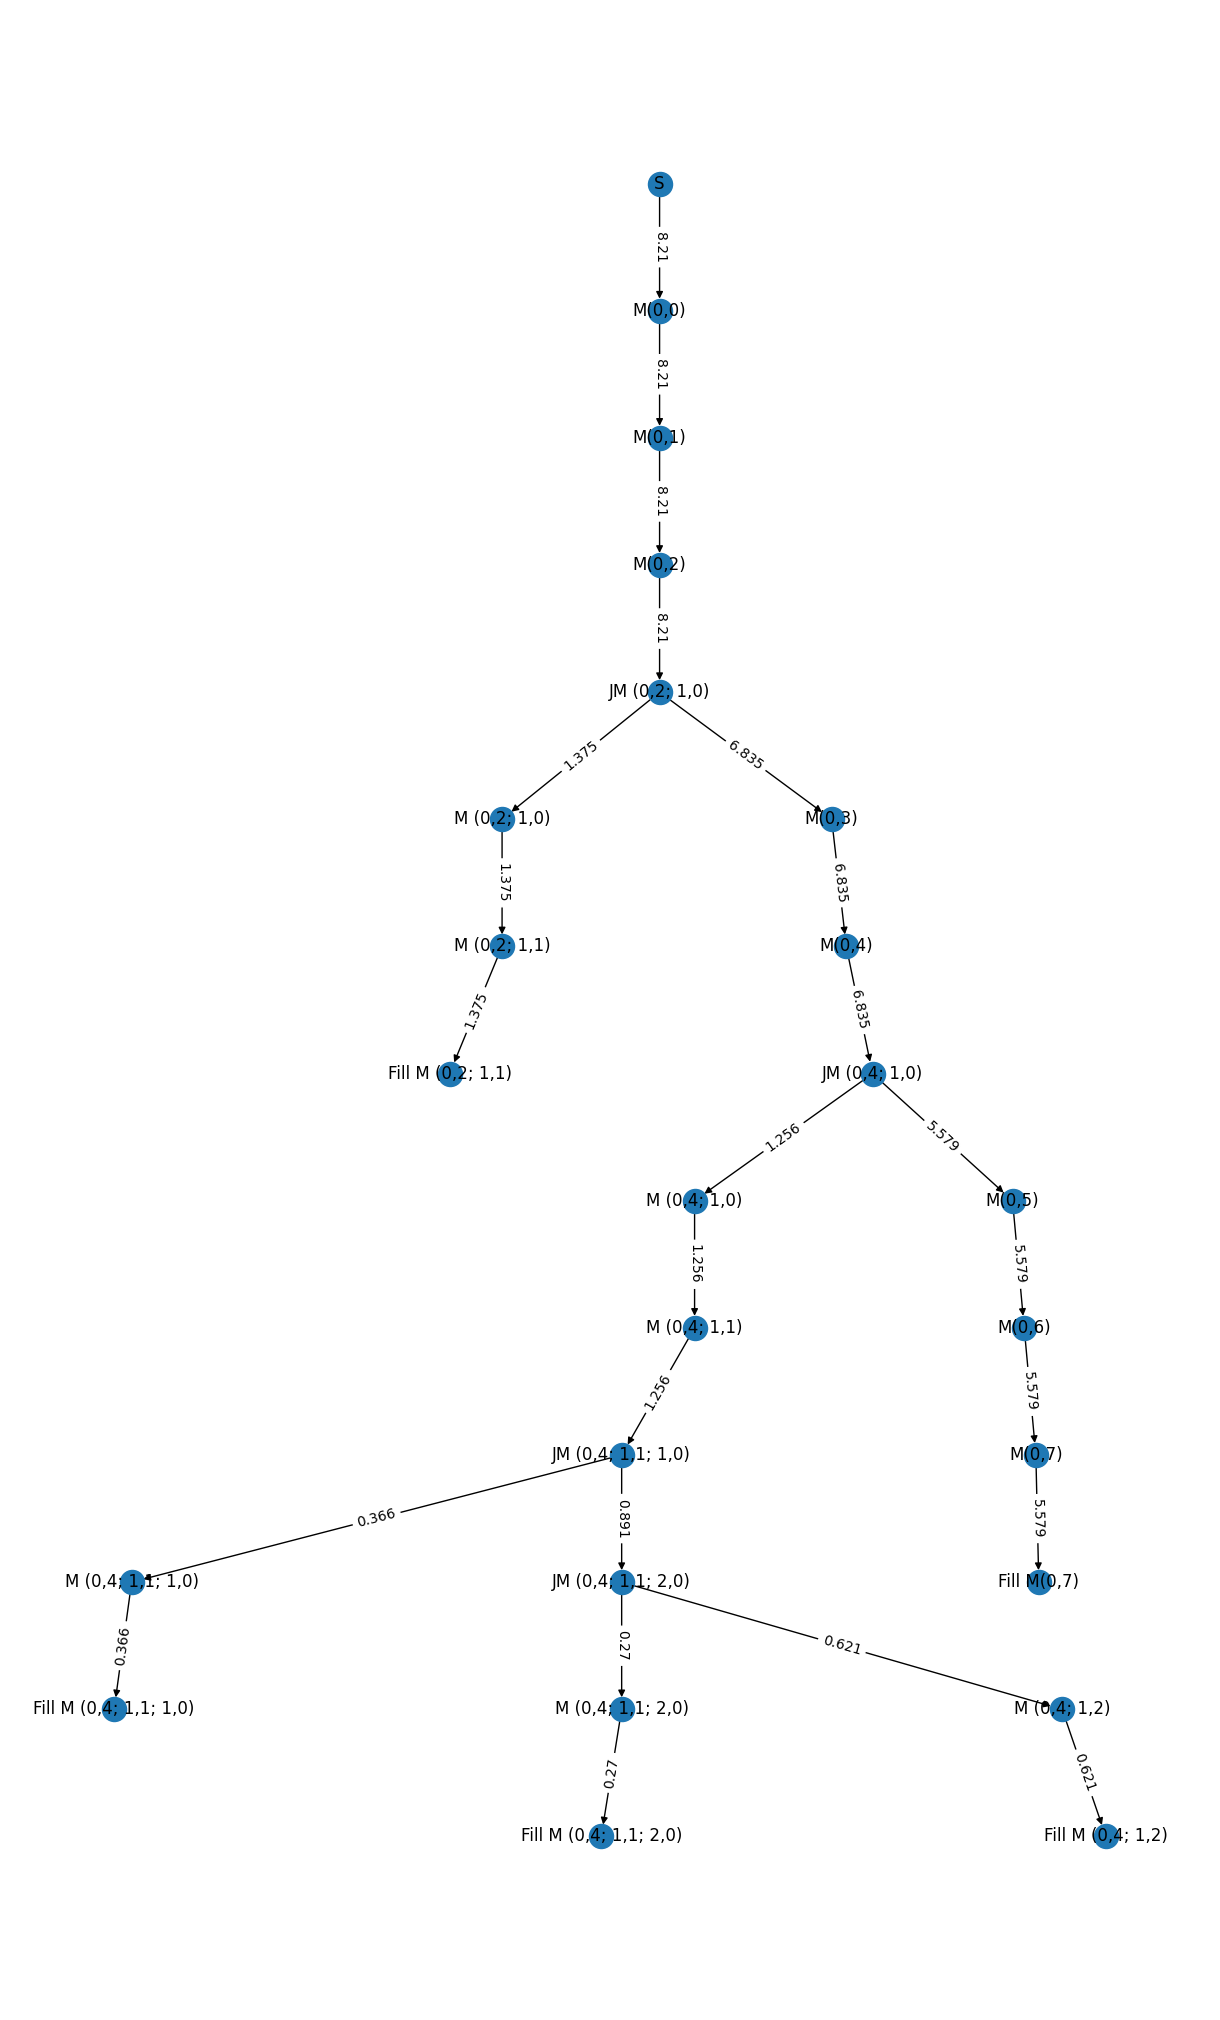


Step 7
307 mins
Fill Area:  M(0,8) 100021.0
Fill Area:  M (0,2; 1,1) 25328.0
Fill Area:  M (0,4; 1,1; 1,0) 6733.0
Fill Area:  M (0,4; 1,1; 2,0) 4964.0
Fill Area:  M (0,4; 1,2) 11445.0


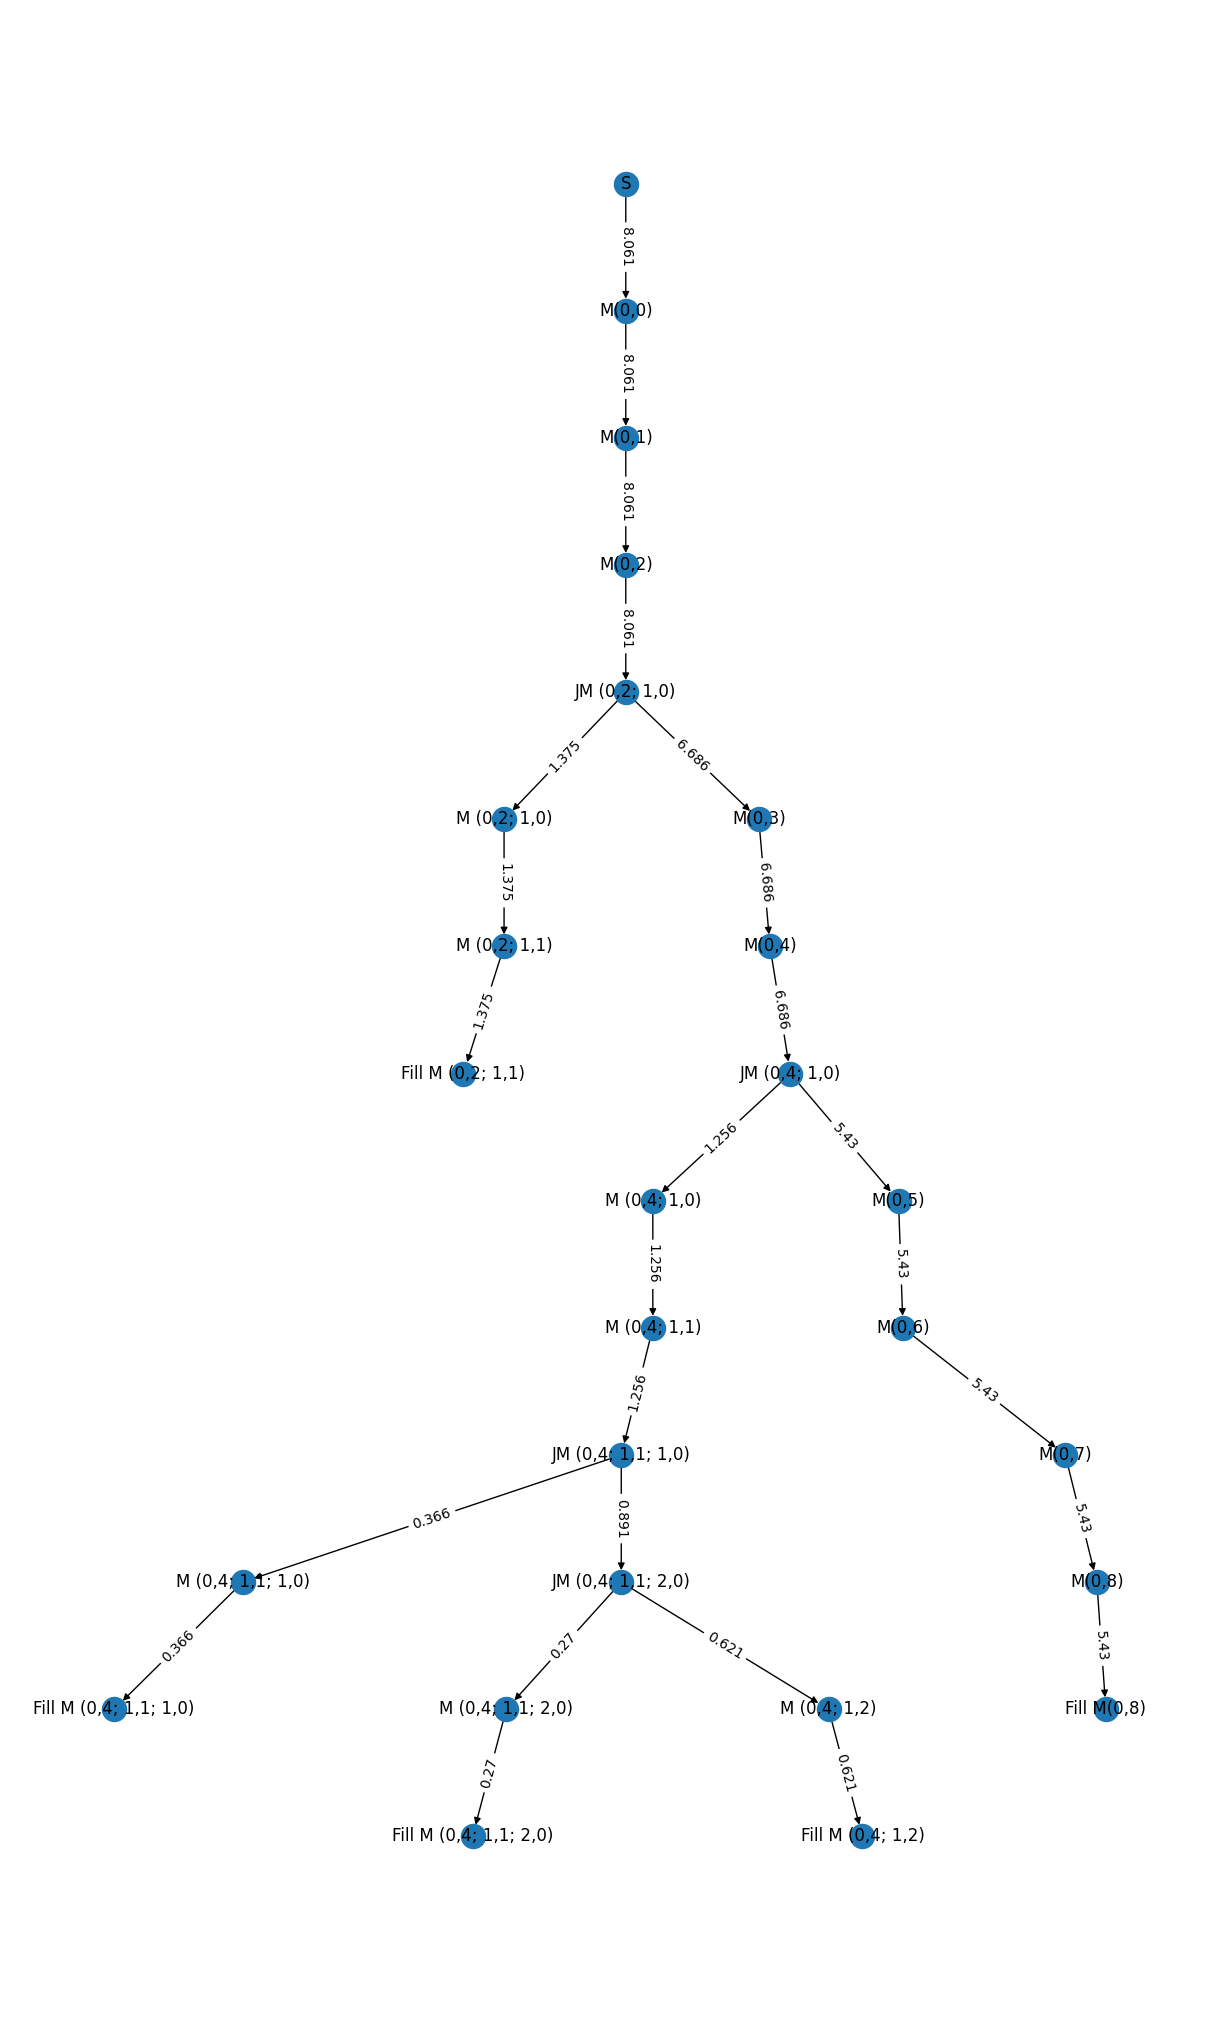


Step 8
353 mins
Fill Area:  M(0,9) 115007.0
Fill Area:  M (0,2; 1,1) 29122.0
Fill Area:  M (0,4; 1,1; 1,0) 7741.0
Fill Area:  M (0,4; 1,1; 2,0) 5708.0
Fill Area:  M (0,4; 1,2) 13160.0


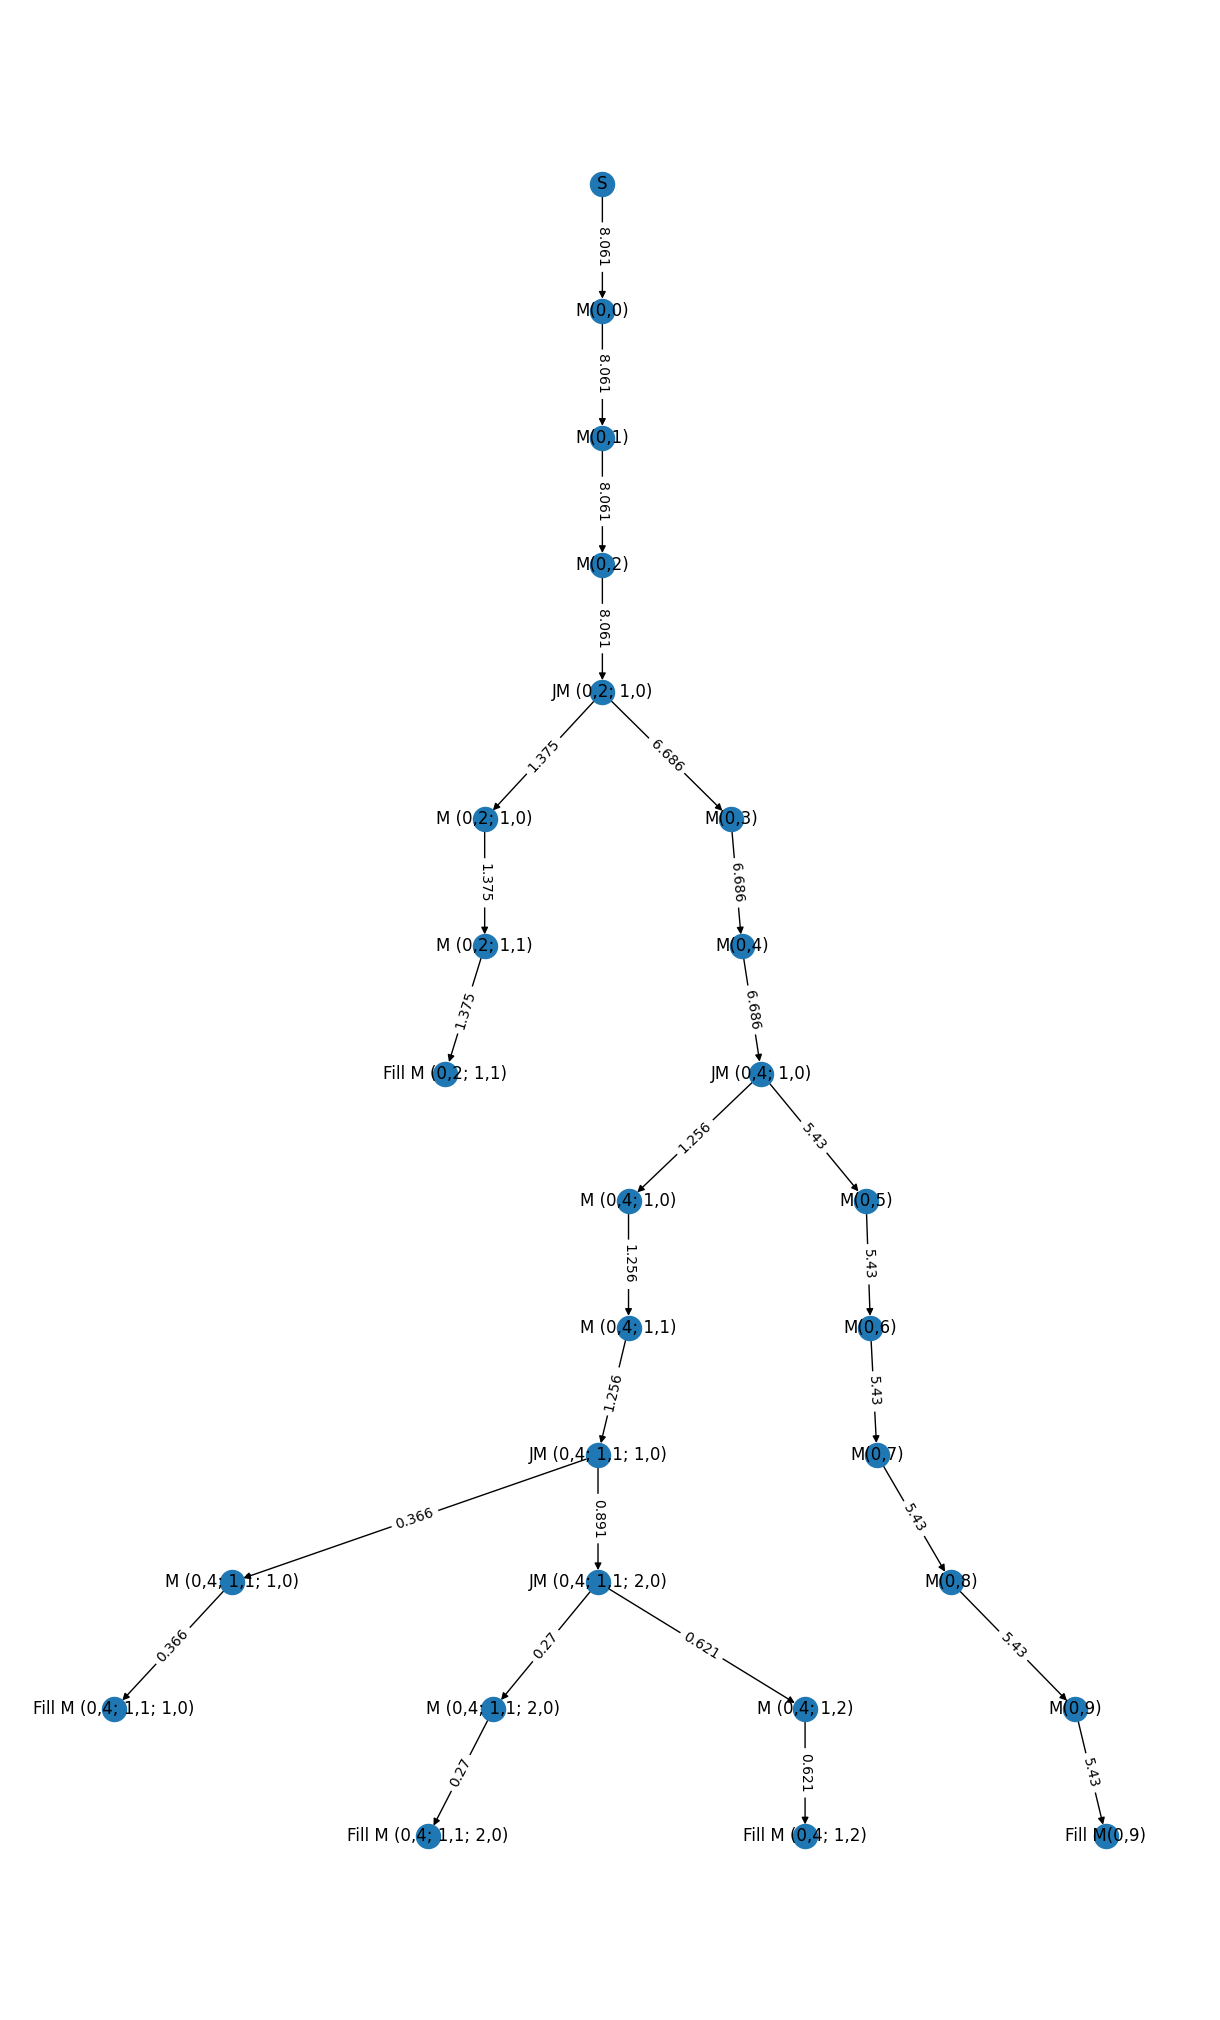


Step 9
295 mins
Fill Area:  M(0,10) 89951.0
Fill Area:  M (0,2; 1,1) 24338.0
Fill Area:  M (0,4; 1,1; 1,0) 6469.0
Fill Area:  M (0,4; 1,1; 2,0) 4770.0
Fill Area:  M (0,4; 1,2) 10998.0


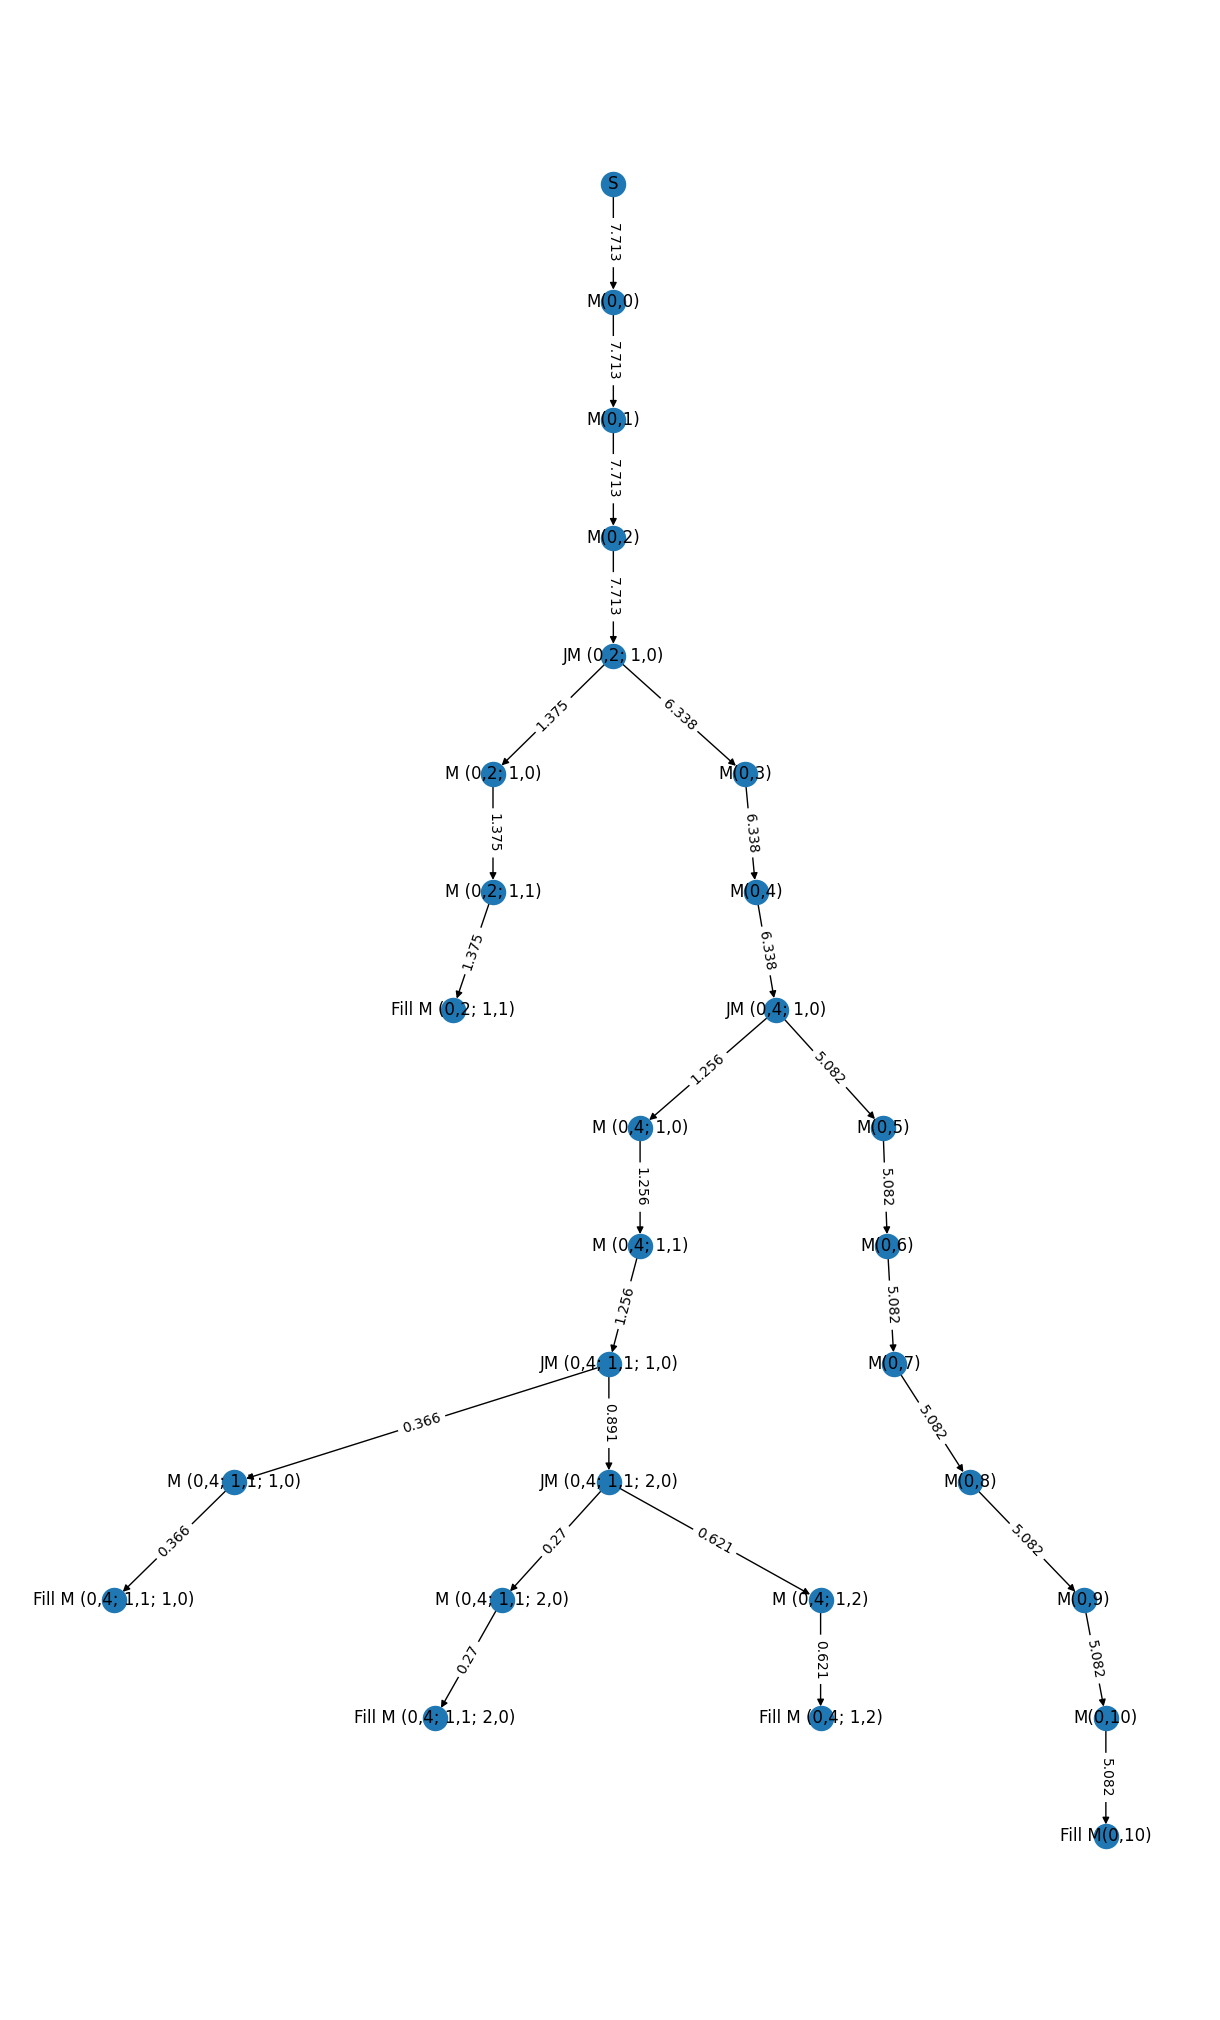


Step 10
25 mins
Fill Area:  M(0,10) 7623.0
Fill Area:  M (0,2; 1,1) 2062.0
Fill Area:  M (0,4; 1,1; 2,0) 404.0
Fill Area:  M (0,4; 1,2) 932.0


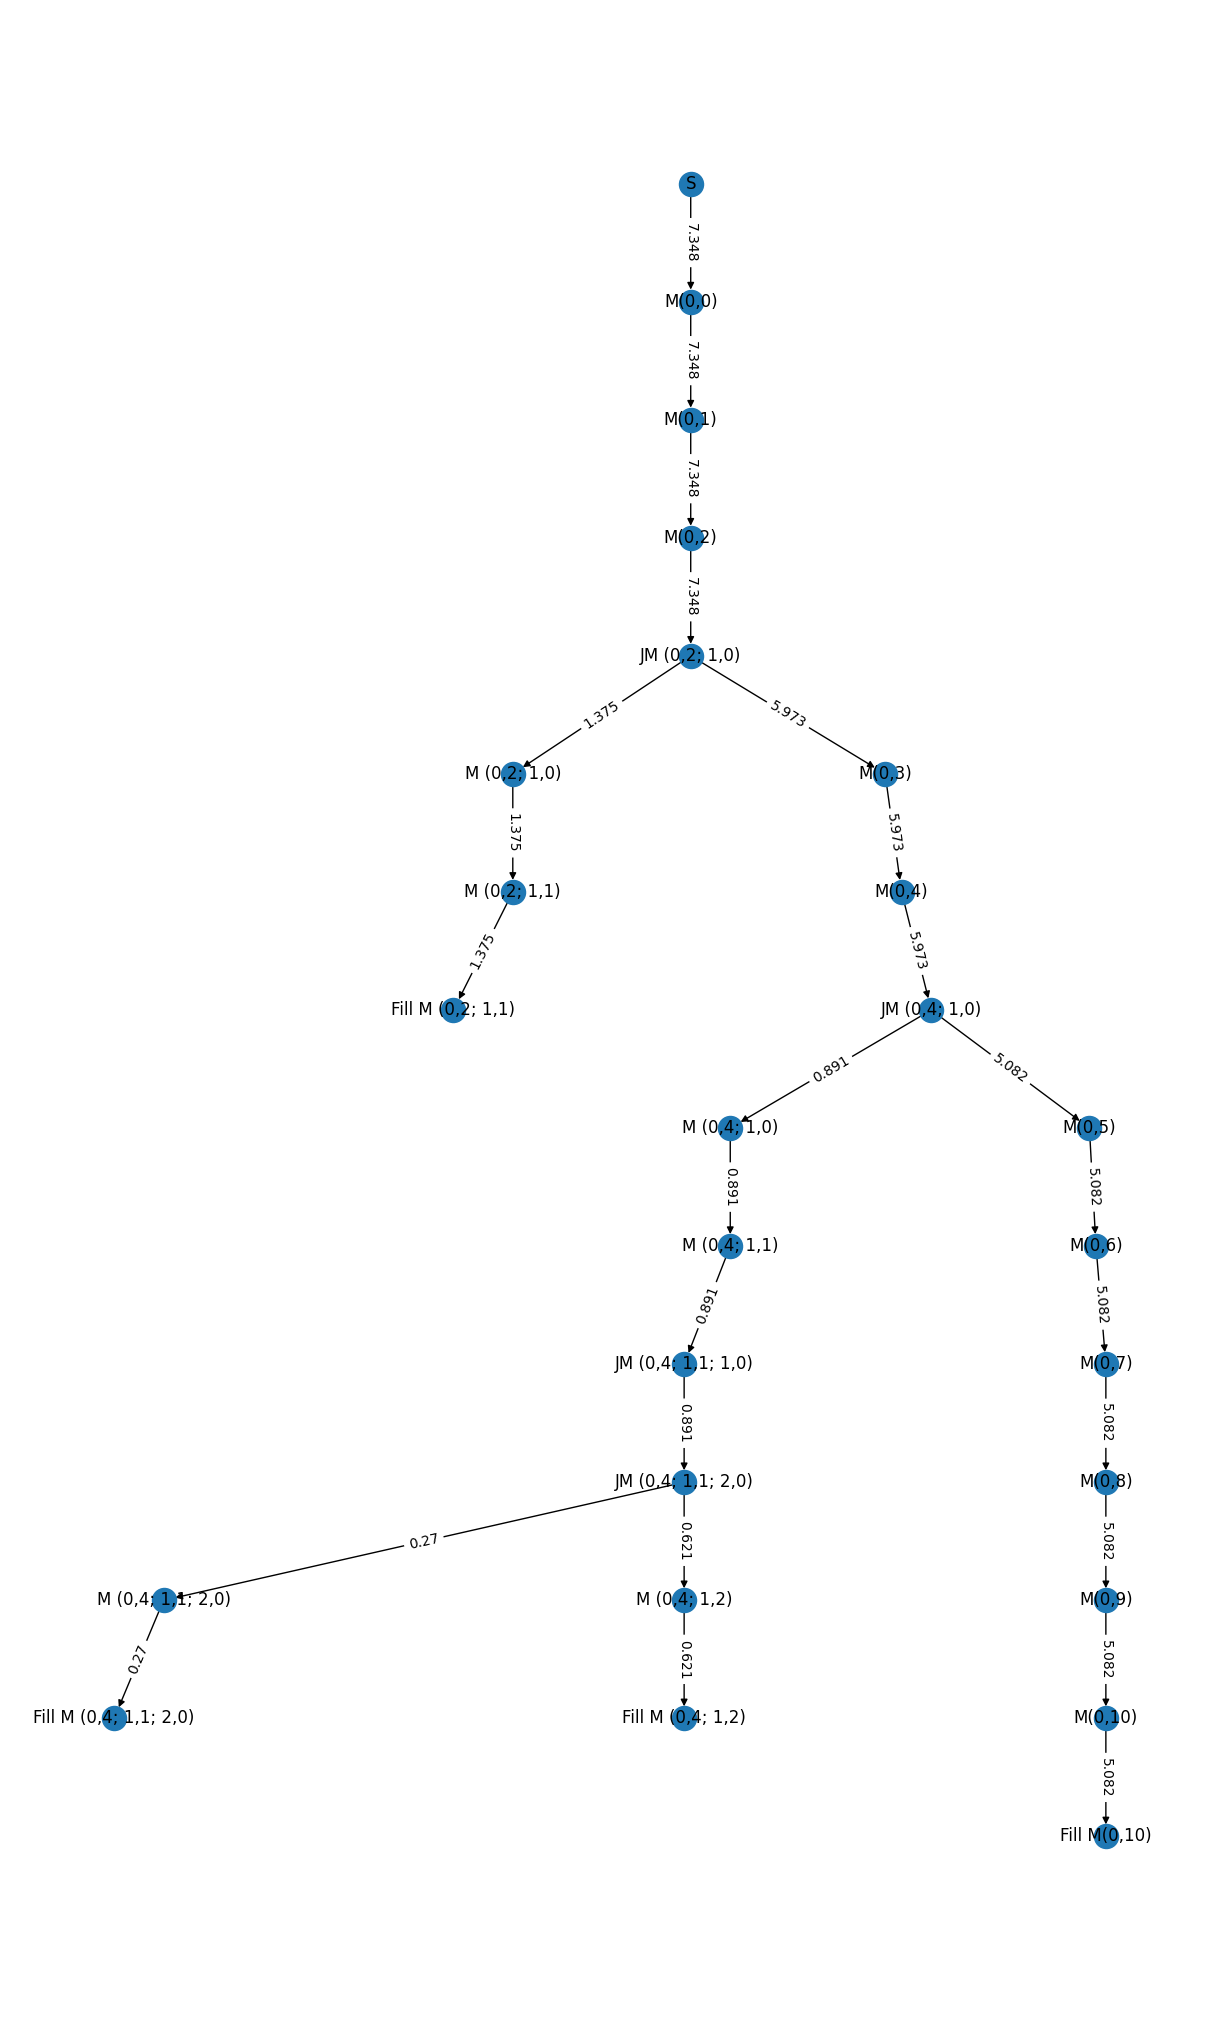


Step 11
241 mins
Fill Area:  M(0,10) 73486.0
Fill Area:  M (0,2; 1,1) 19882.0
Fill Area:  M (0,4; 1,2) 8984.0


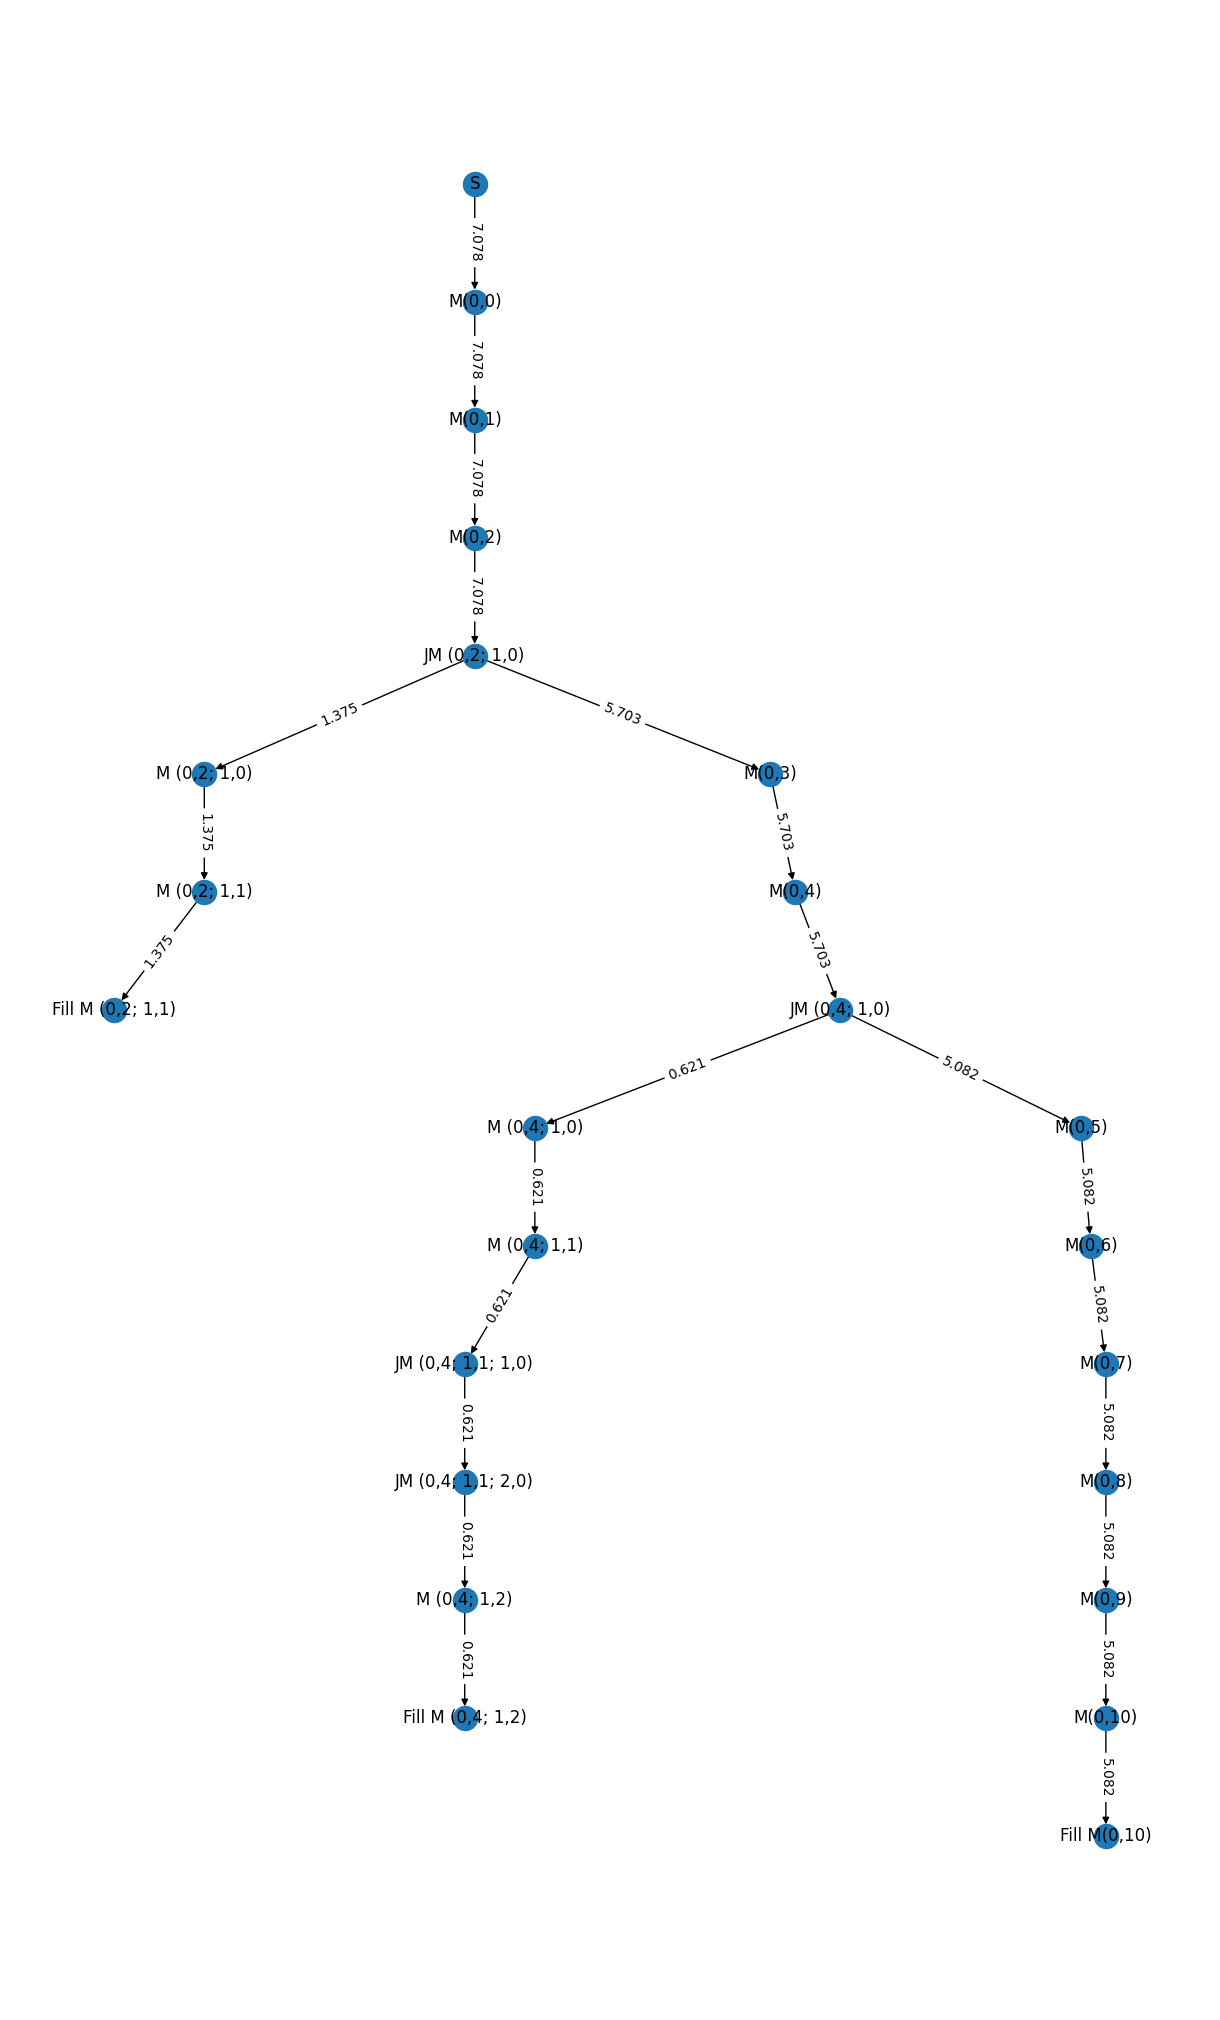


Step 12
266 mins
Fill Area:  M(0,11) 74150.0
Fill Area:  M (0,2; 1,1) 21945.0
Fill Area:  M (0,4; 1,2) 9916.0


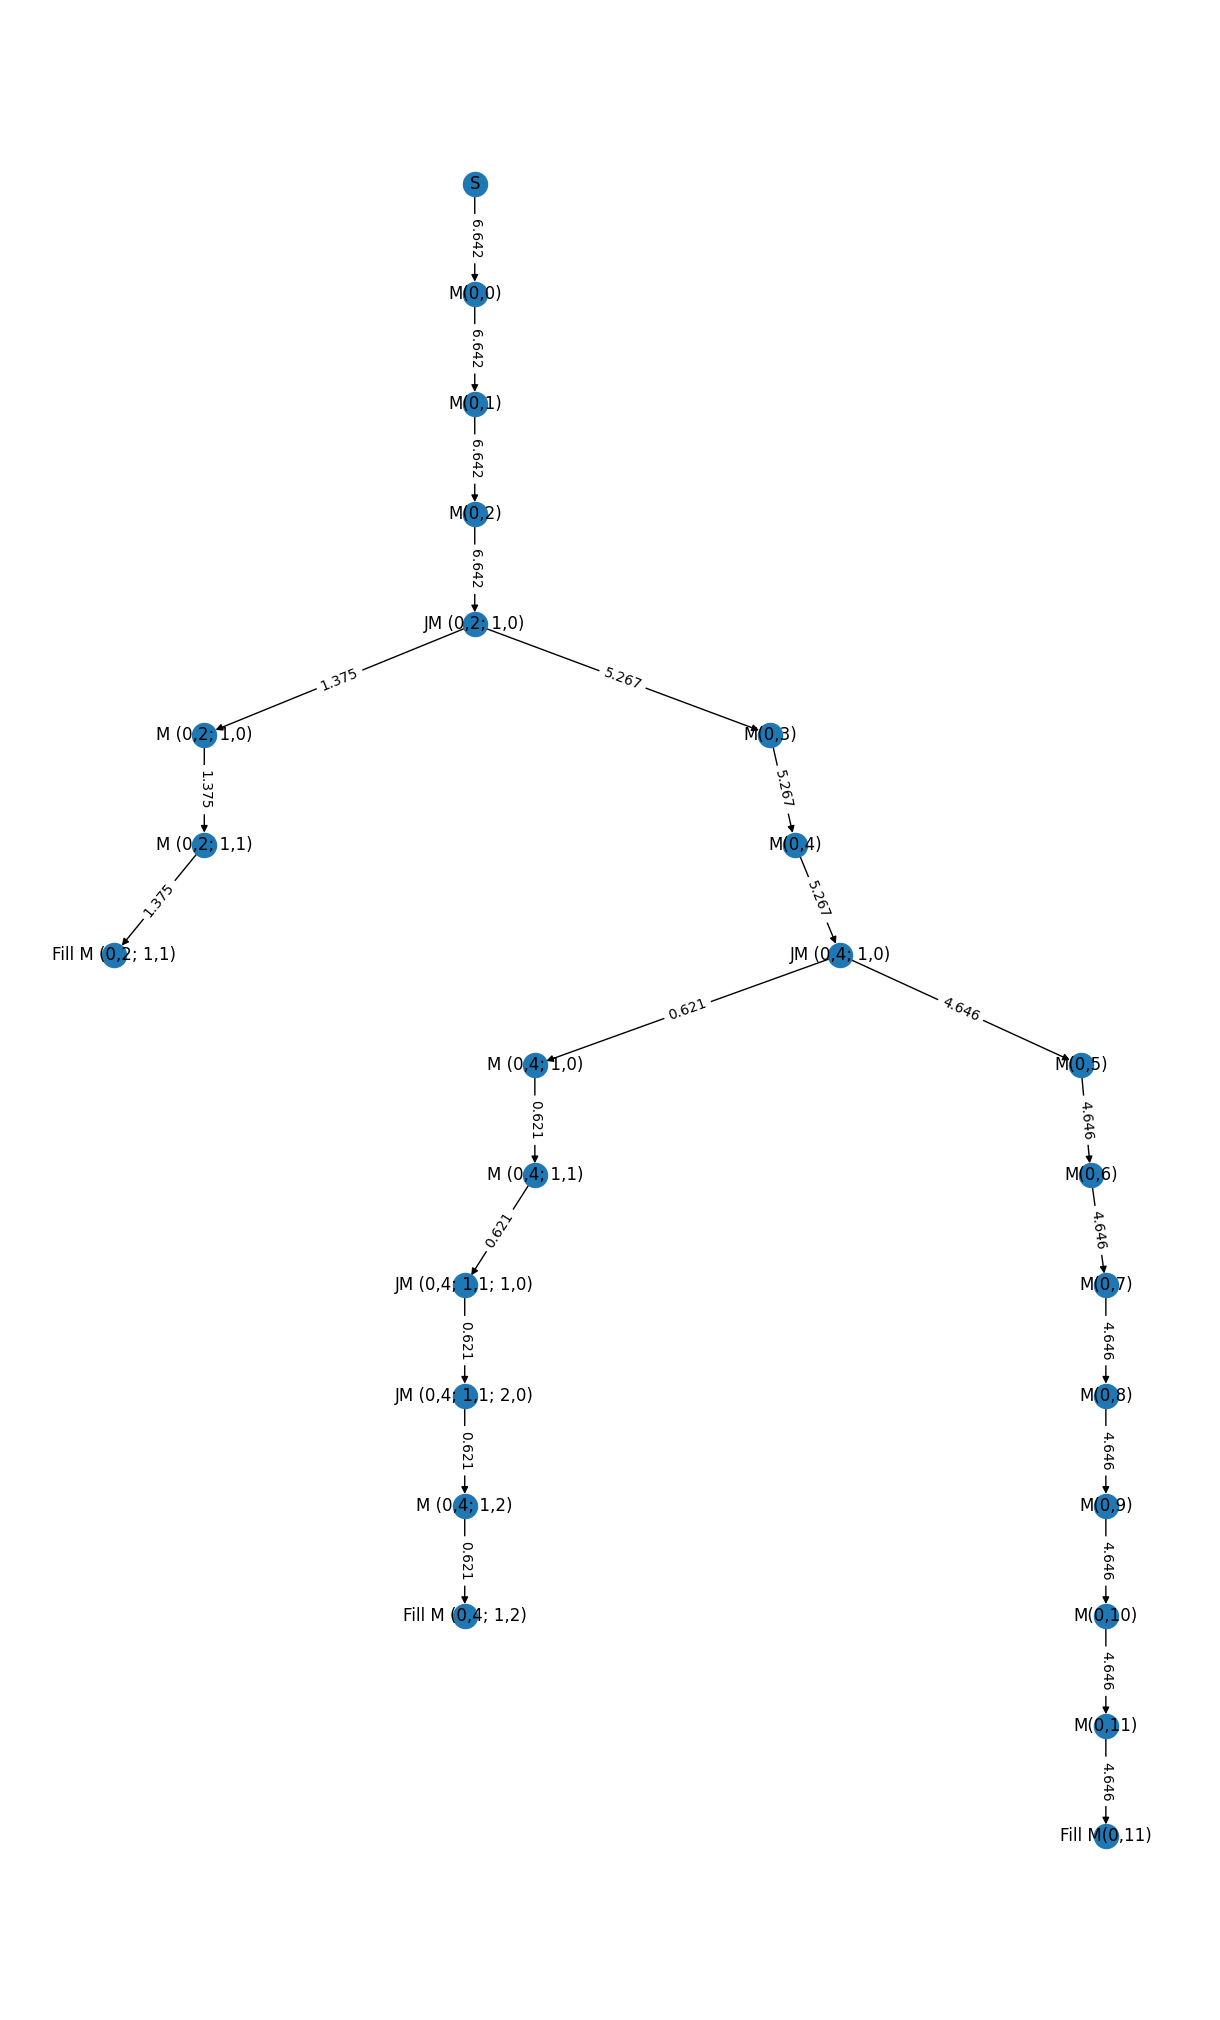


Step 13
634 mins
Fill Area:  M(0,11) 176734.0
Fill Area:  M(0,2; 1,1; 1,0) 31003.0
Fill Area:  M (0,2; 1,2) 21302.0
Fill Area:  M (0,4; 1,2) 23636.0


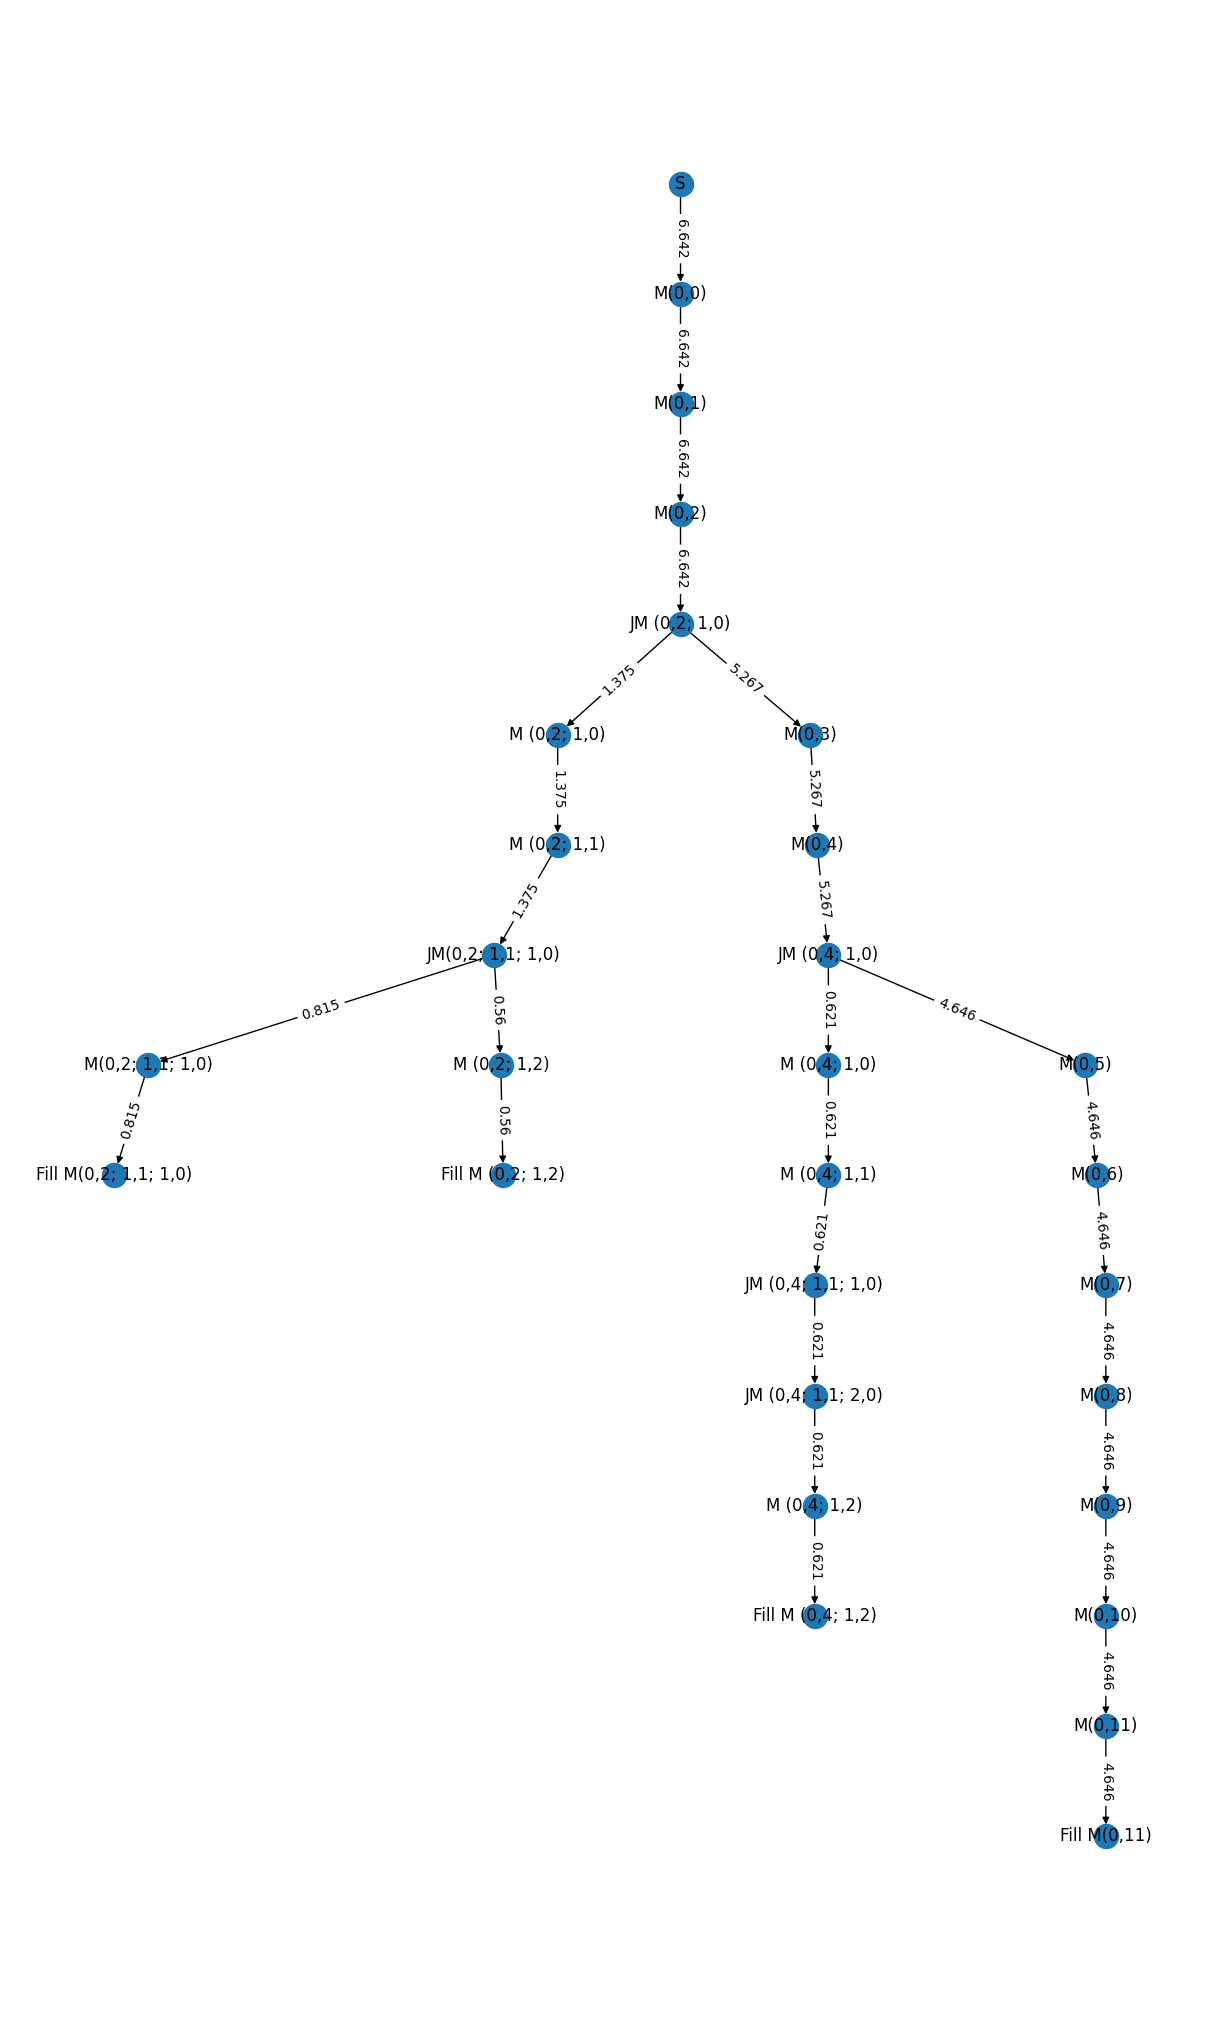


Step 14
344 mins
Fill Area:  M(0,12) 86255.0
Fill Area:  M(0,2; 1,1; 1,0) 16822.0
Fill Area:  M (0,2; 1,2) 11558.0
Fill Area:  M (0,4; 1,2) 12824.0


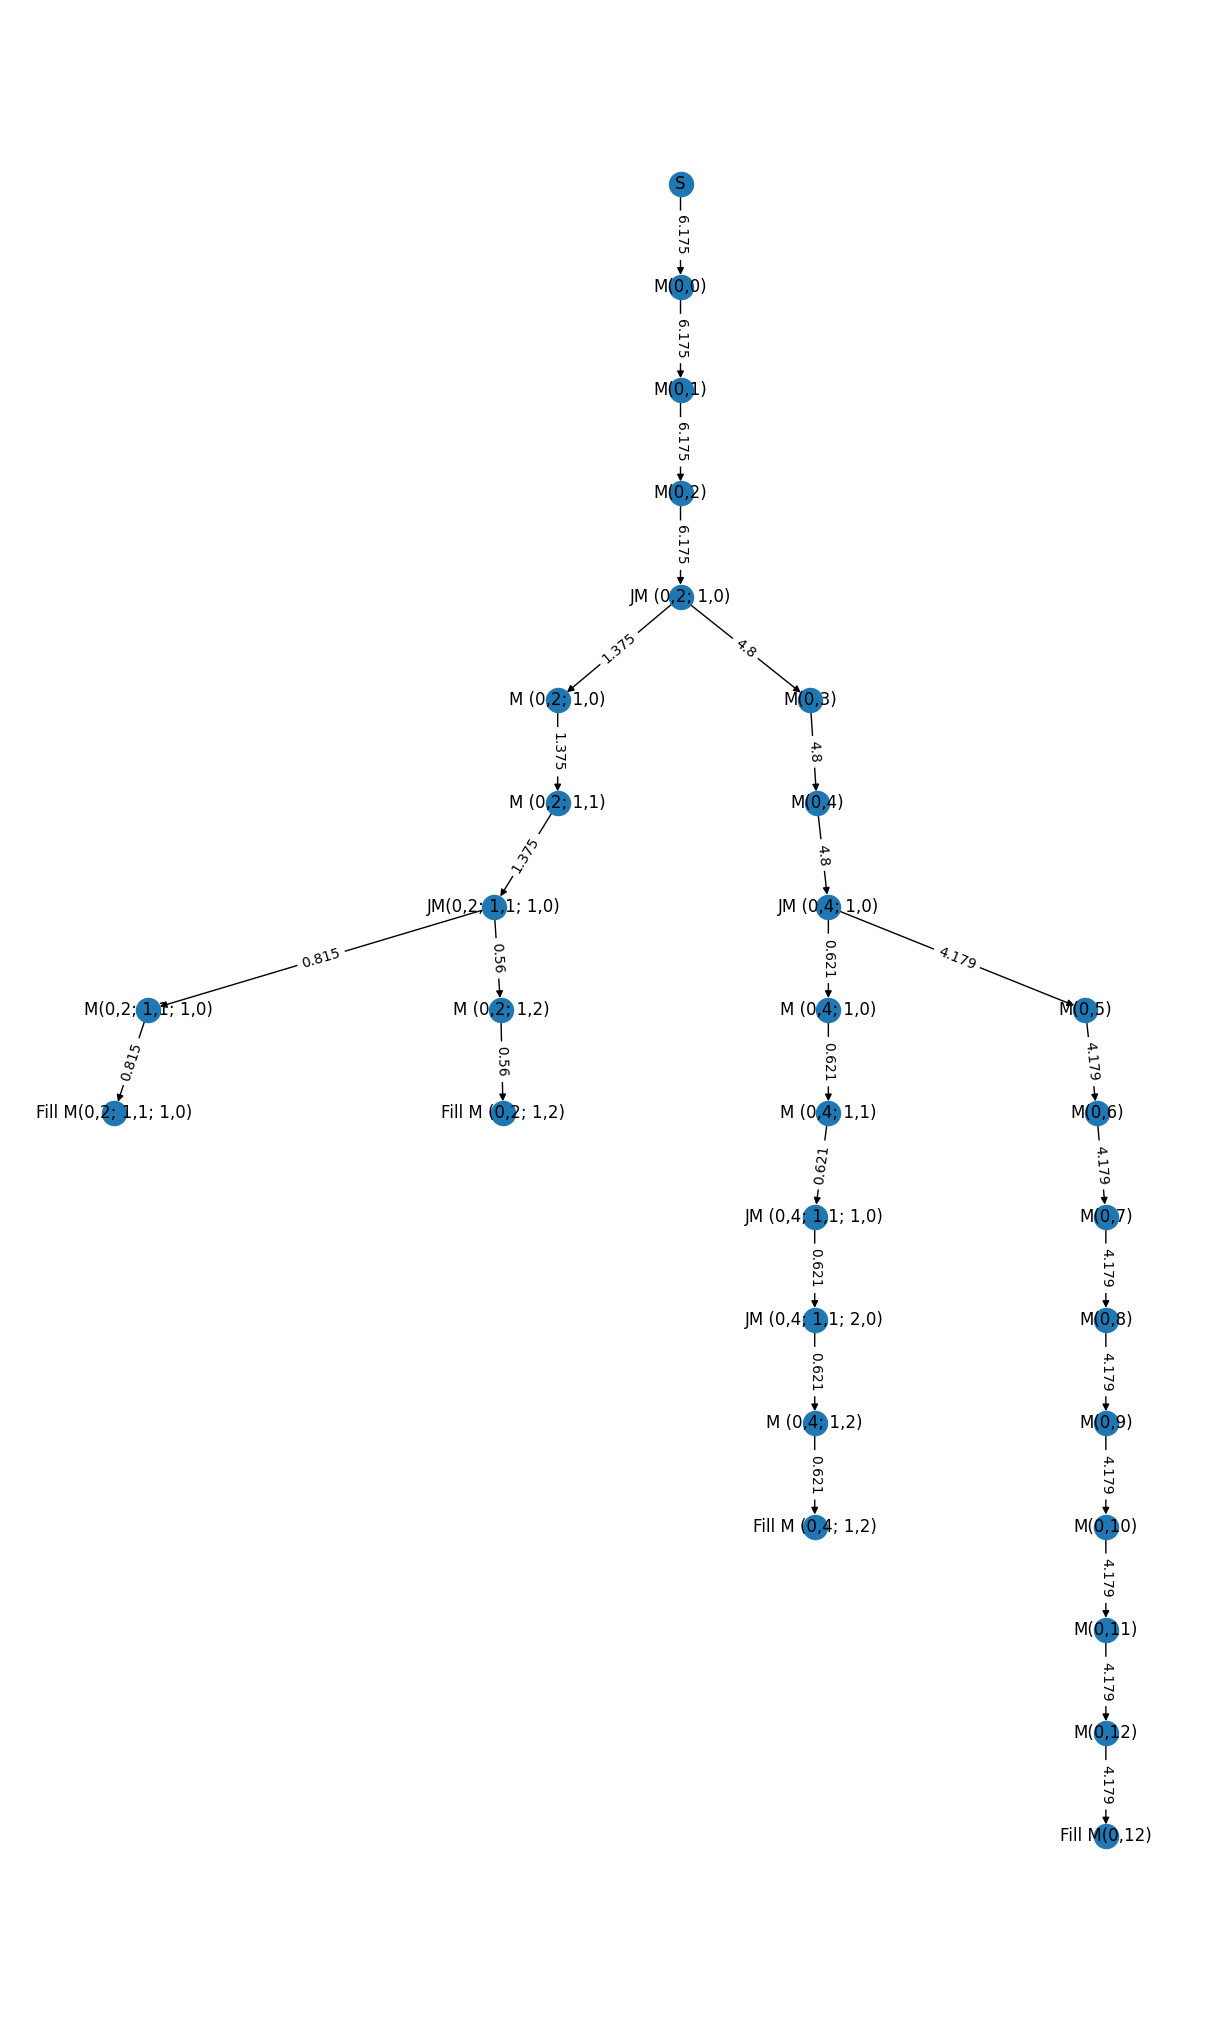


Step 15
42 mins
Fill Area:  M(0,13) 10531.0
Fill Area:  M(0,2; 1,1; 1,0) 2054.0
Fill Area:  M (0,2; 1,2) 1411.0
Fill Area:  M (0,4; 1,2) 1566.0


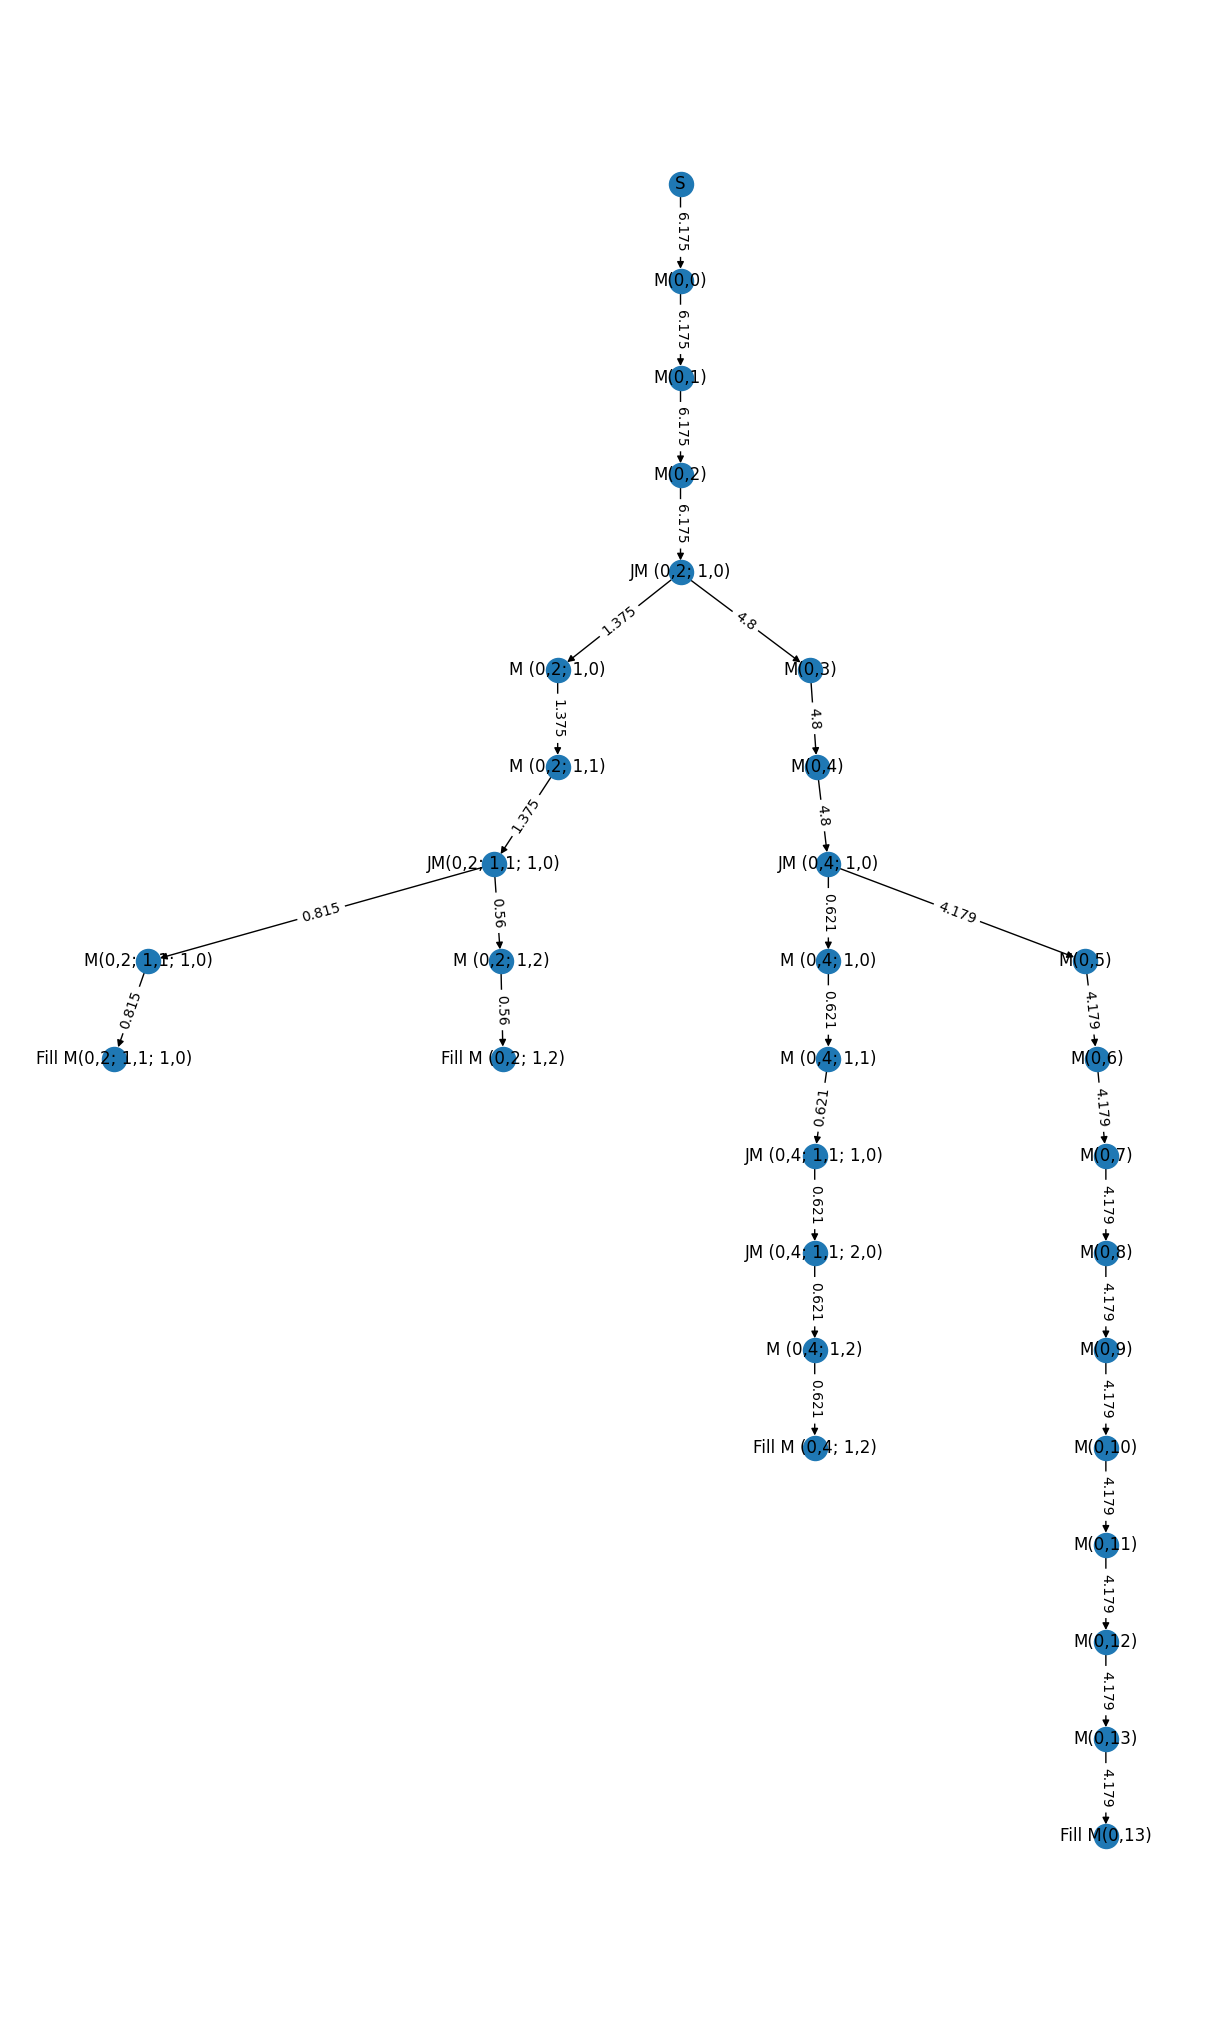


Step 16
430 mins
Fill Area:  M (0,13; 1,0) 94222.0
Fill Area:  M(0,14) 4696.0
Fill Area:  M(0,2; 1,1; 1,0) 21027.0
Fill Area:  M (0,2; 1,2) 14448.0
Fill Area:  M (0,4; 1,2) 16030.0


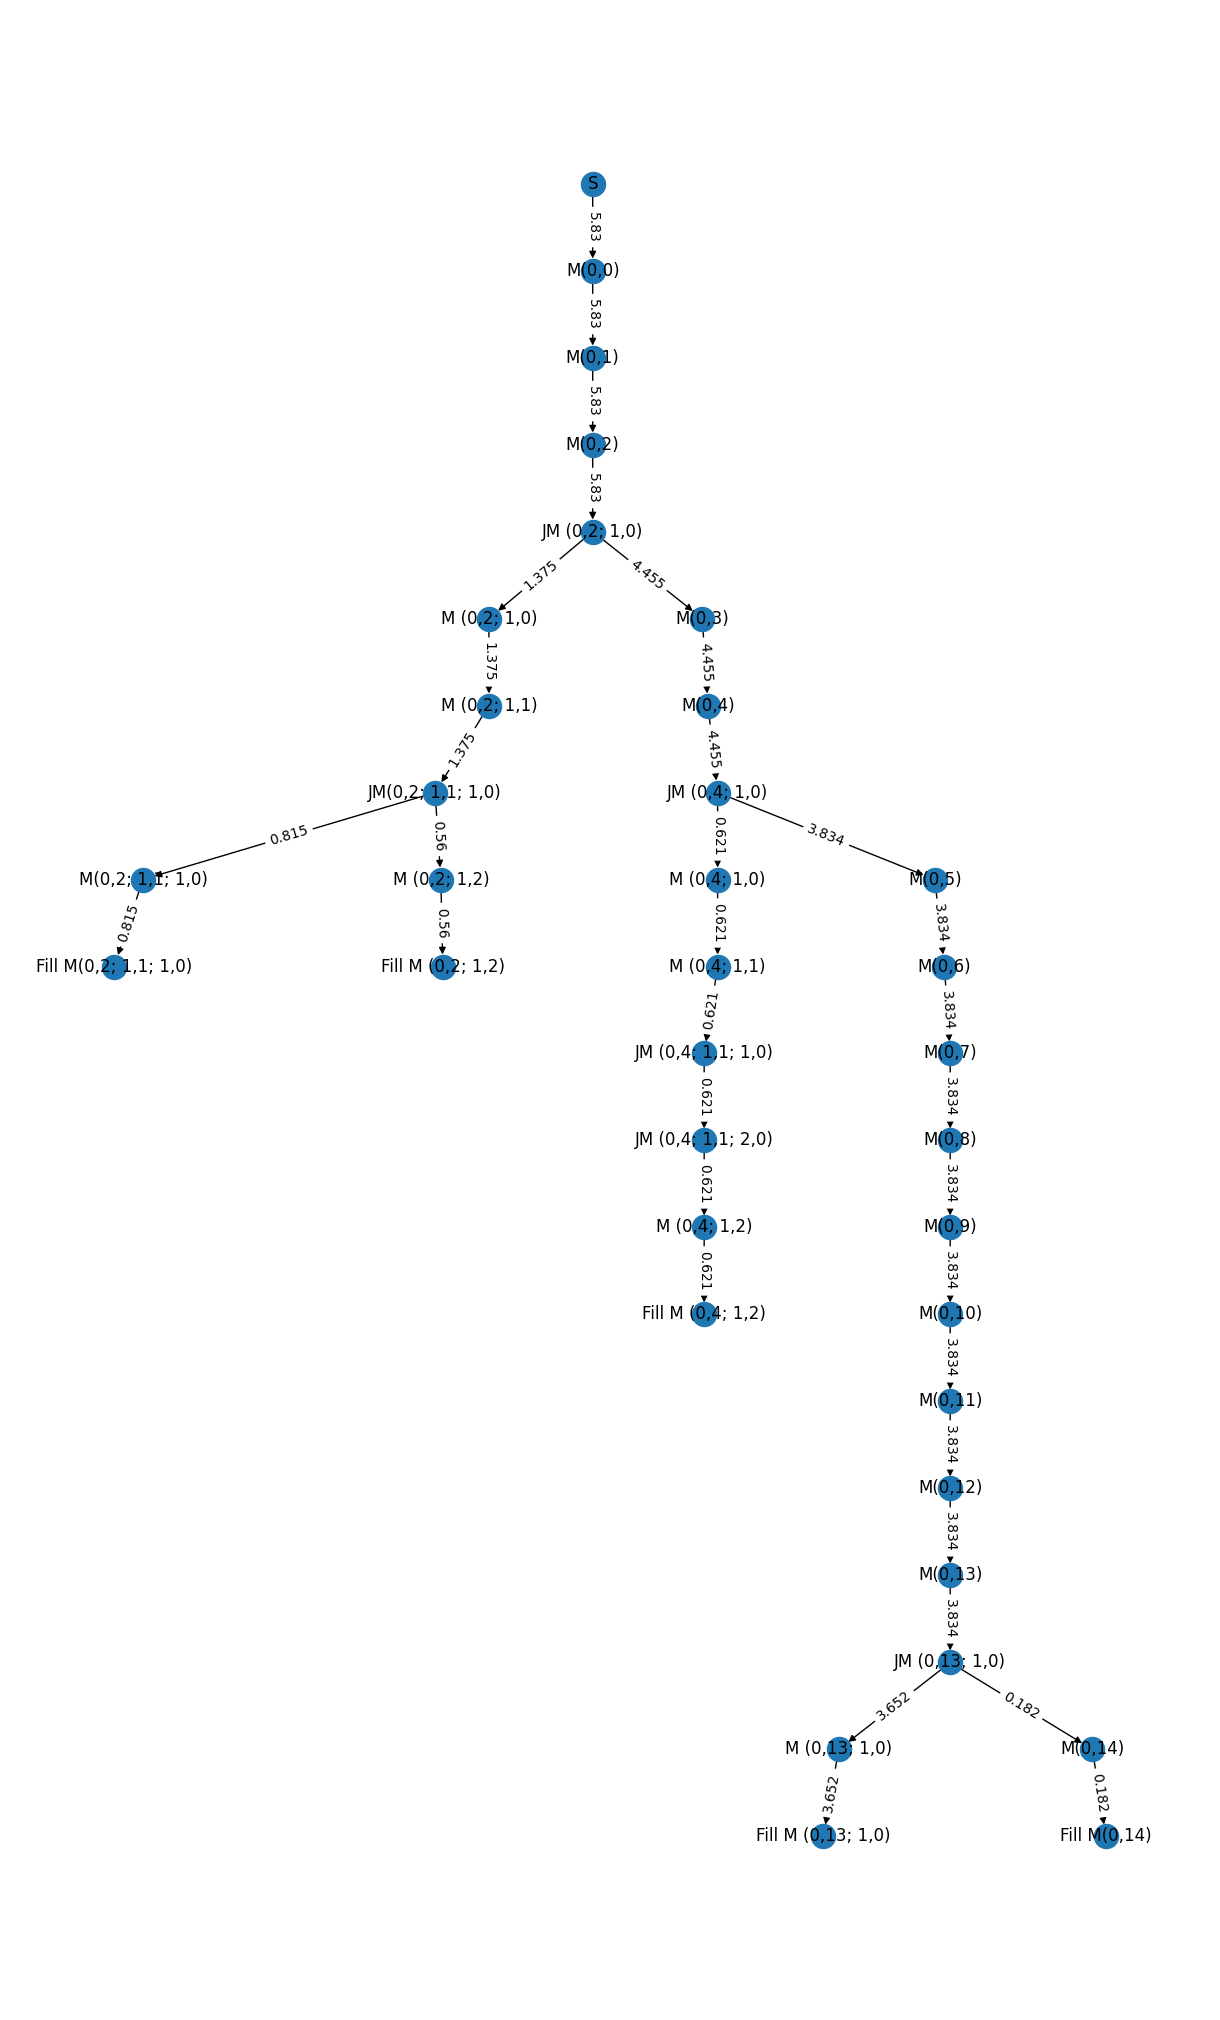


Step 17
535 mins
Fill Area:  M(0,14) 5842.0
Fill Area:  M(0,2; 1,1; 1,0) 26162.0
Fill Area:  M (0,2; 1,2) 17976.0
Fill Area:  M (0,4; 1,2) 19945.0
Fill Area:  M (0,13; 1,0; 1,0) 11171.0
Fill Area:  M (0,13; 1,1) 64457.0


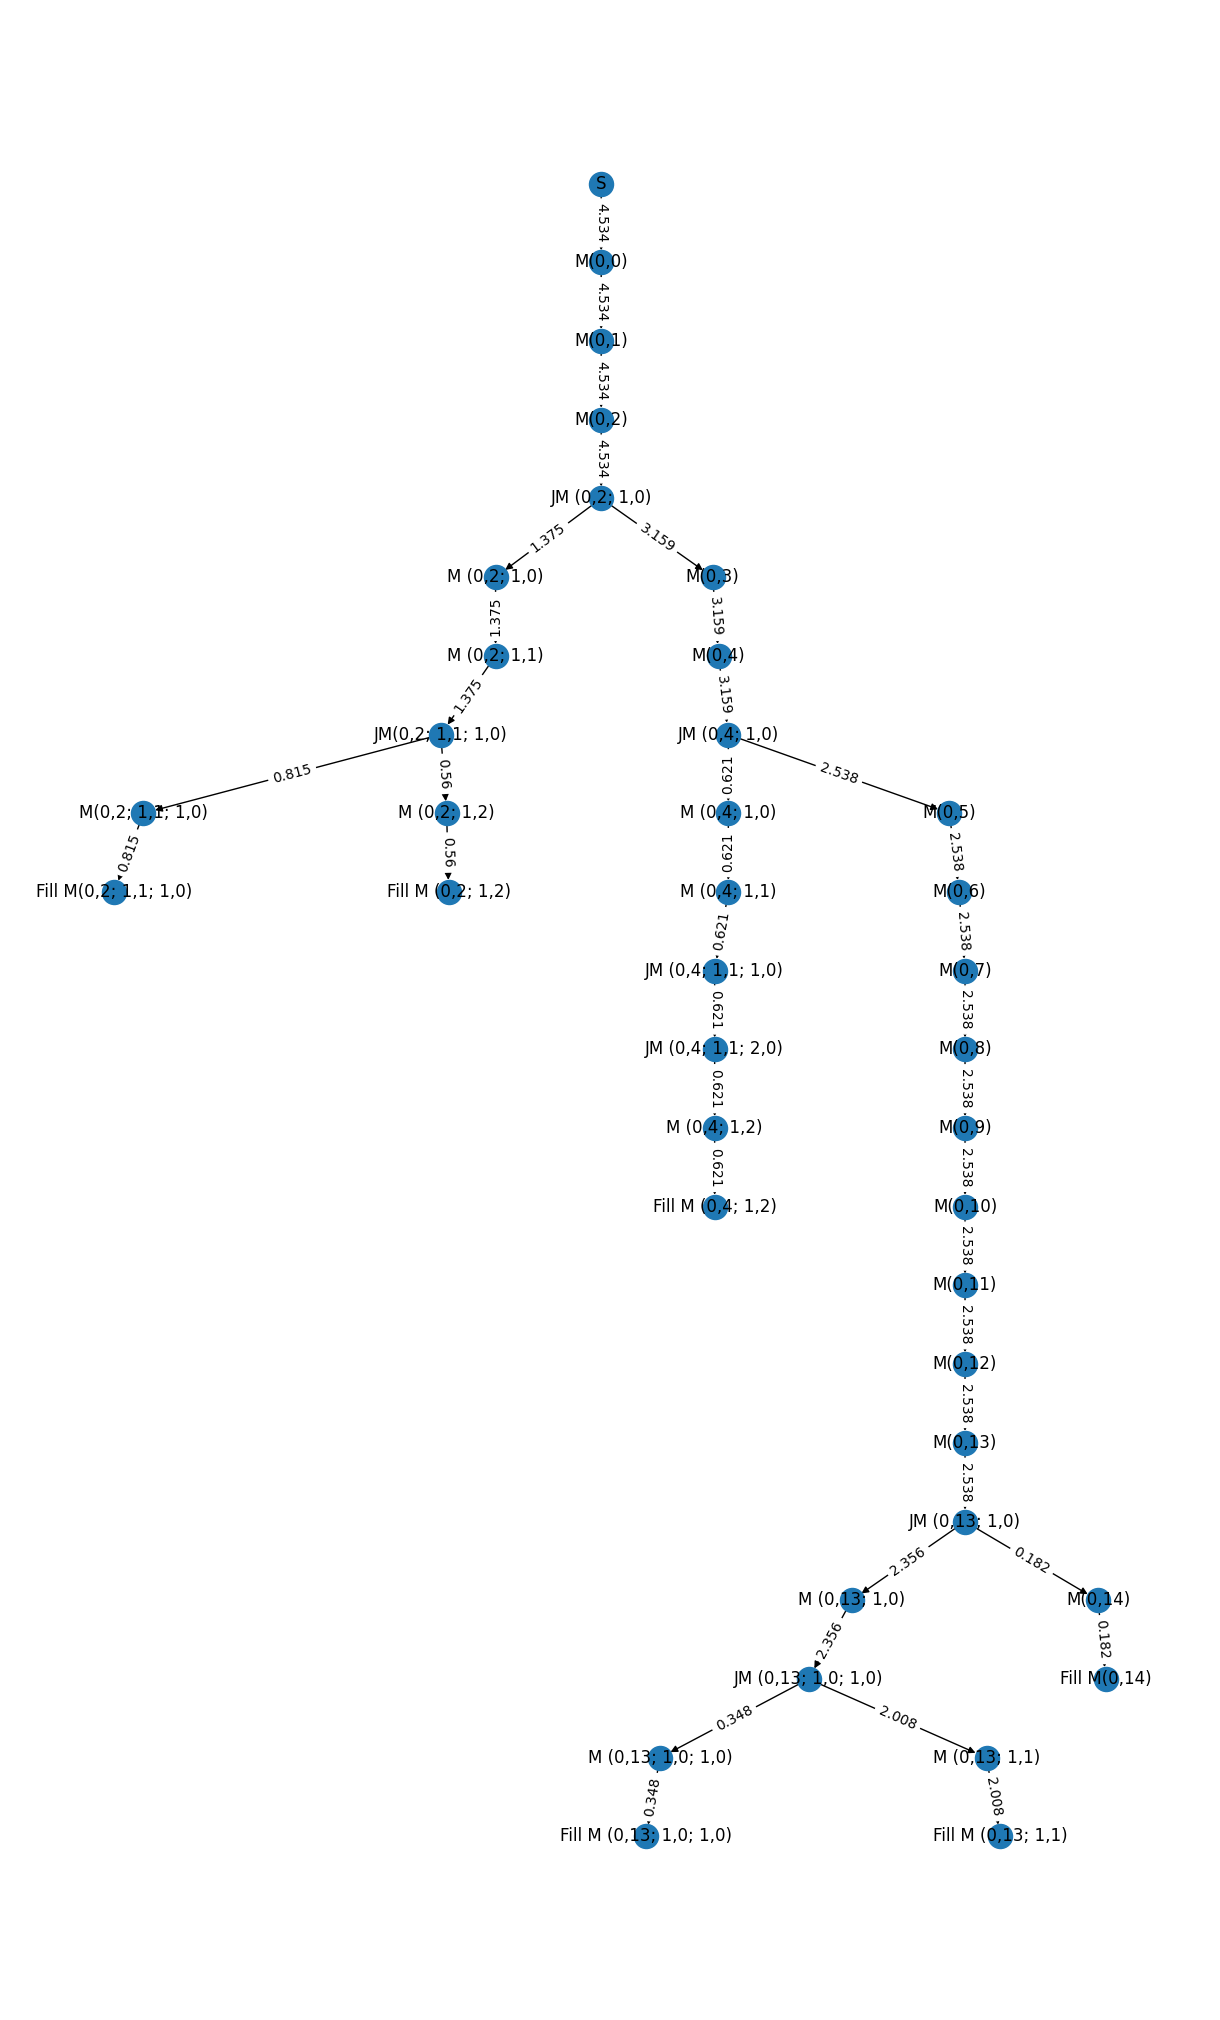


Step 18
166 mins
Fill Area:  M(0,14) 1813.0
Fill Area:  M(0,2; 1,1; 1,0) 8117.0
Fill Area:  M (0,2; 1,2) 5578.0
Fill Area:  M (0,4; 1,2) 6188.0
Fill Area:  M (0,13; 1,0; 1,0) 3466.0
Fill Area:  M (0,13; 1,1; 1,0) 12918.0
Fill Area:  M (0,13; 1,2) 7082.0


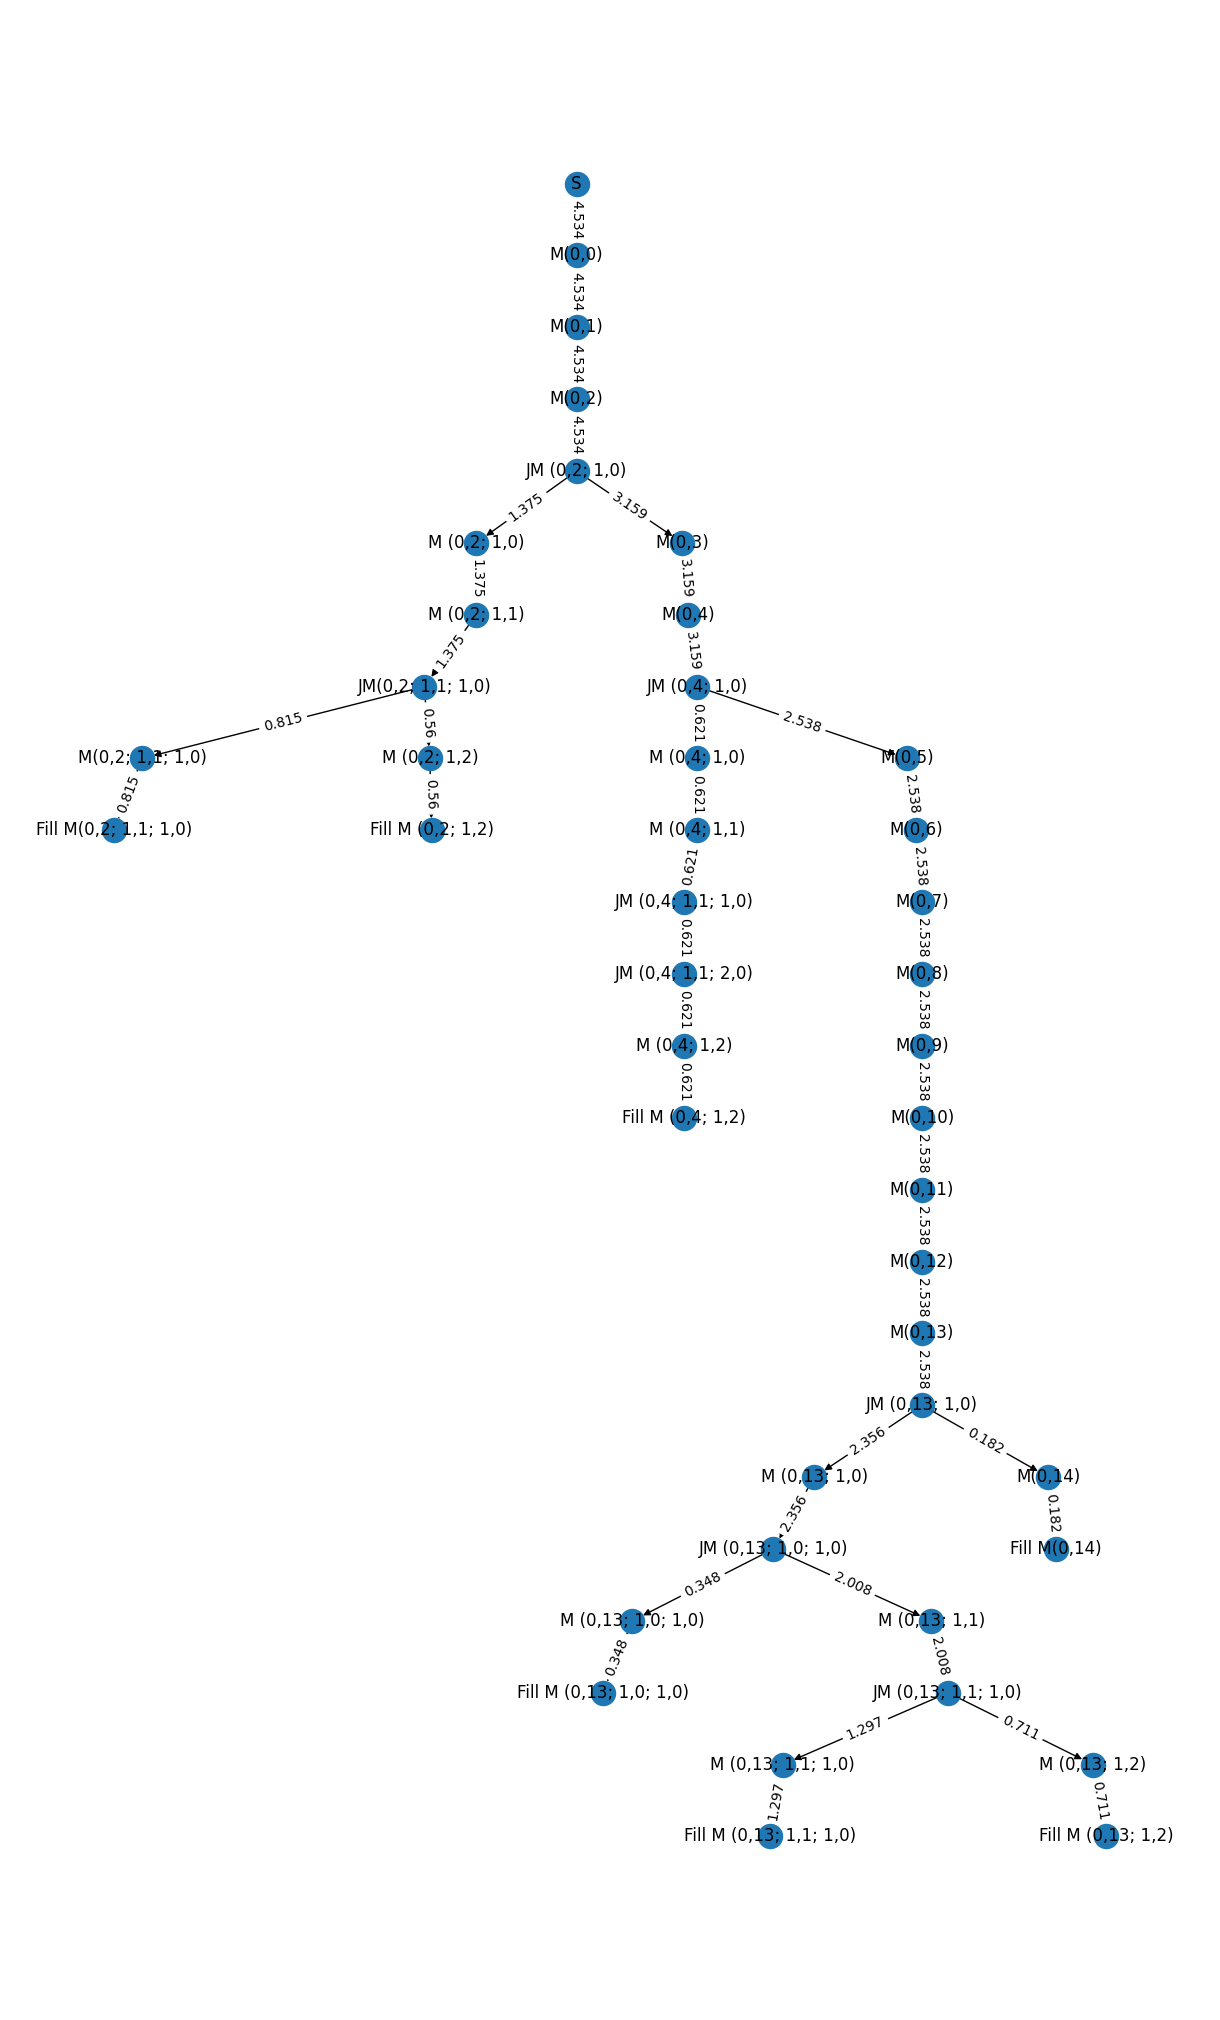


Step 19
132 mins
Fill Area:  M(0,14) 1441.0
Fill Area:  M(0,2; 1,1; 1,0) 6455.0
Fill Area:  M (0,2; 1,2) 4435.0
Fill Area:  M (0,4; 1,2) 4921.0
Fill Area:  M (0,13; 1,0; 1,0) 2756.0
Fill Area:  M (0,13; 1,2) 15262.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 642.0


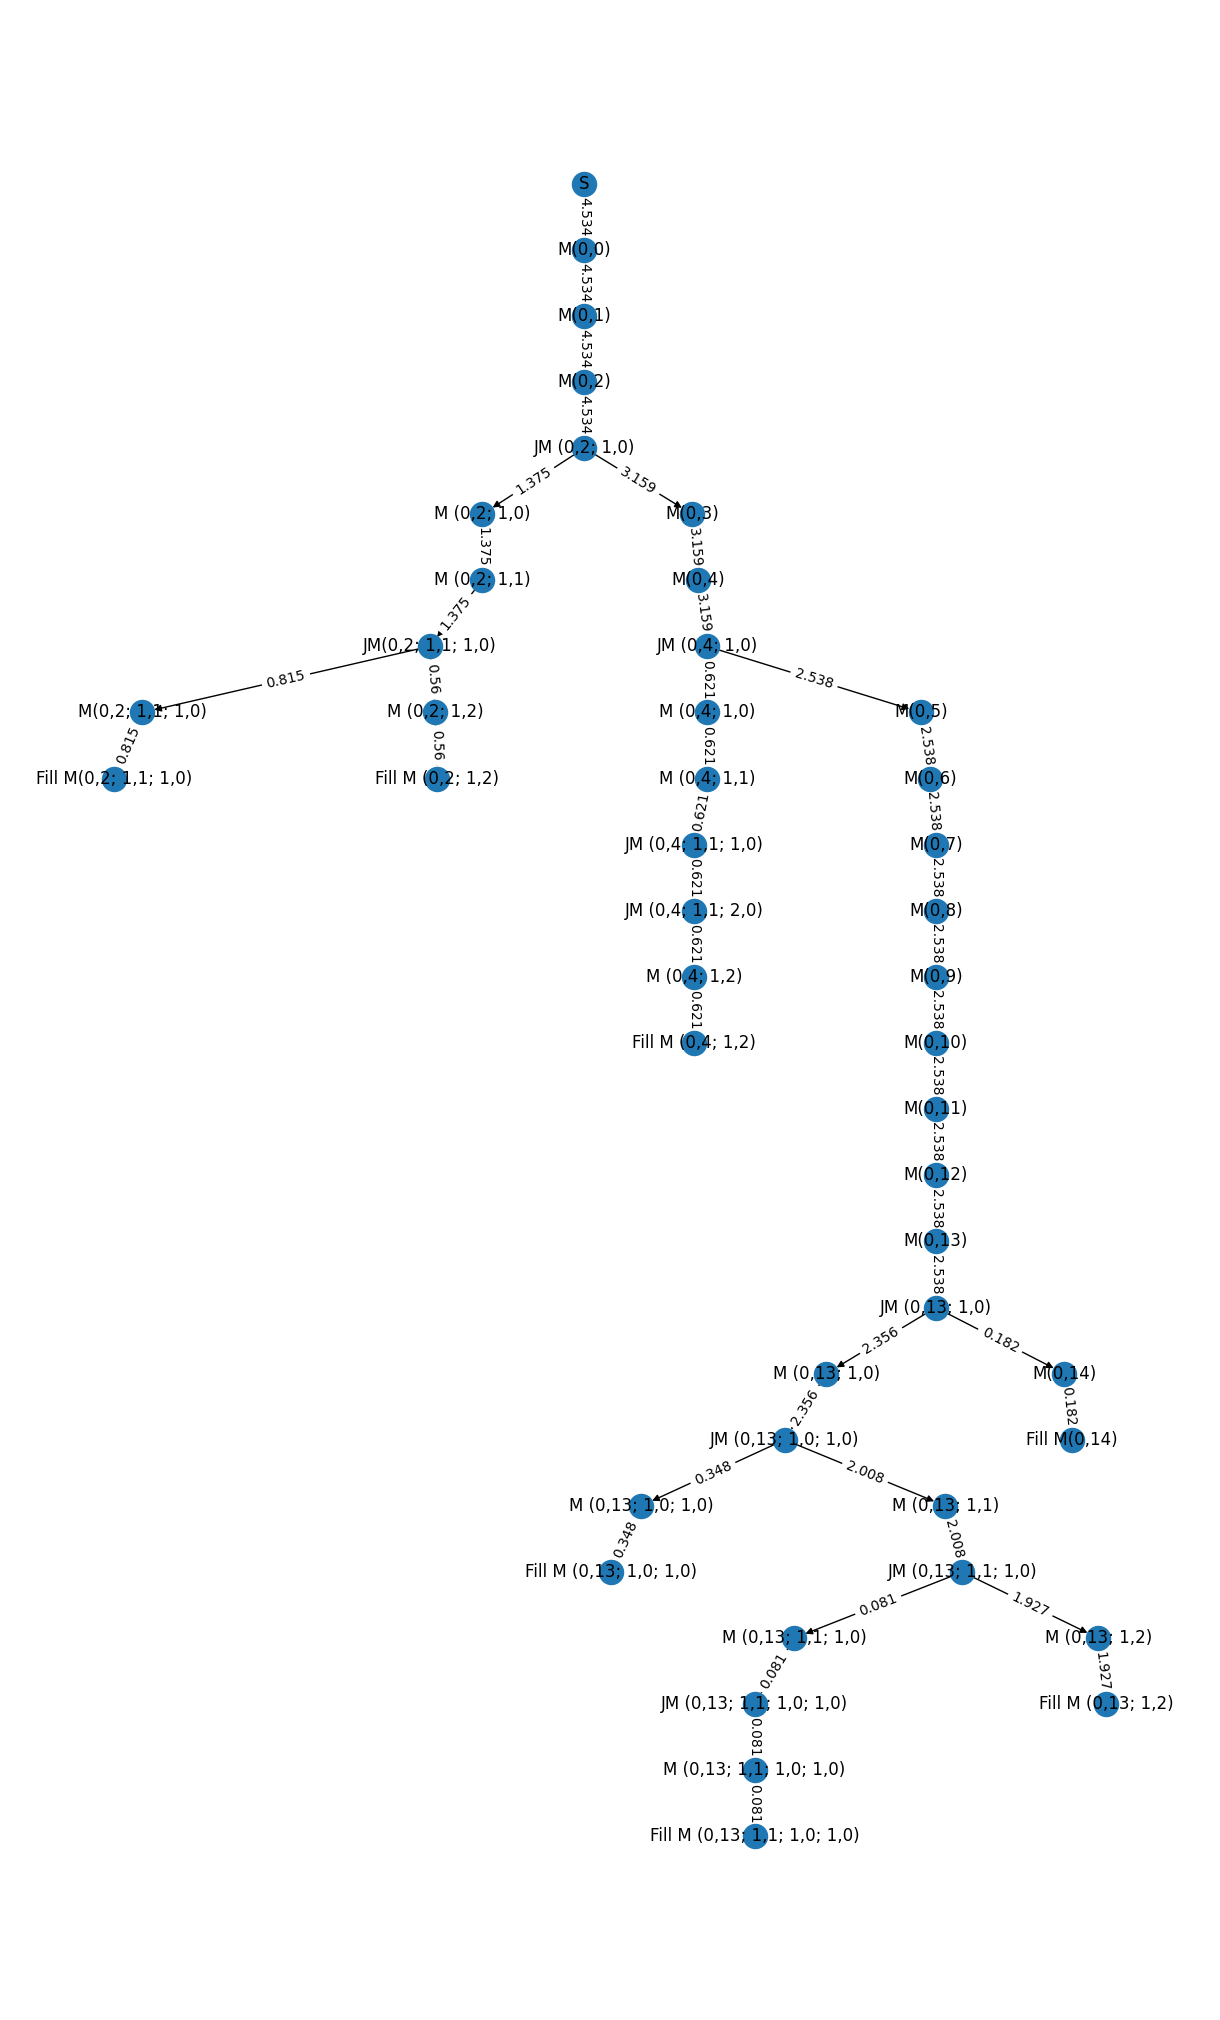


Step 20
674 mins
Fill Area:  M(0,14) 7360.0
Fill Area:  M(0,2; 1,1; 1,0) 32959.0
Fill Area:  M (0,2; 1,2) 22646.0
Fill Area:  M (0,4; 1,2) 25127.0
Fill Area:  M (0,13; 1,0; 1,0) 14073.0
Fill Area:  M (0,13; 1,2; 1,0) 26367.0
Fill Area:  M (0,13; 1,3) 4860.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 34232.0
Fill Area:  M (0,13; 1,1; 1,1) 15745.0


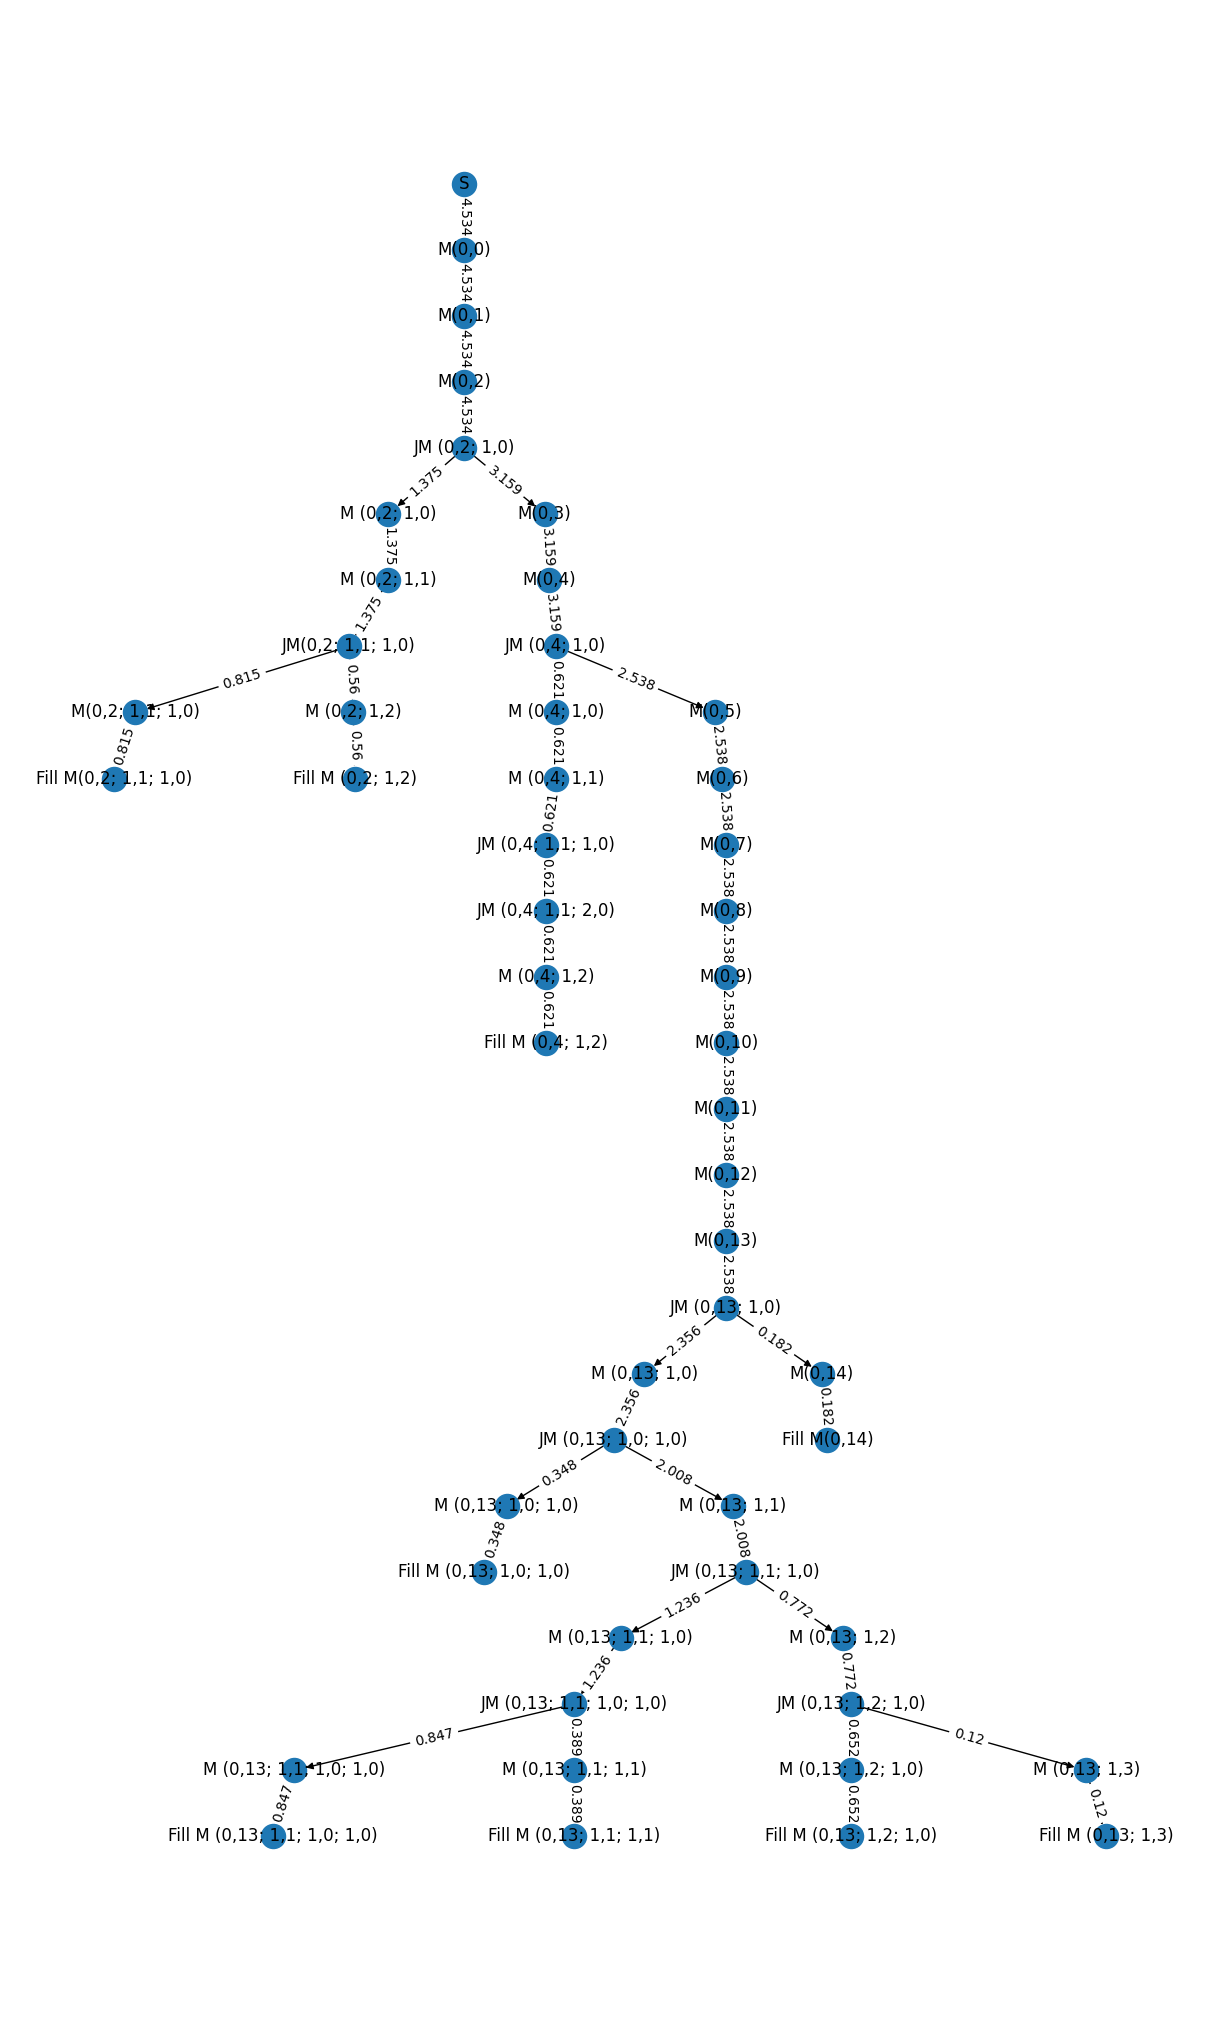


Step 21
349 mins
Fill Area:  M(0,14) 3811.0
Fill Area:  M (0,2; 1,2) 25840.0
Fill Area:  M(0,2; 1,1; 1,1) 2953.0
Fill Area:  M (0,4; 1,2) 13011.0
Fill Area:  M (0,13; 1,0; 1,0) 7287.0
Fill Area:  M (0,13; 1,2; 1,0) 13653.0
Fill Area:  M (0,13; 1,3) 2516.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 17726.0
Fill Area:  M (0,13; 1,1; 1,1) 8153.0


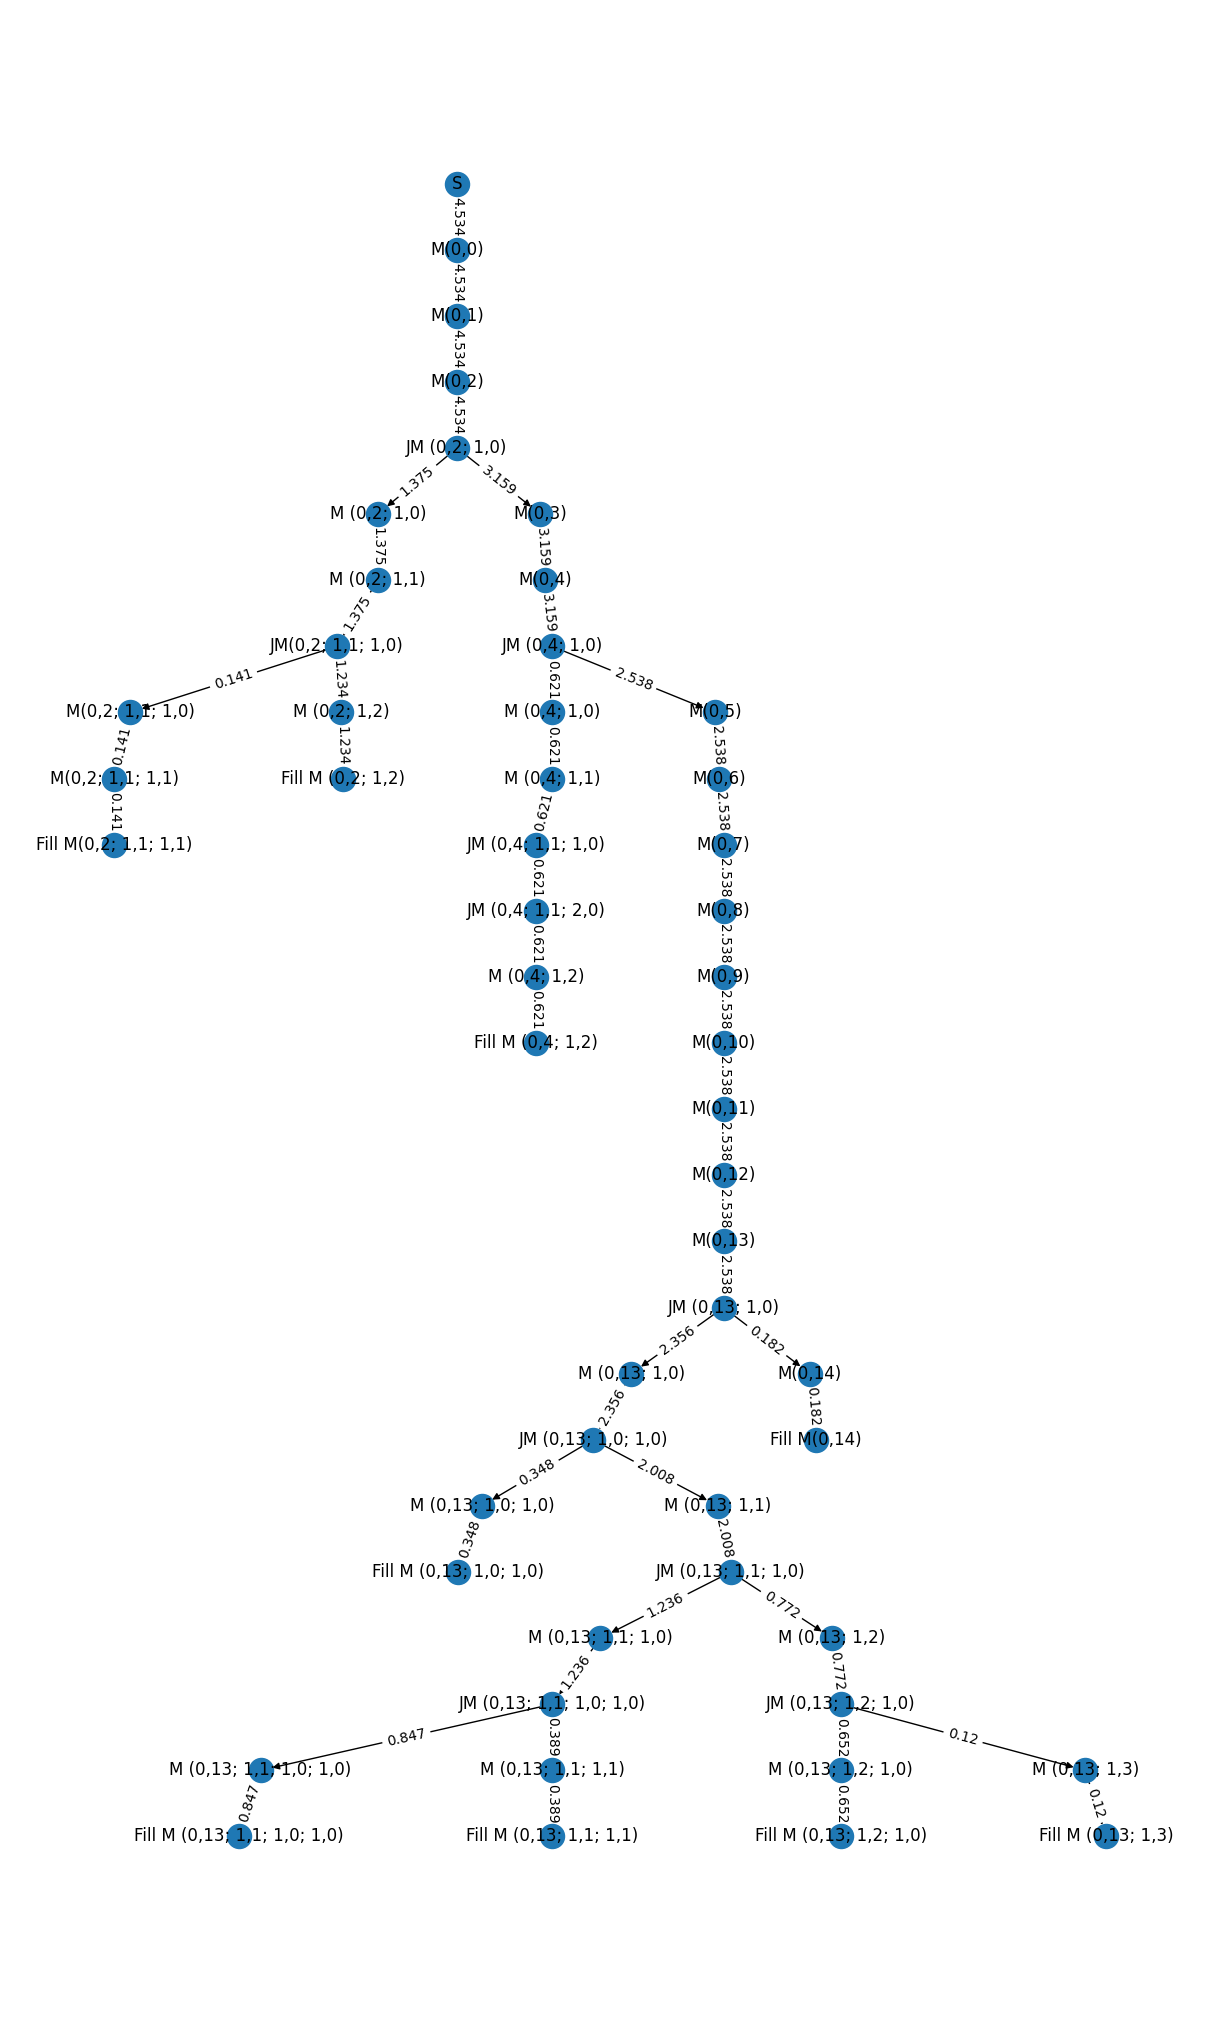


Step 22
854 mins
Fill Area:  M (0,2; 1,2) 63230.0
Fill Area:  M(0,2; 1,1; 1,1) 7225.0
Fill Area:  M (0,4; 1,2) 31837.0
Fill Area:  M (0,13; 1,0; 1,0) 17832.0
Fill Area:  M (0,13; 1,2; 1,0) 33408.0
Fill Area:  M (0,13; 1,3) 6157.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 43375.0
Fill Area:  M (0,13; 1,1; 1,1) 19949.0


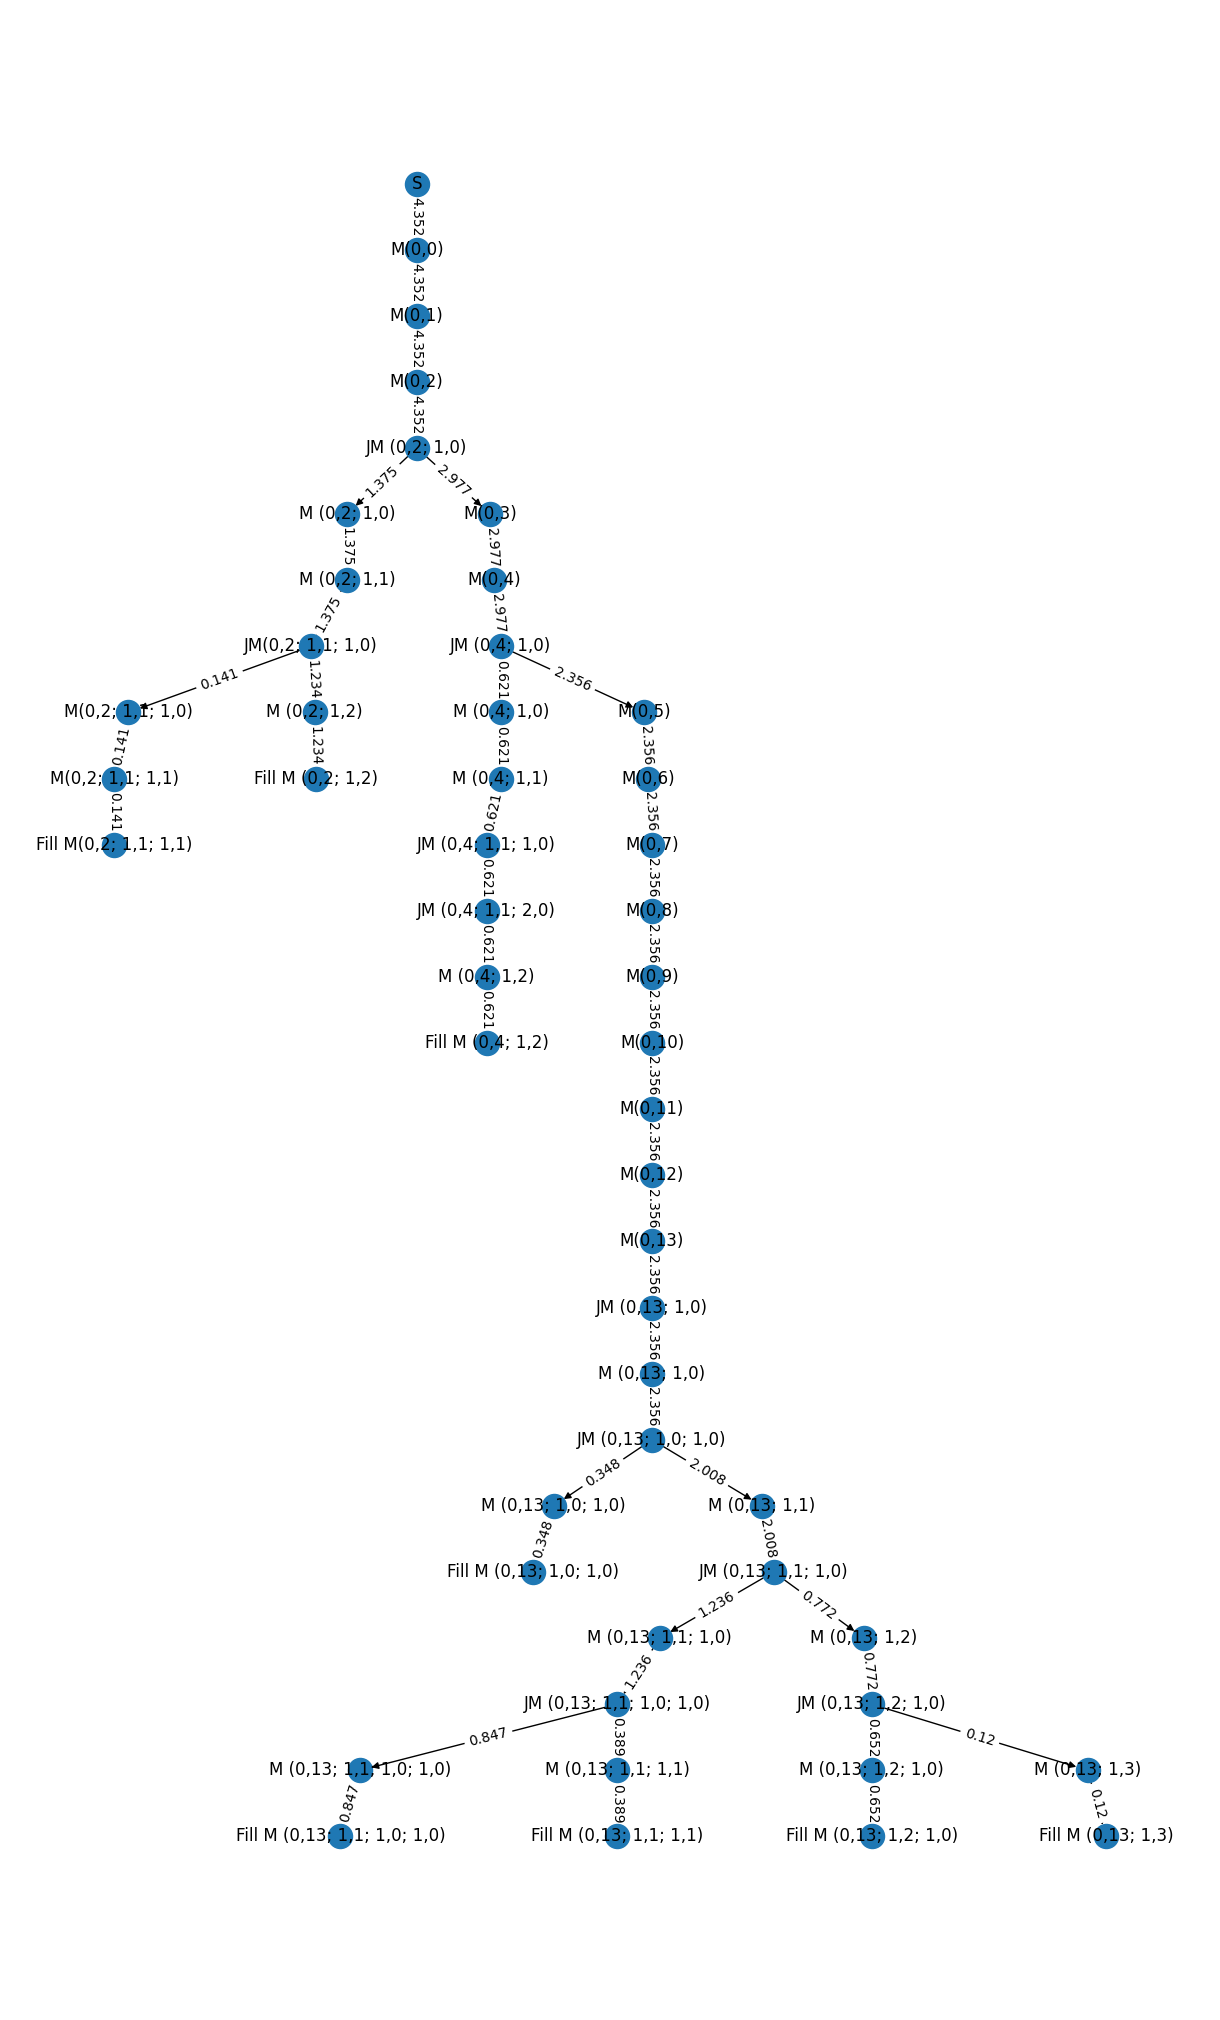


Step 23
600 mins
Fill Area:  M (0,2; 1,2) 44424.0
Fill Area:  M(0,2; 1,1; 1,1) 5076.0
Fill Area:  M (0,13; 1,0; 1,0) 12528.0
Fill Area:  M (0,13; 1,2; 1,0) 23472.0
Fill Area:  M (0,13; 1,3) 4326.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 30474.0
Fill Area:  M (0,13; 1,1; 1,1) 14016.0


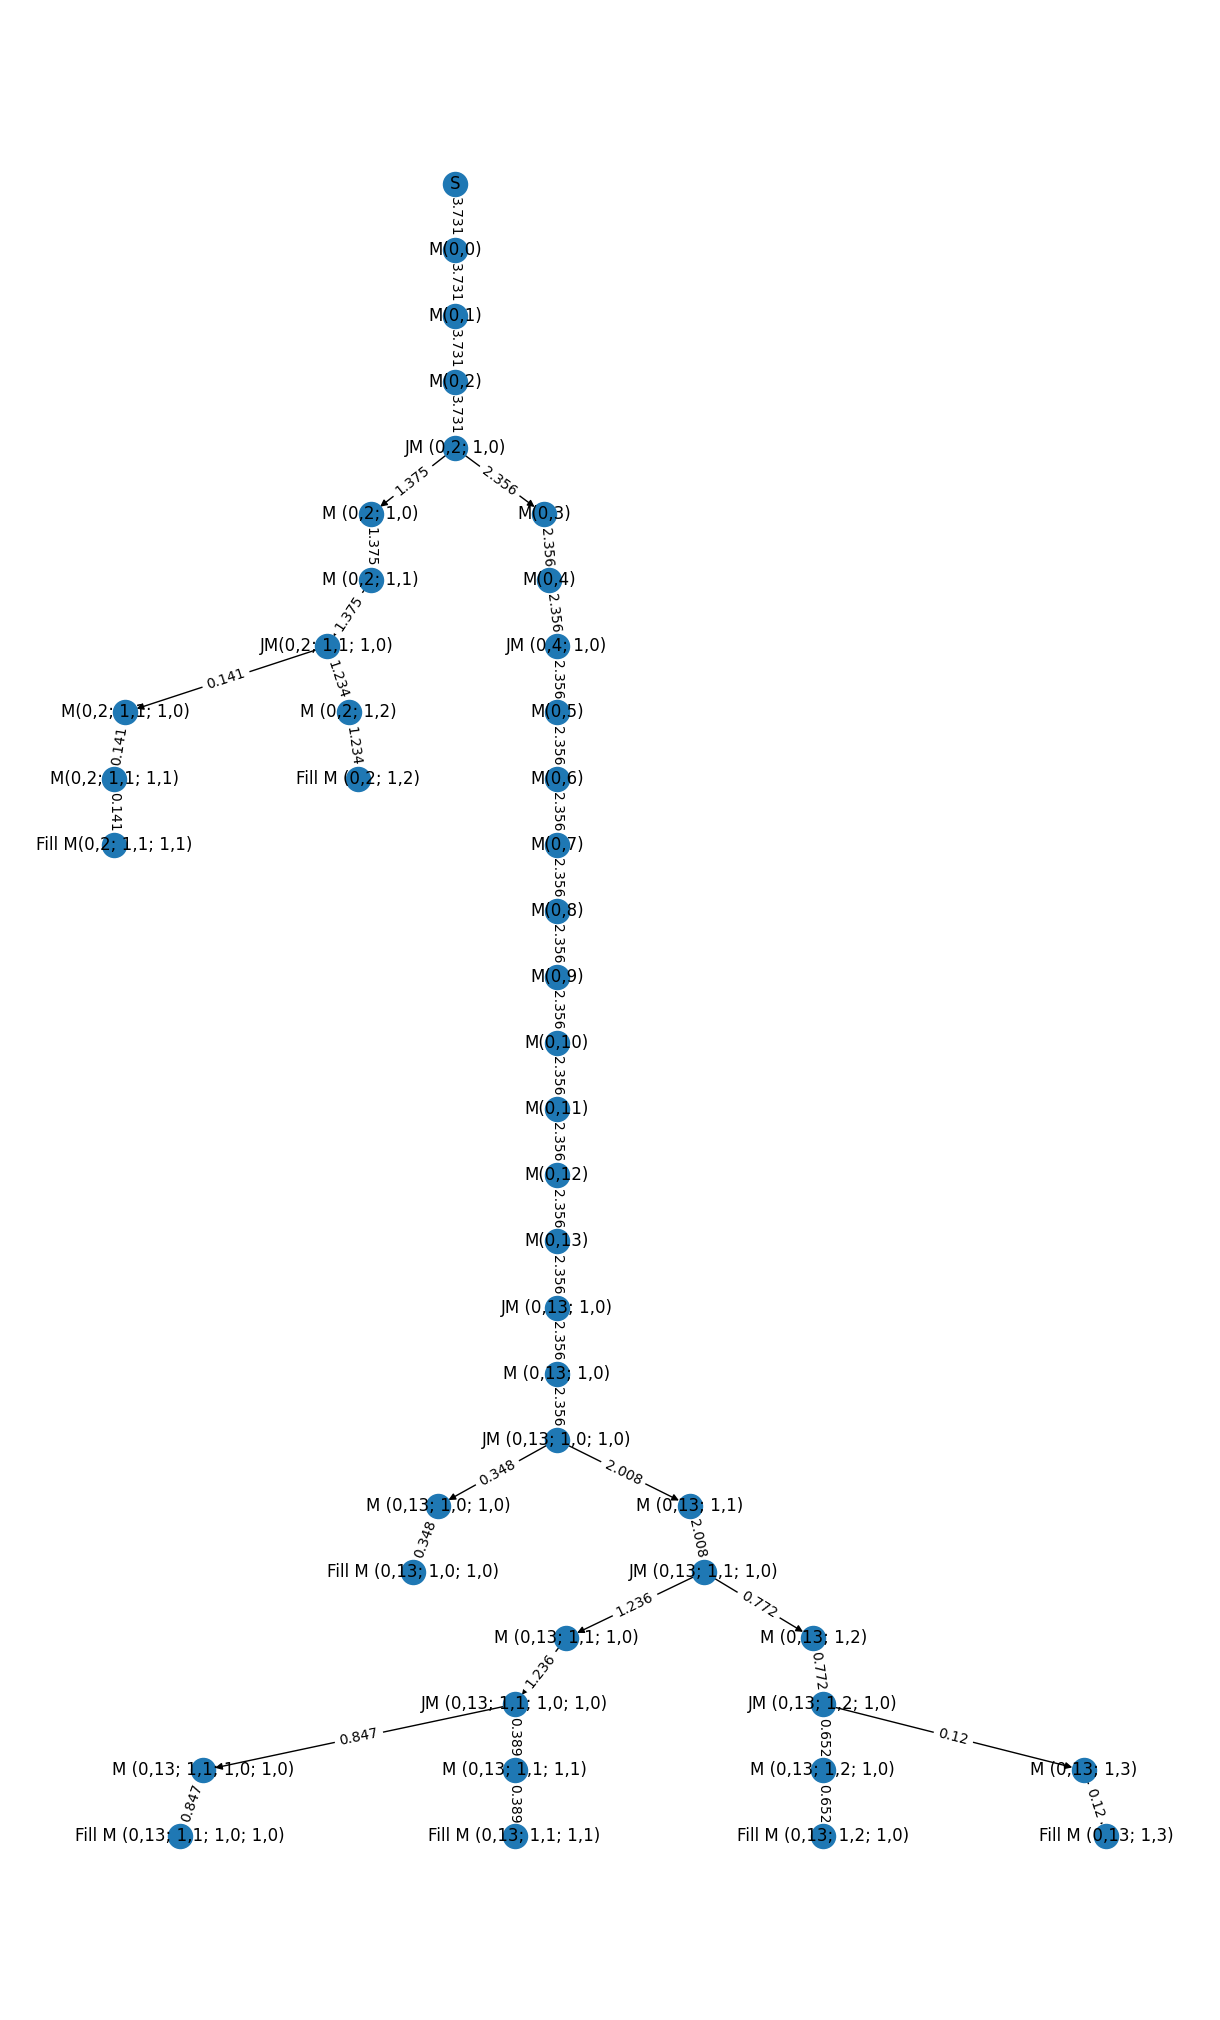


Step 24
1042 mins
Fill Area:  M (0,2; 1,2) 77150.0
Fill Area:  M(0,2; 1,1; 1,1) 8815.0
Fill Area:  M (0,13; 1,0; 1,0) 21757.0
Fill Area:  M (0,13; 1,3) 48276.0
Fill Area:  M (0,13; 1,1; 1,0; 1,0) 52923.0
Fill Area:  M (0,13; 1,1; 1,1) 24341.0


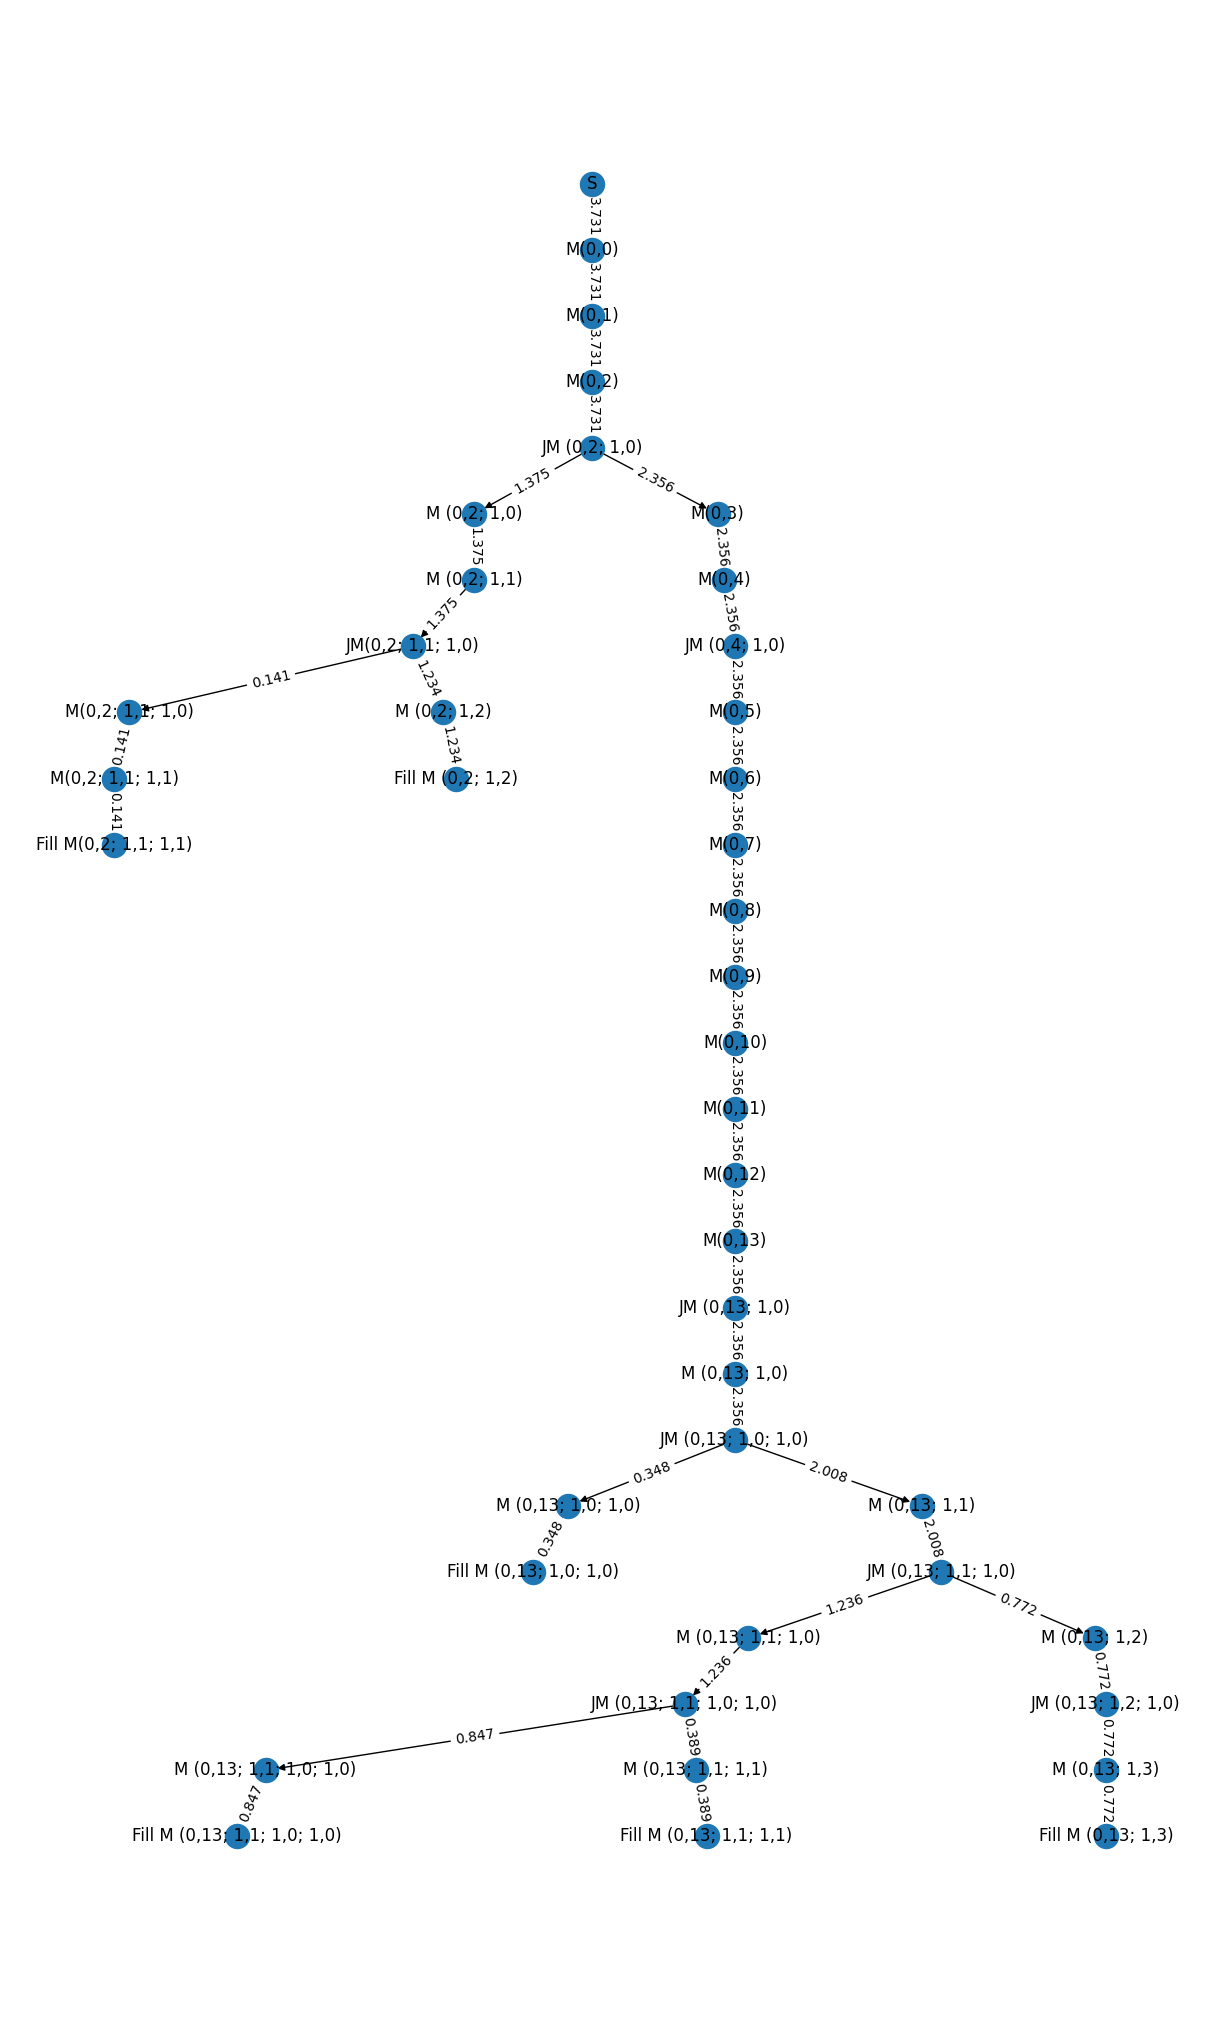


Step 25
1016 mins
Fill Area:  M (0,2; 1,2) 75225.0
Fill Area:  M(0,2; 1,1; 1,1) 8595.0
Fill Area:  M (0,13; 1,0; 1,0) 21214.0
Fill Area:  M (0,13; 1,3) 67178.0
Fill Area:  M (0,13; 1,1; 1,1) 23734.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 21966.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 9530.0


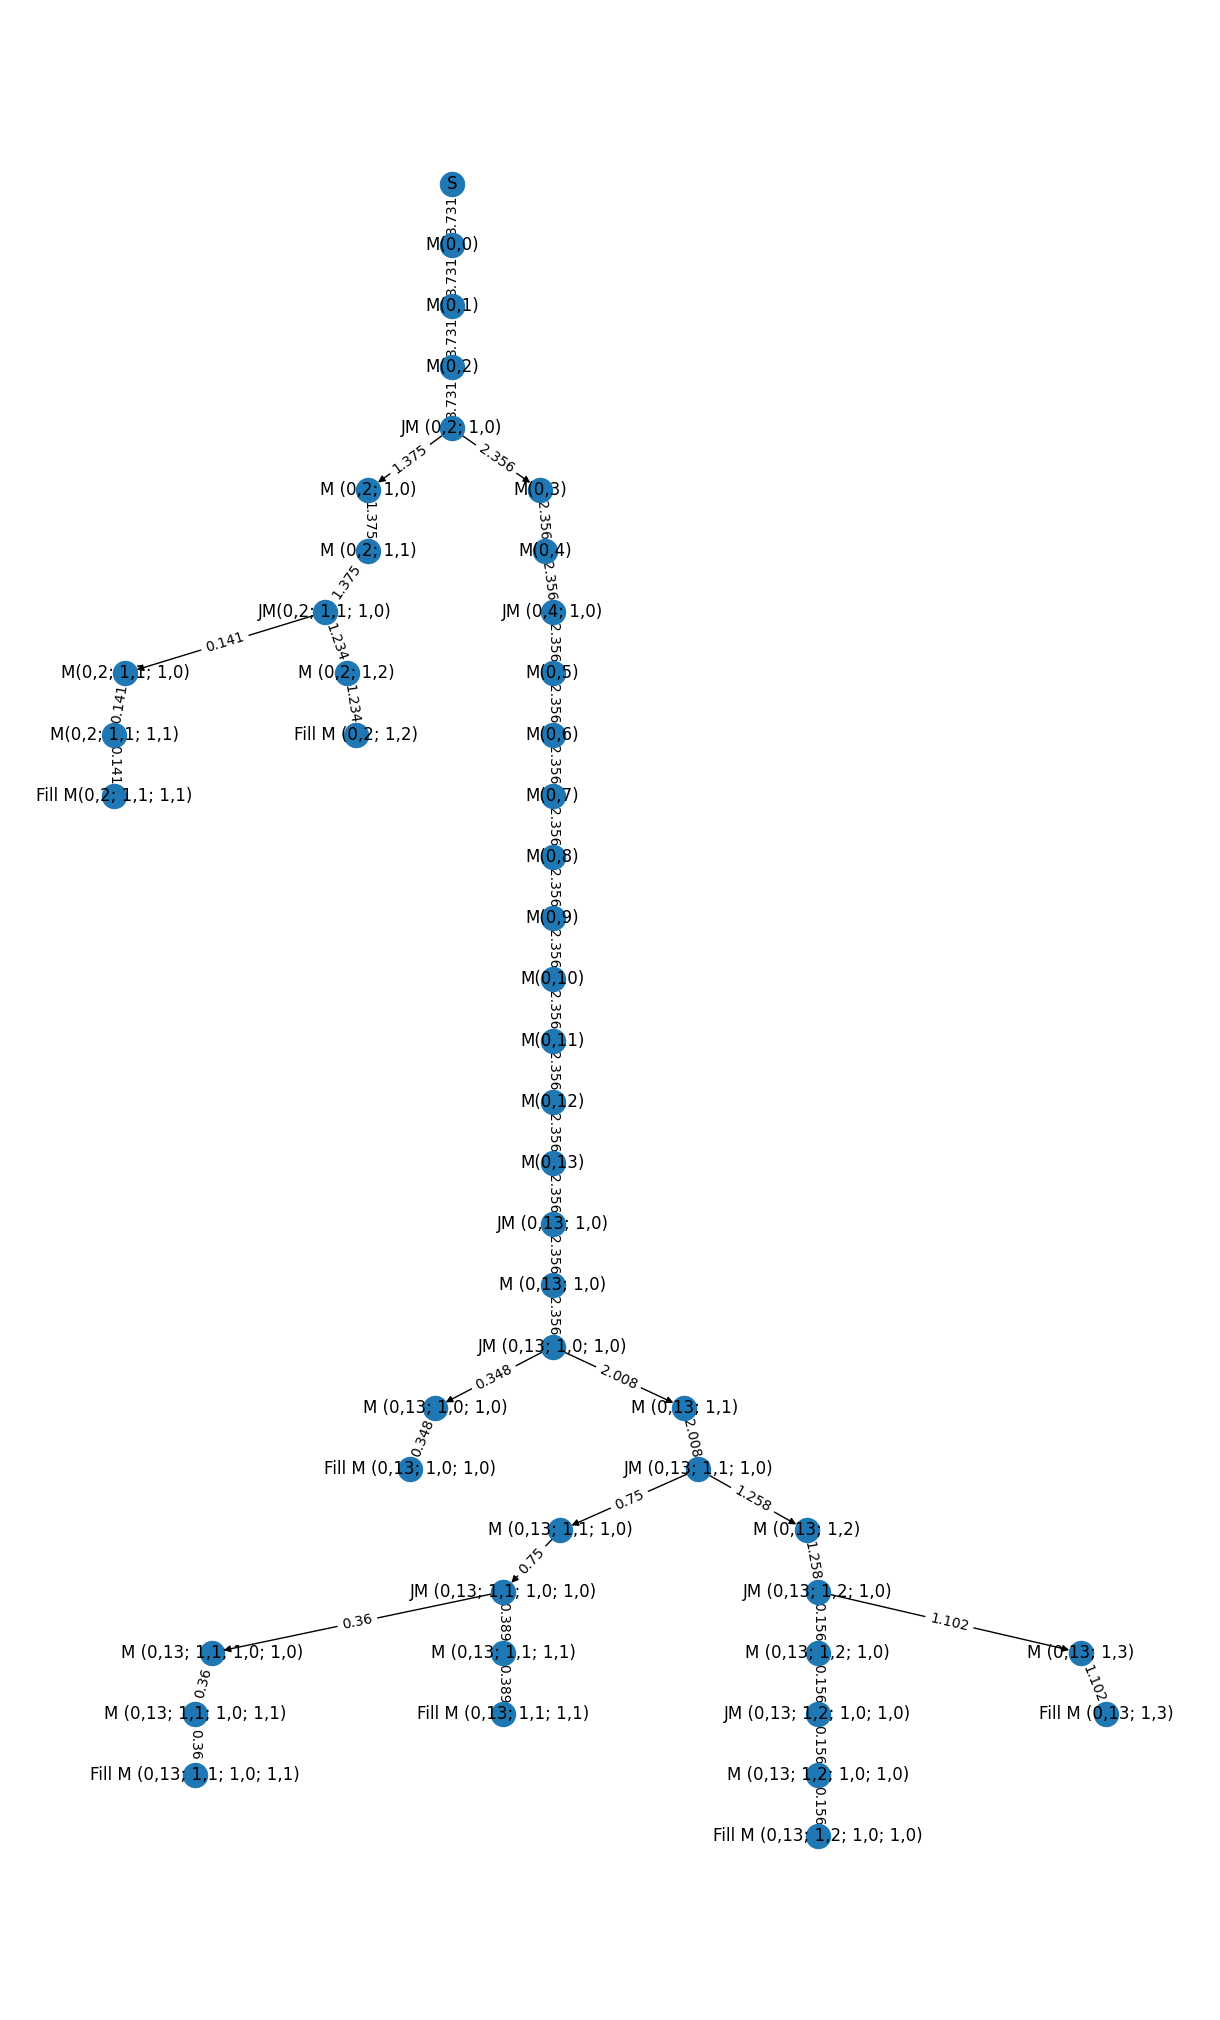


Step 26
25 mins
Fill Area:  M (0,2; 1,2) 1851.0
Fill Area:  M(0,2; 1,1; 1,1) 212.0
Fill Area:  M (0,13; 1,0; 1,0) 522.0
Fill Area:  M (0,13; 1,3; 1,0) 477.0
Fill Area:  M (0,13; 1,4) 514.0
Fill Area:  M (0,13; 1,1; 1,1) 584.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 541.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 308.0
Fill Area:  M (0,13; 1,2; 1,1) 589.0


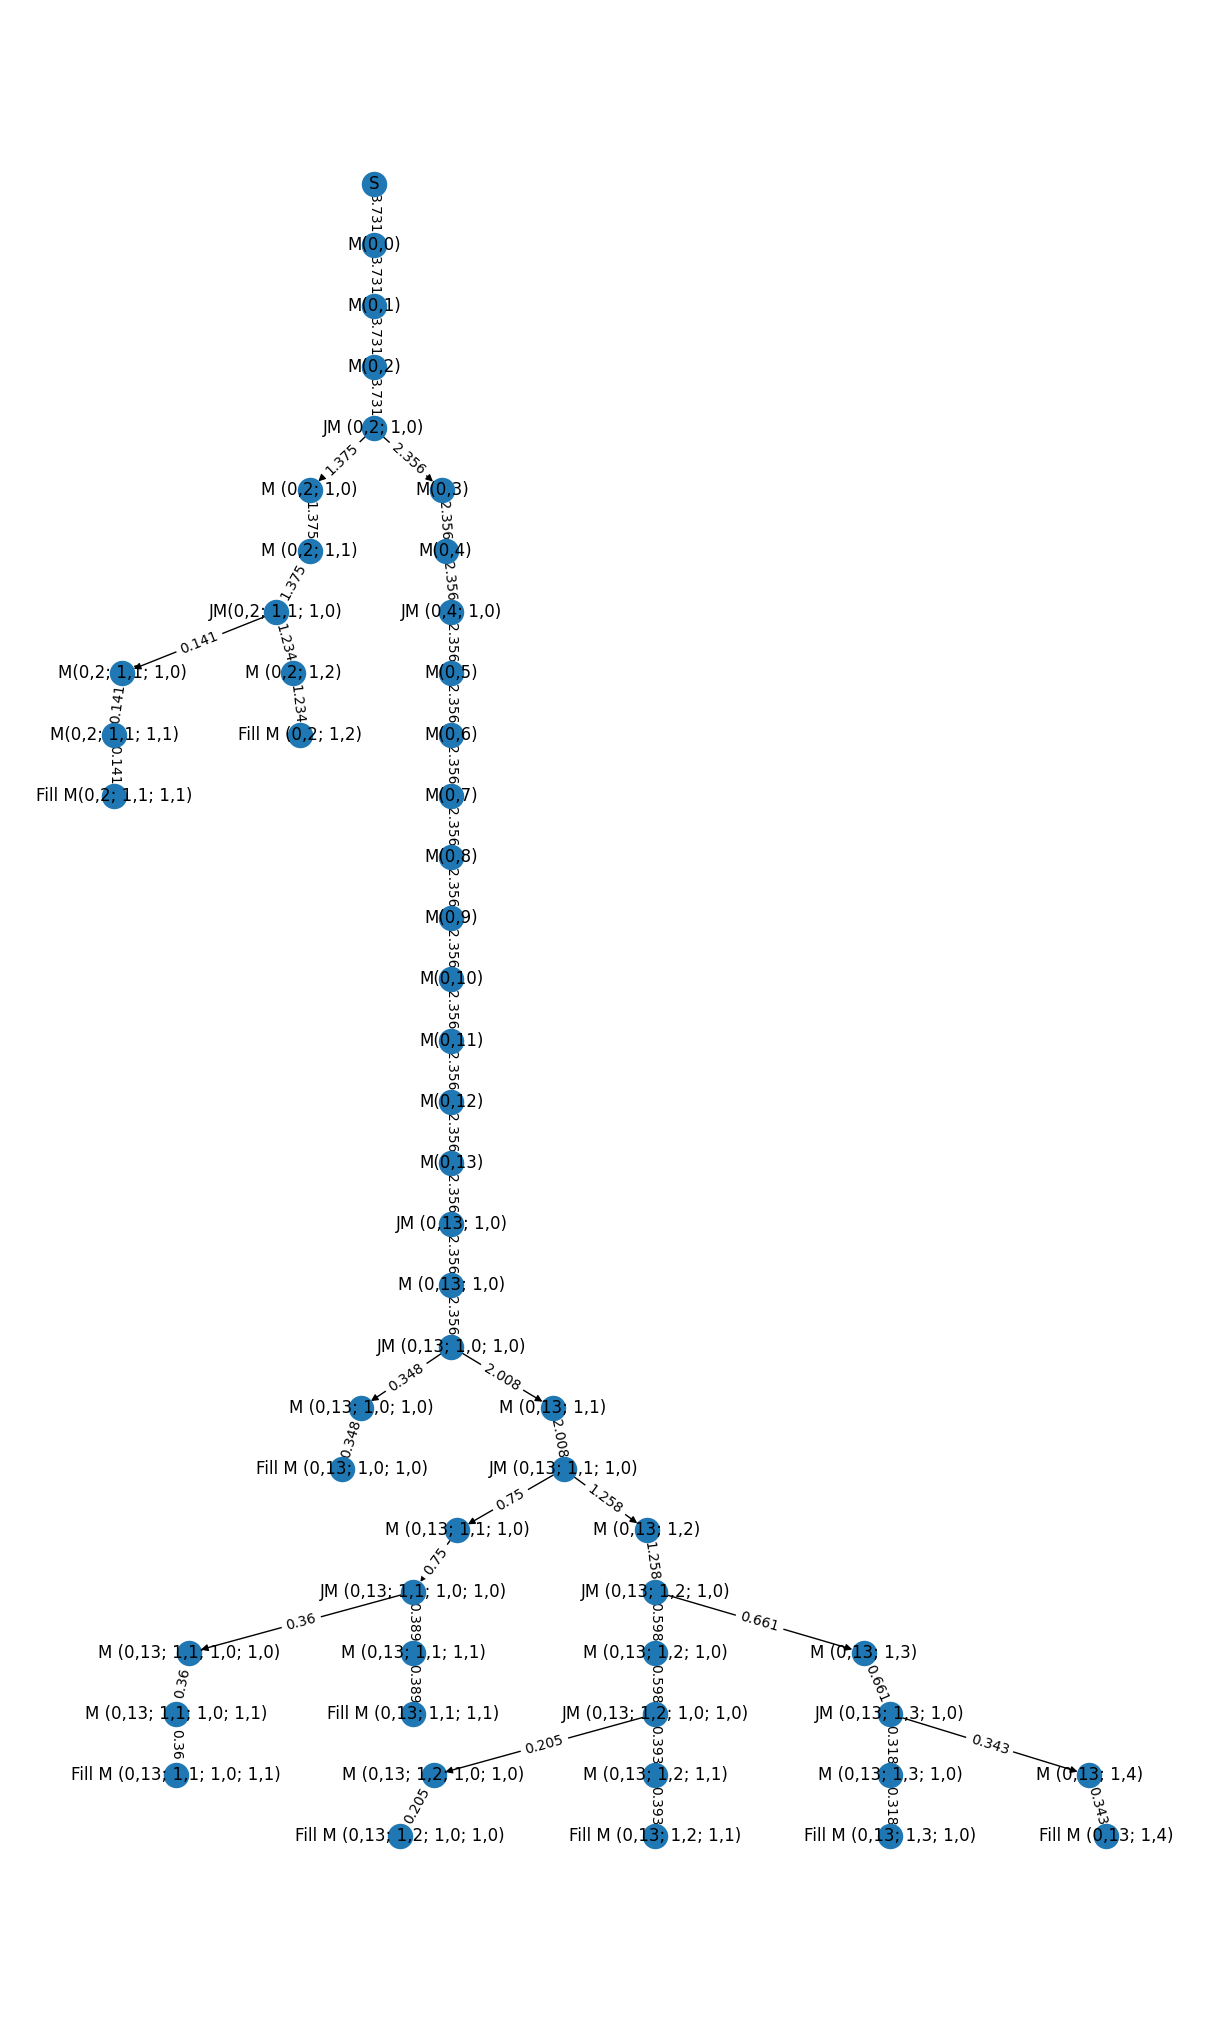


Step 27
1307 mins
Fill Area:  M(0,2; 1,1; 1,1) 31133.0
Fill Area:  M (0,13; 1,0; 1,0) 27290.0
Fill Area:  M (0,13; 1,3; 1,0) 24938.0
Fill Area:  M (0,13; 1,4) 26872.0
Fill Area:  M (0,13; 1,1; 1,1) 30532.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 28257.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 16076.0
Fill Area:  M (0,13; 1,2; 1,1) 30793.0


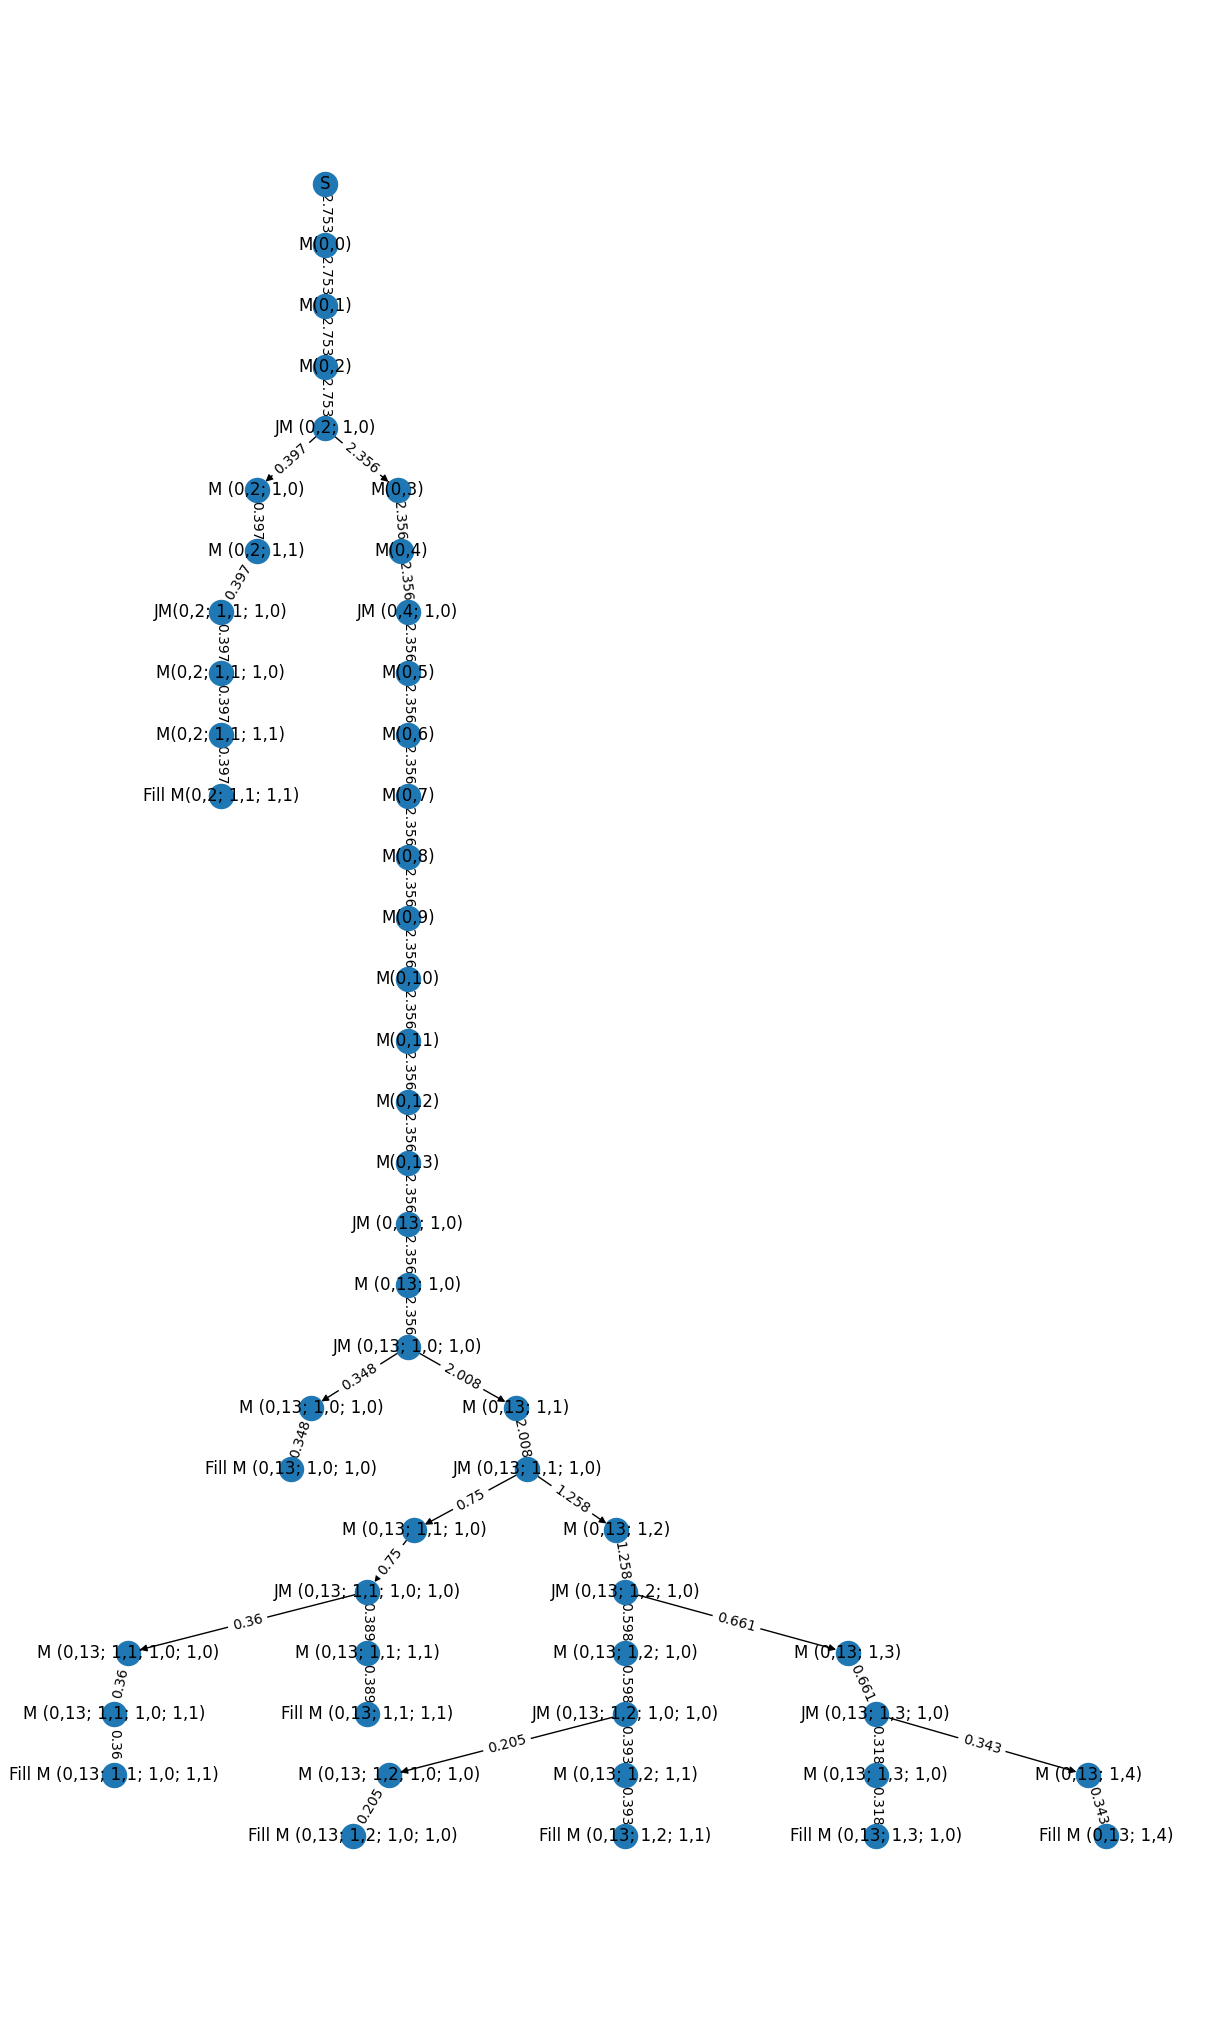


Step 28
534 mins
Fill Area:  M(0,2; 1,1; 1,2) 6568.0
Fill Area:  M (0,13; 1,0; 1,0) 11150.0
Fill Area:  M (0,13; 1,3; 1,0) 10189.0
Fill Area:  M (0,13; 1,4) 10979.0
Fill Area:  M (0,13; 1,1; 1,1) 12474.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 11545.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 6568.0
Fill Area:  M (0,13; 1,2; 1,1) 12581.0


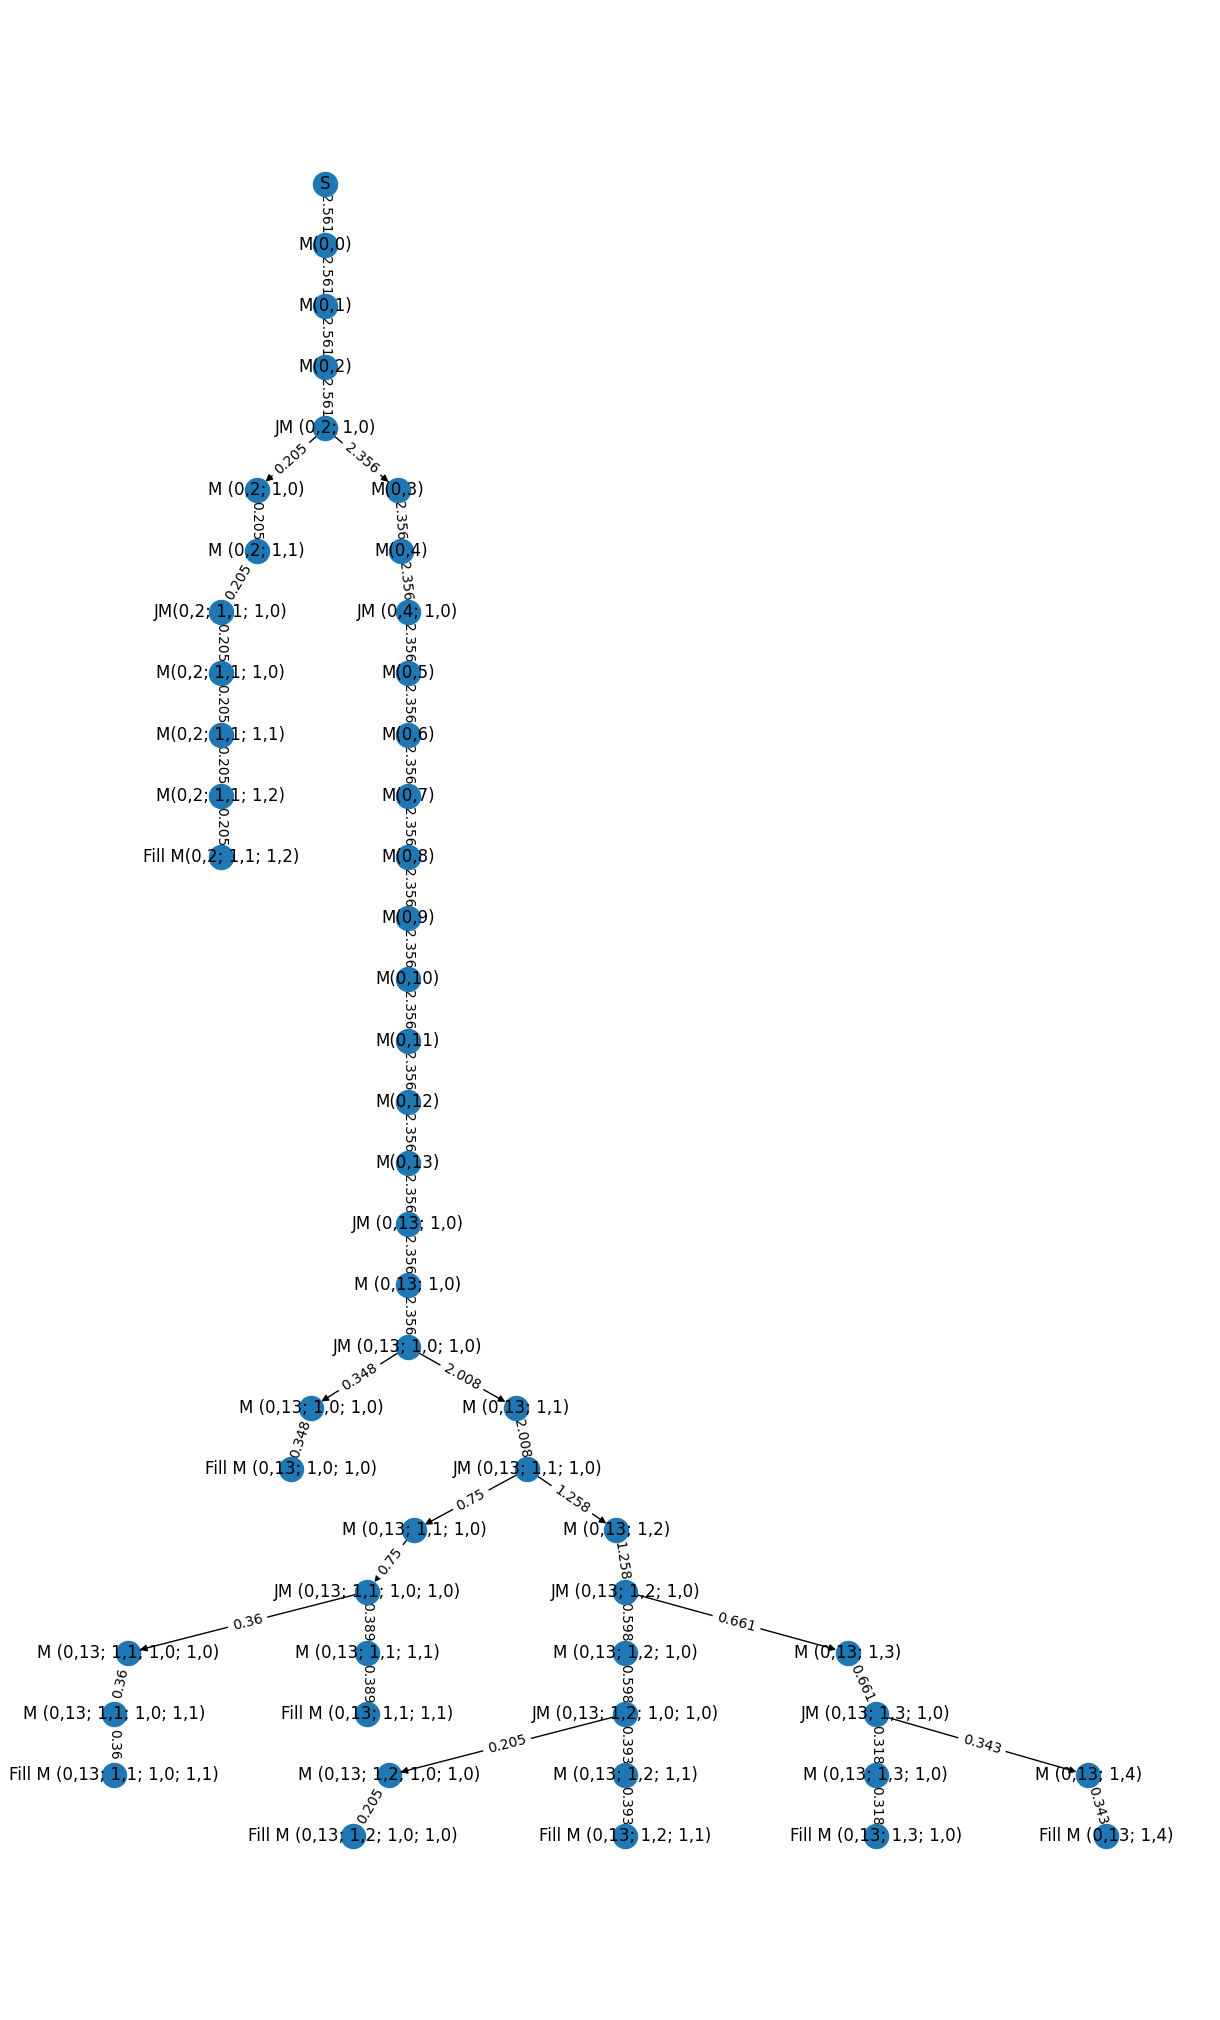


Step 29
1345 mins
Fill Area:  M(0,2; 1,1; 1,2; 1,0) 16544.0
Fill Area:  M (0,13; 1,0; 1,0) 28084.0
Fill Area:  M (0,13; 1,3; 1,0) 25663.0
Fill Area:  M (0,13; 1,4) 27653.0
Fill Area:  M (0,13; 1,1; 1,1) 31419.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 29079.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 16544.0
Fill Area:  M (0,13; 1,2; 1,1) 31688.0


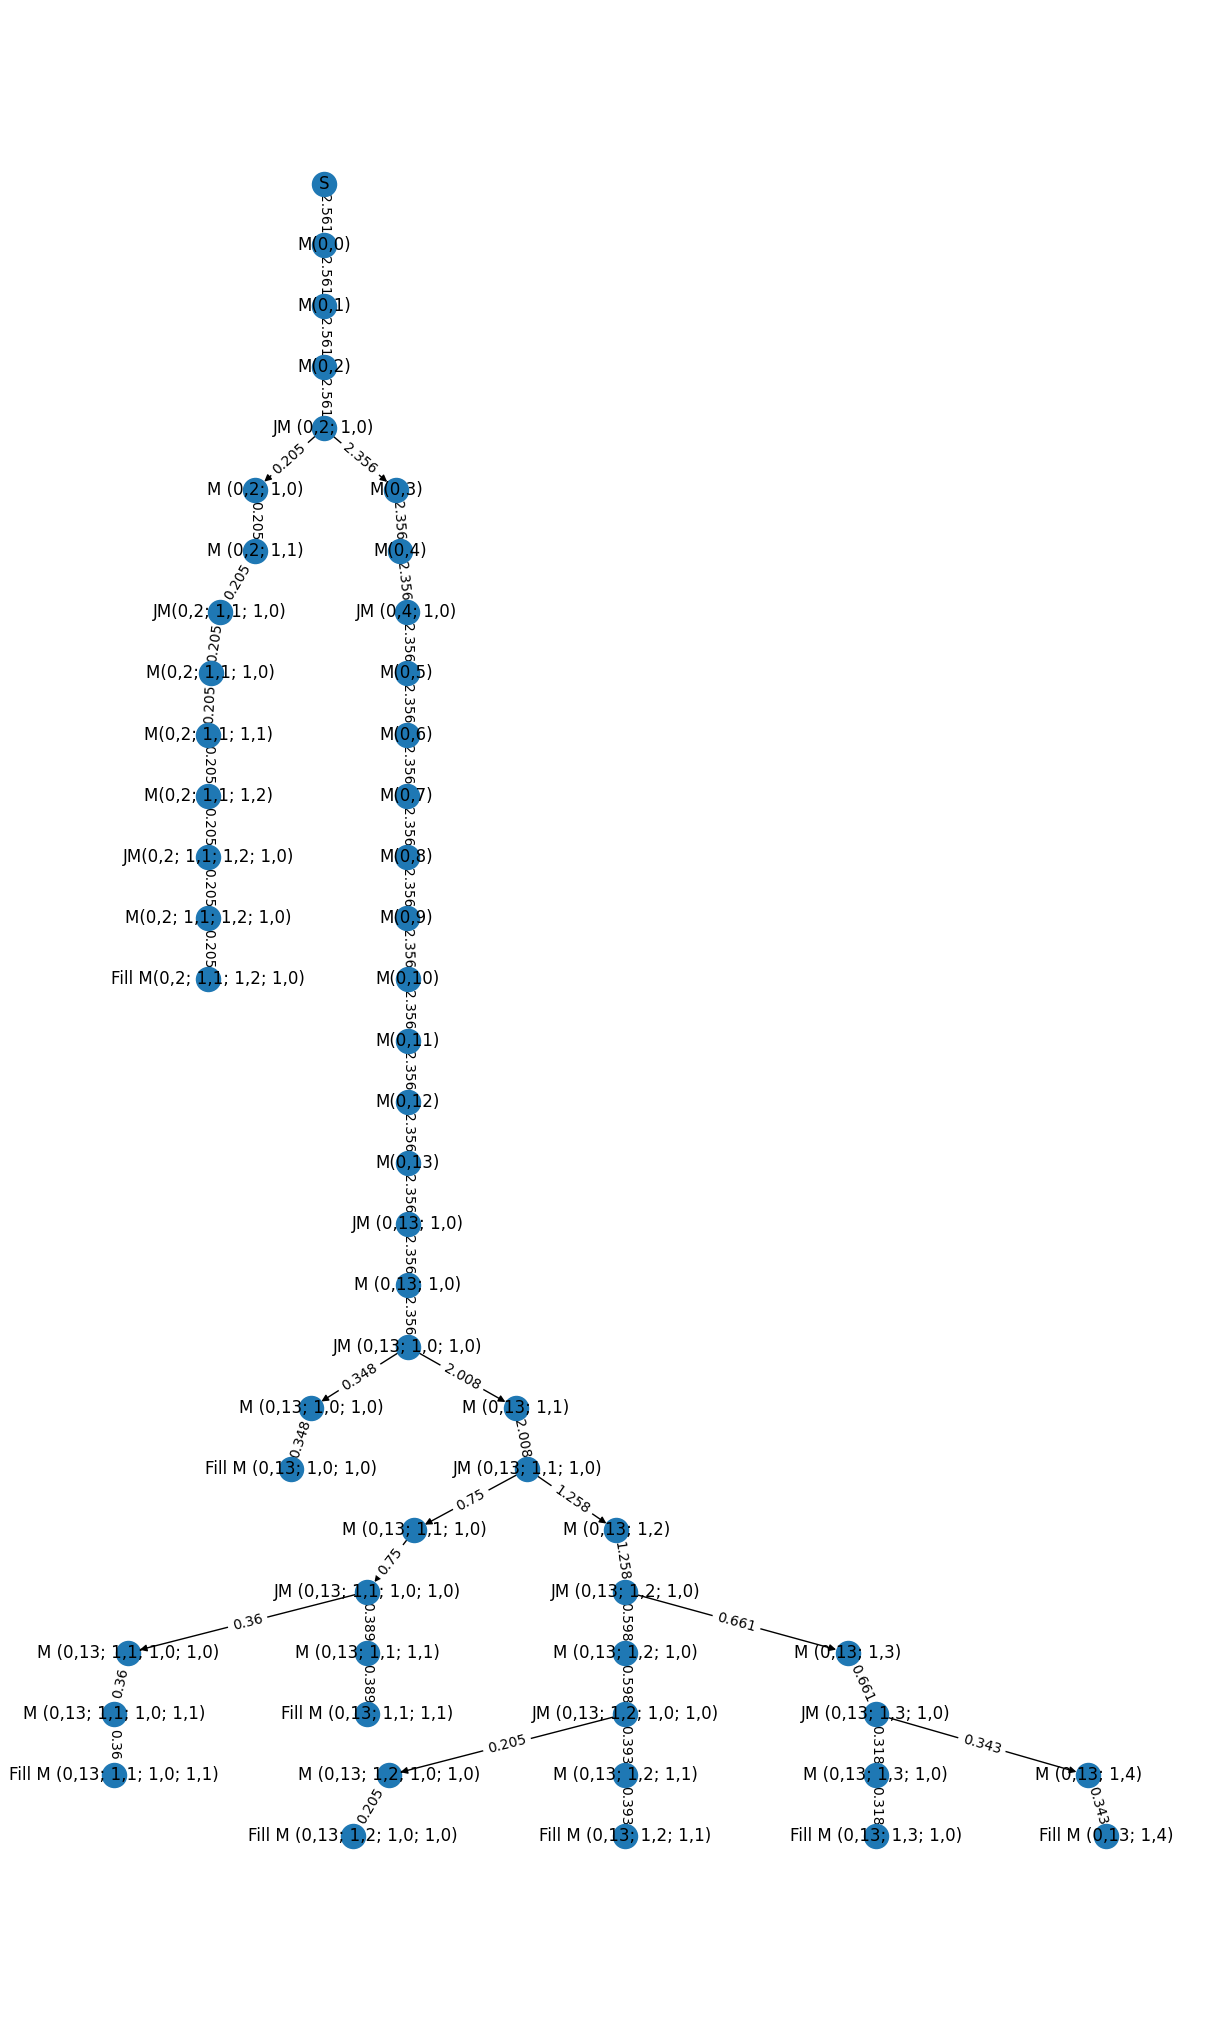


Step 30
1918 mins
Fill Area:  M(0,2; 1,1; 1,2; 1,0) 23591.0
Fill Area:  M (0,13; 1,0; 1,0) 40048.0
Fill Area:  M (0,13; 1,3; 1,0) 36595.0
Fill Area:  M (0,13; 1,4) 77104.0
Fill Area:  M (0,13; 1,1; 1,1) 44804.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 41467.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 23591.0


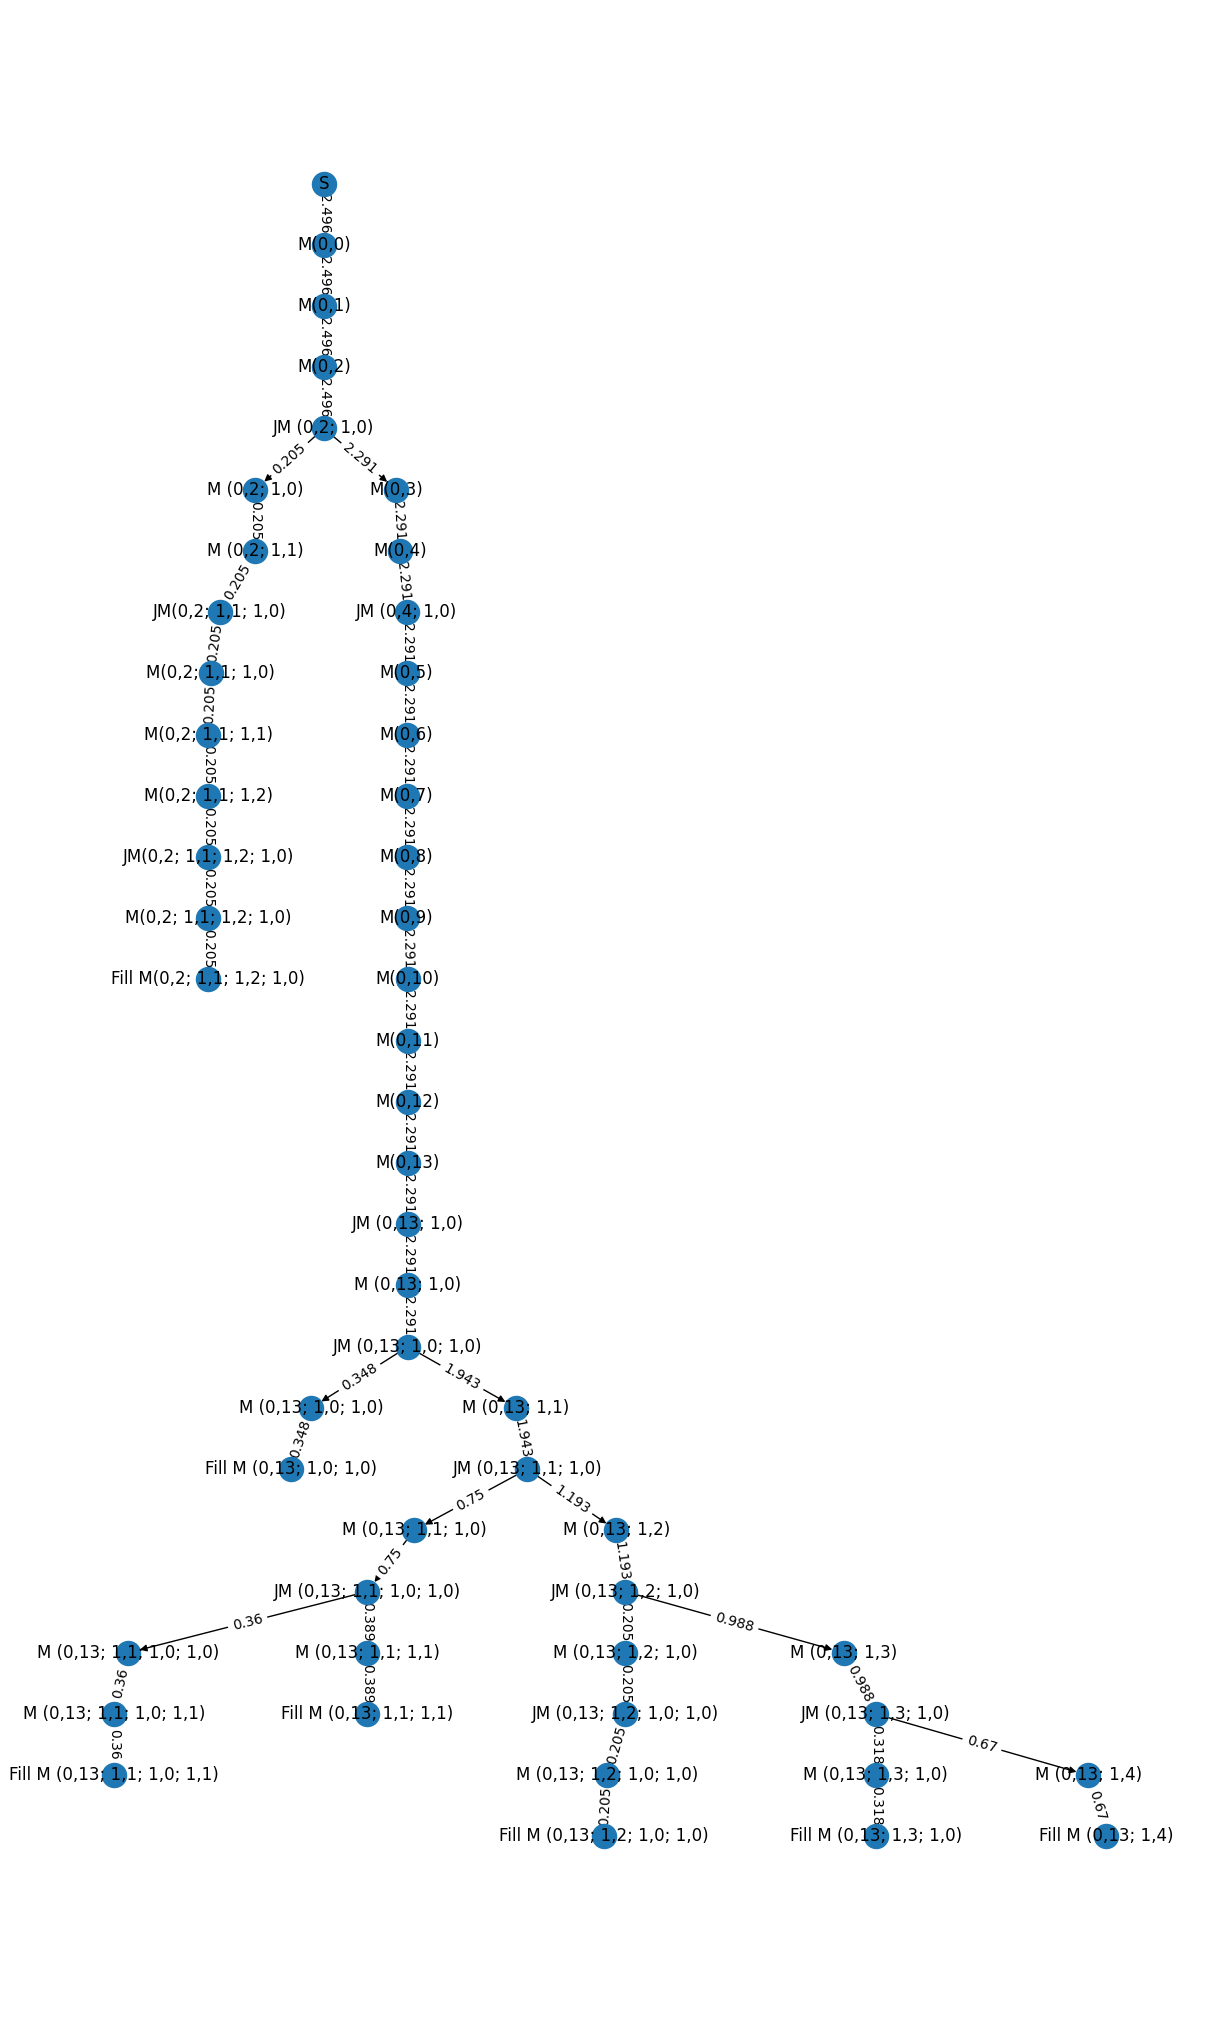


Step 31
244 mins
Fill Area:  M(0,2; 1,1; 1,2; 1,0) 3001.0
Fill Area:  M (0,13; 1,0; 1,0) 5095.0
Fill Area:  M (0,13; 1,3; 1,0) 4656.0
Fill Area:  M (0,13; 1,4; 1,0) 5600.0
Fill Area:  M (0,13; 1,1; 1,1) 5700.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 5275.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 3001.0


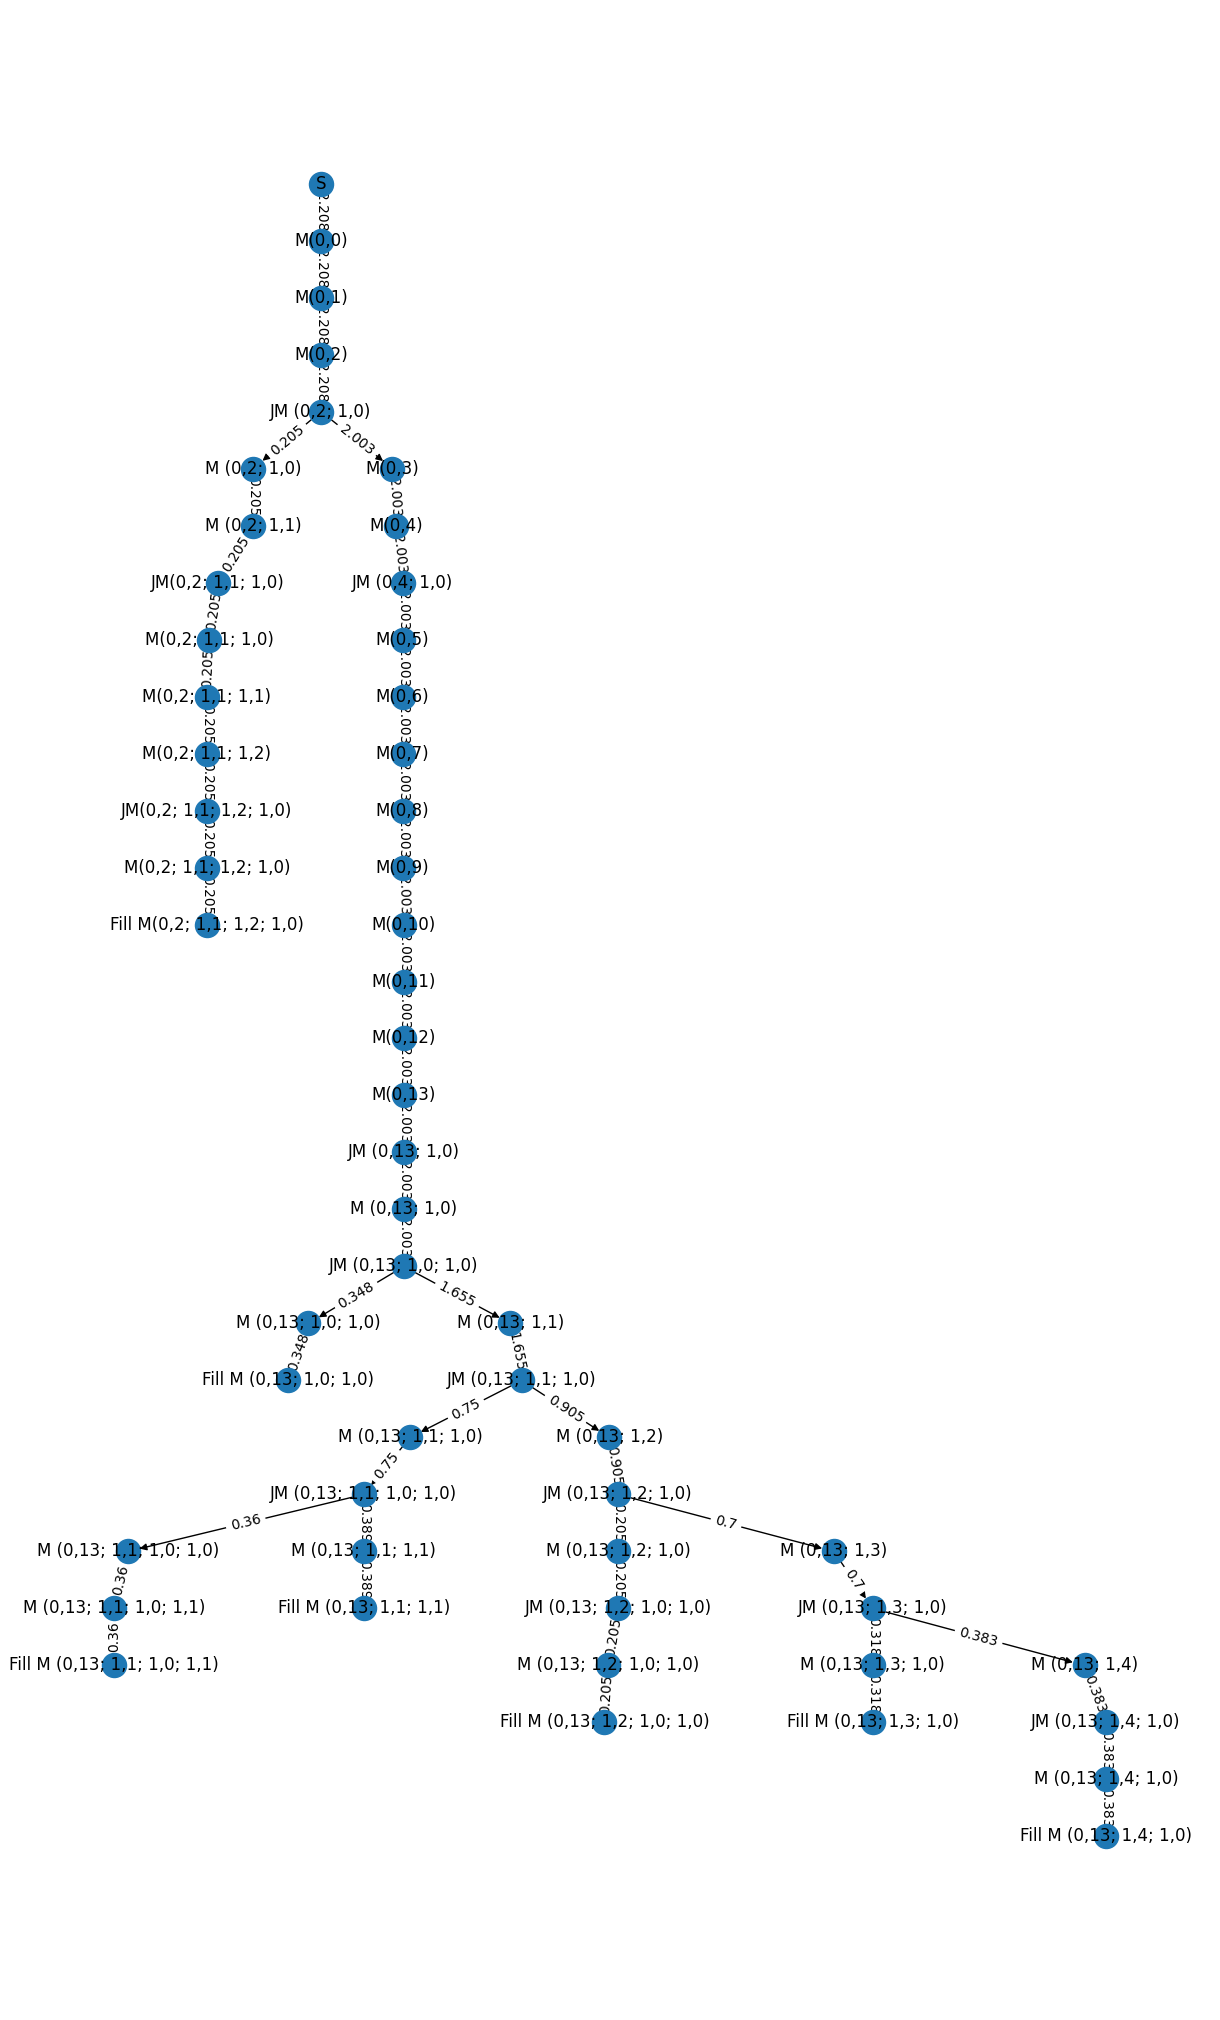


Step 32
590 mins
Fill Area:  M (0,13; 1,0; 1,0) 12319.0
Fill Area:  M (0,13; 1,3; 1,0) 11257.0
Fill Area:  M (0,13; 1,4; 1,0) 13540.0
Fill Area:  M (0,13; 1,1; 1,1) 13782.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 12756.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 7257.0


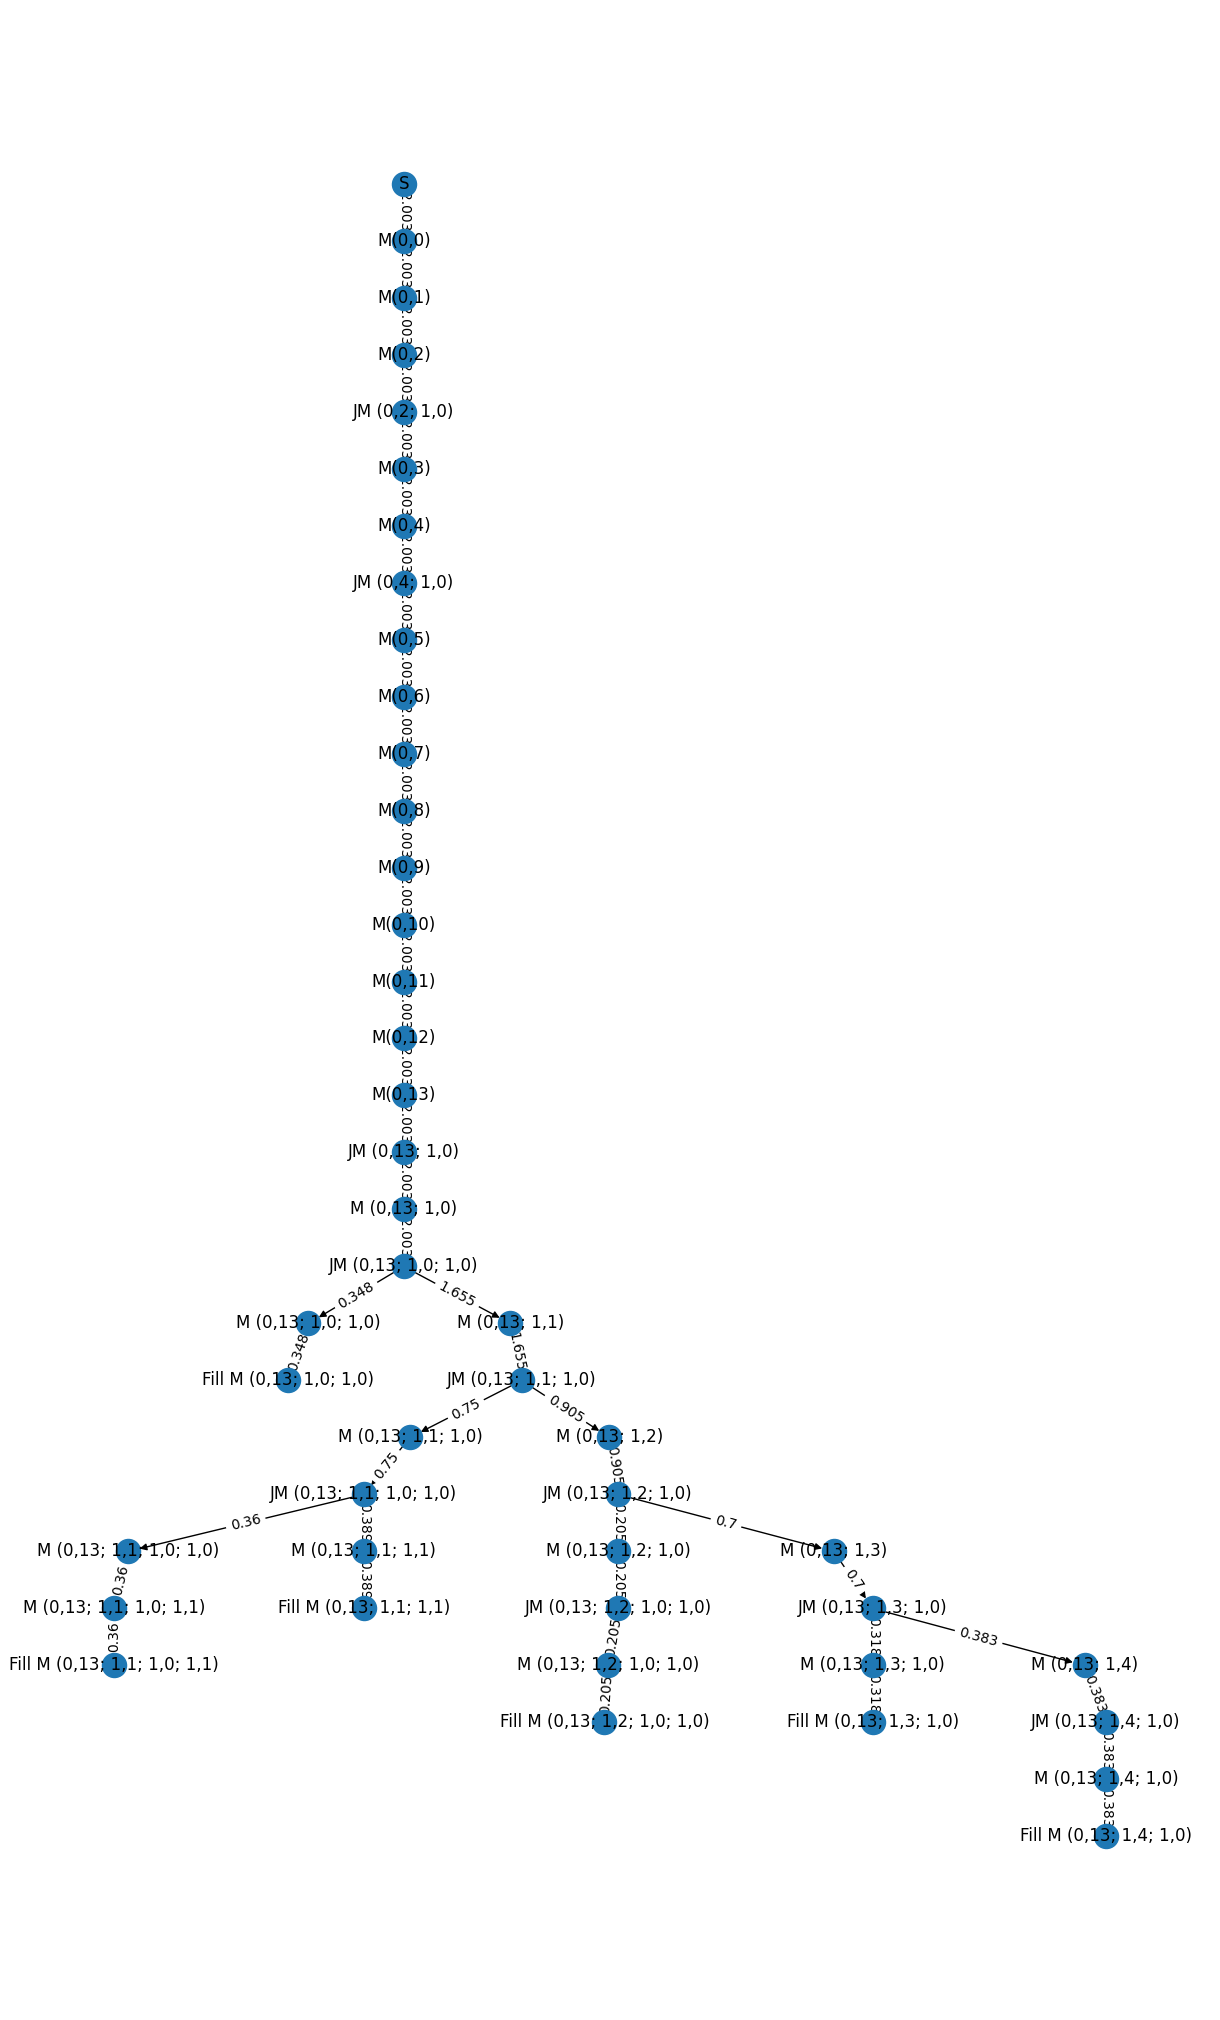


Step 33
1821 mins
Fill Area:  M (0,13; 1,0; 1,0) 38022.0
Fill Area:  M (0,13; 1,4; 1,0) 41792.0
Fill Area:  M (0,13; 1,1; 1,1) 42539.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 39370.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 22398.0


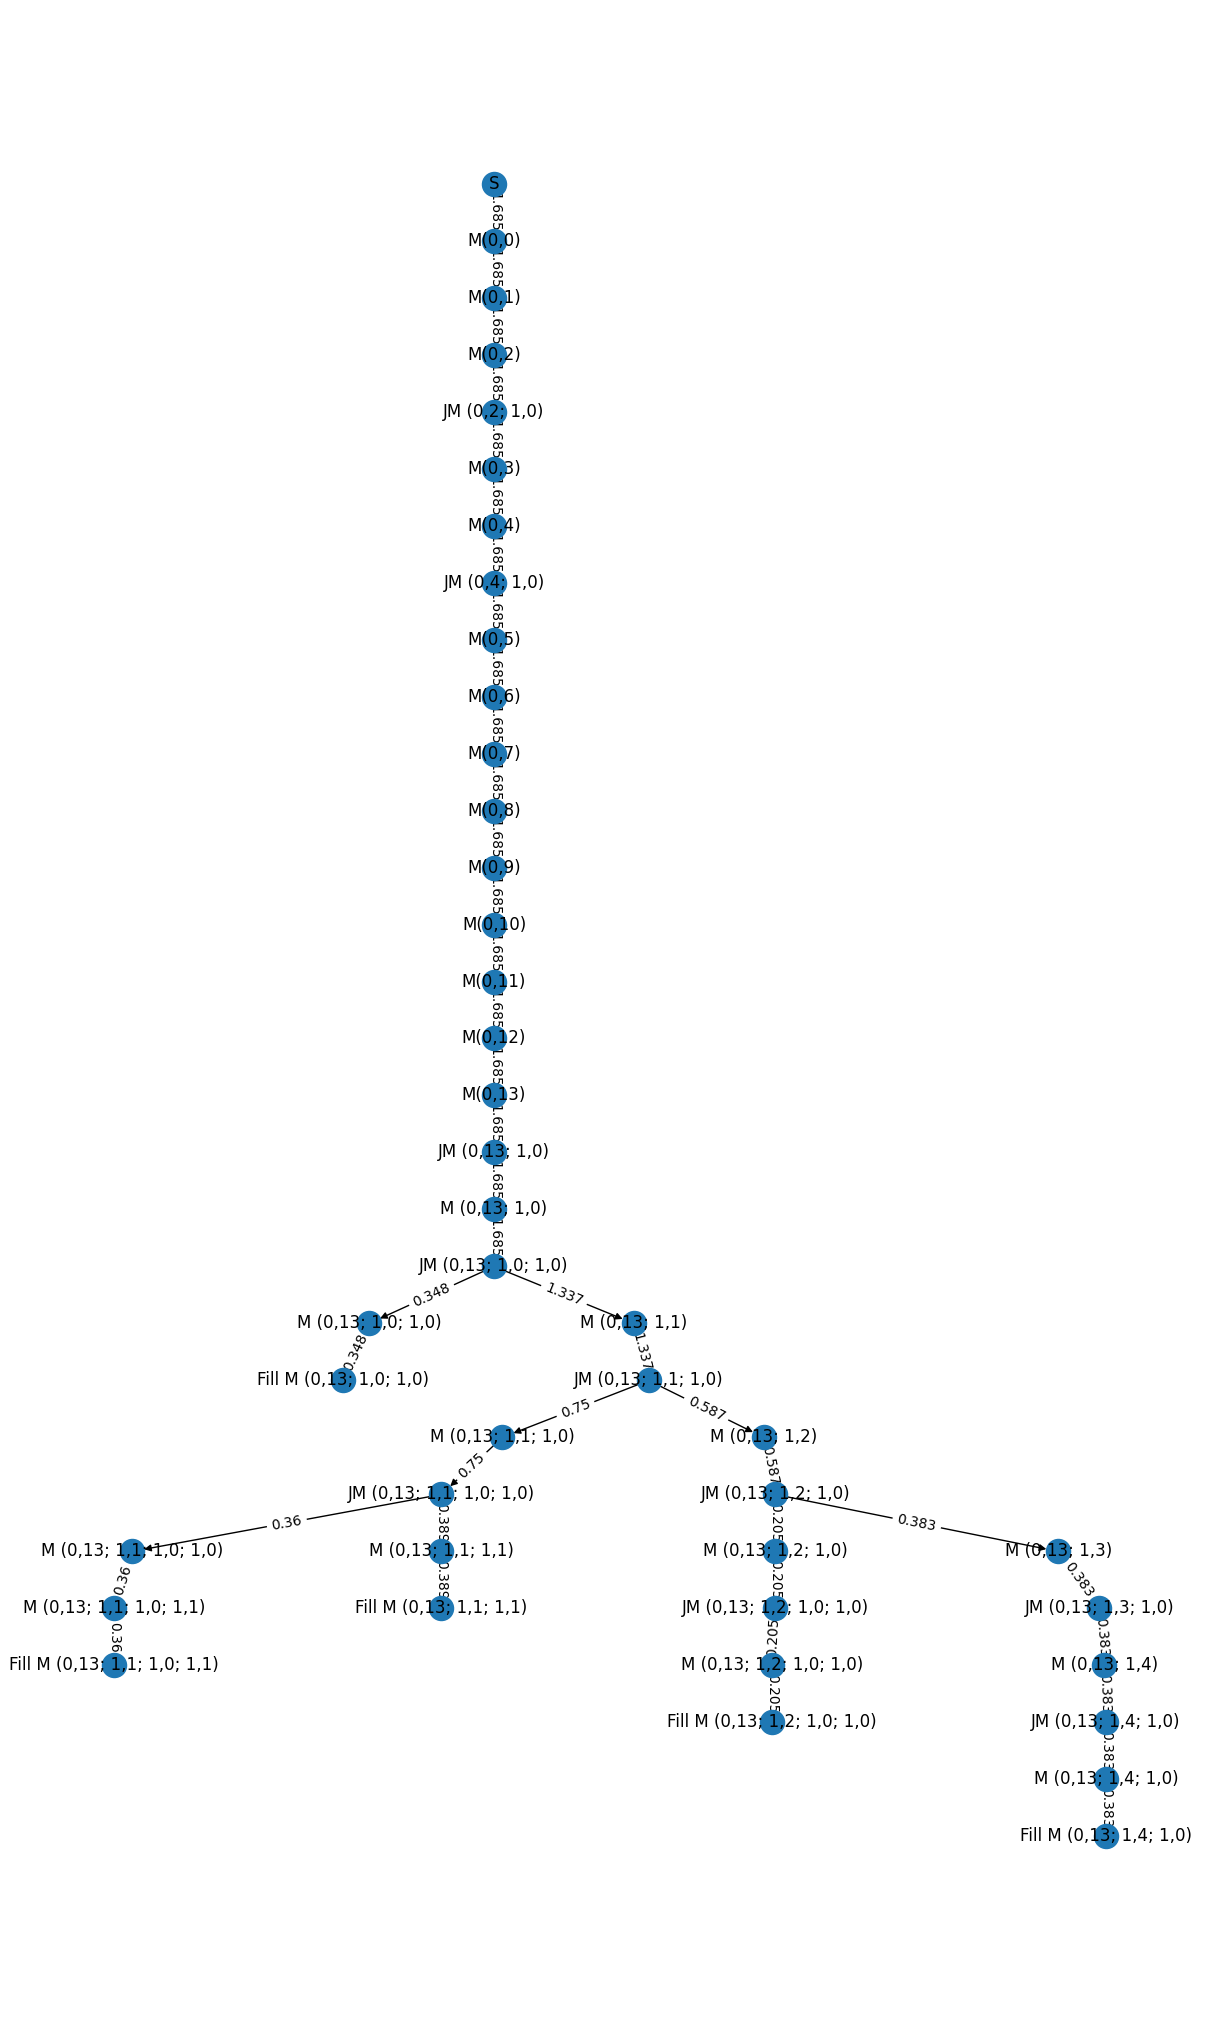


Step 34
365 mins
Fill Area:  M (0,13; 1,4; 1,0) 8377.0
Fill Area:  M (0,13; 1,1; 1,1) 8526.0
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 7891.0
Fill Area:  M (0,13; 1,2; 1,0; 1,0) 4490.0


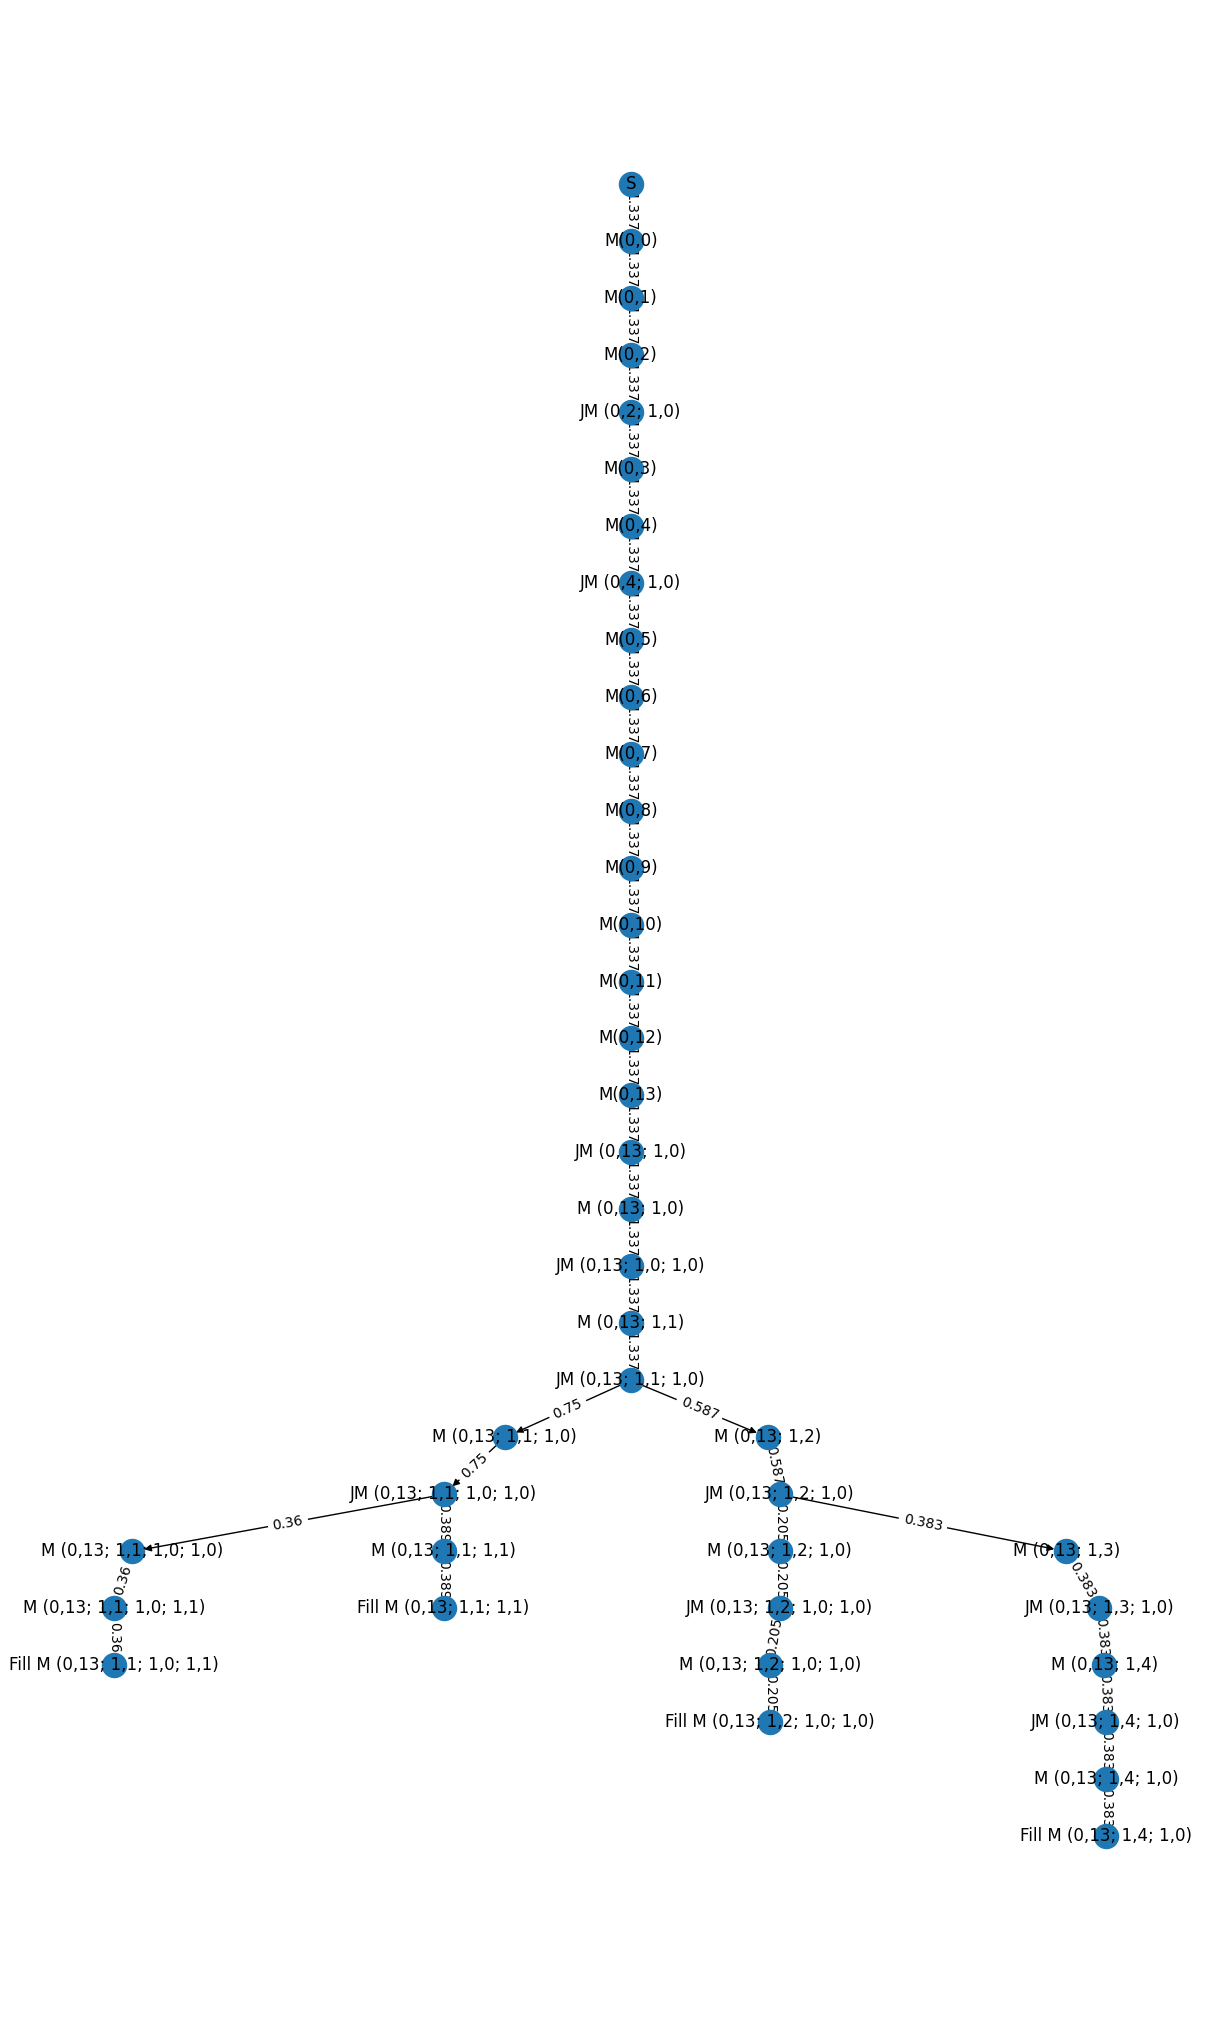


Step 35
1979 mins
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 42786.0
Fill Area:  M (0,13; 1,4; 1,0) 45418.0
Fill Area:  M (0,13; 1,1; 1,1) 46229.0


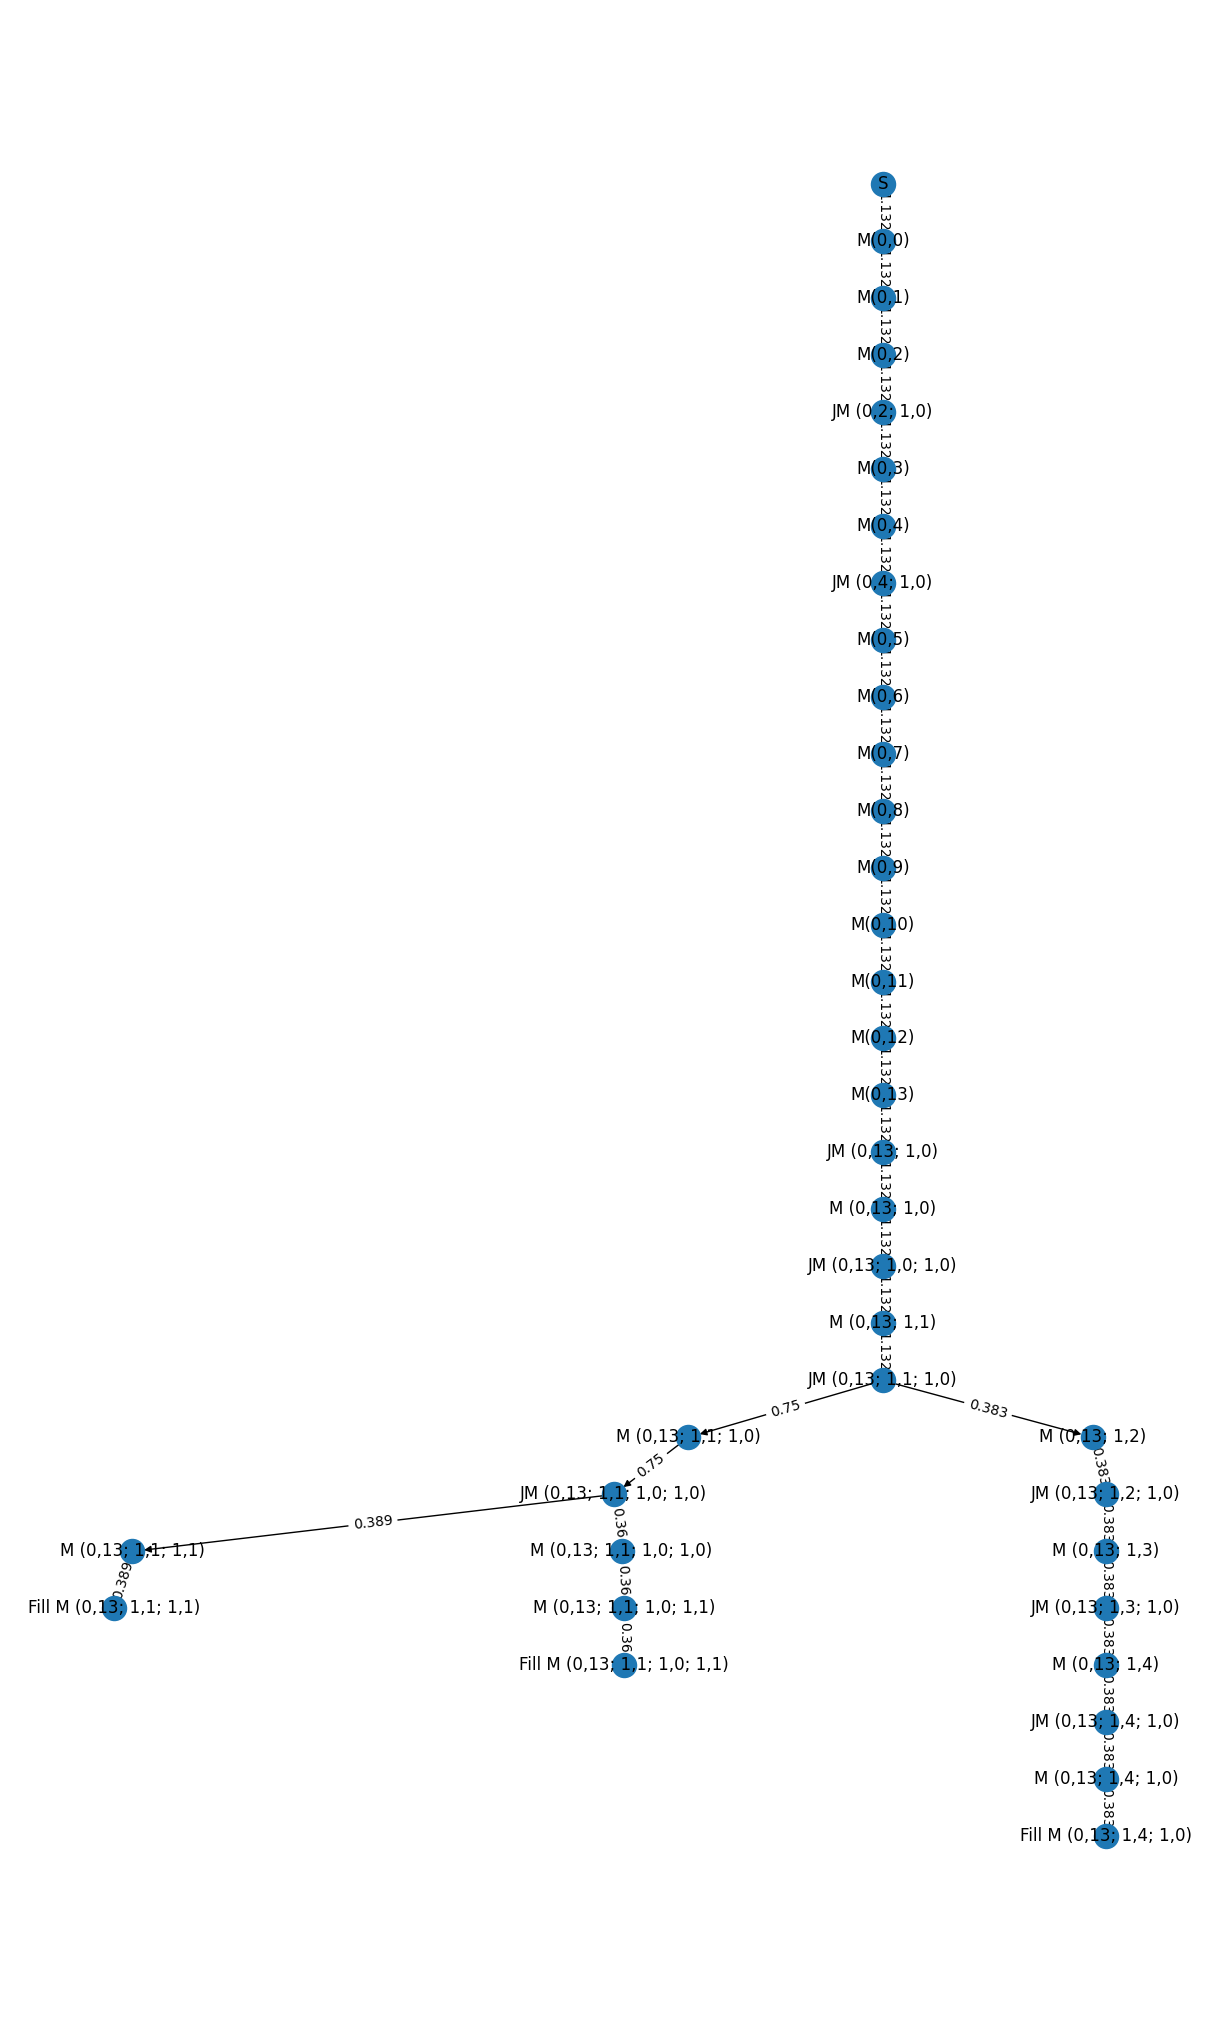


Step 36
2666 mins
Fill Area:  M (0,13; 1,1; 1,0; 1,1) 57639.0
Fill Area:  M (0,13; 1,1; 1,1) 62278.0


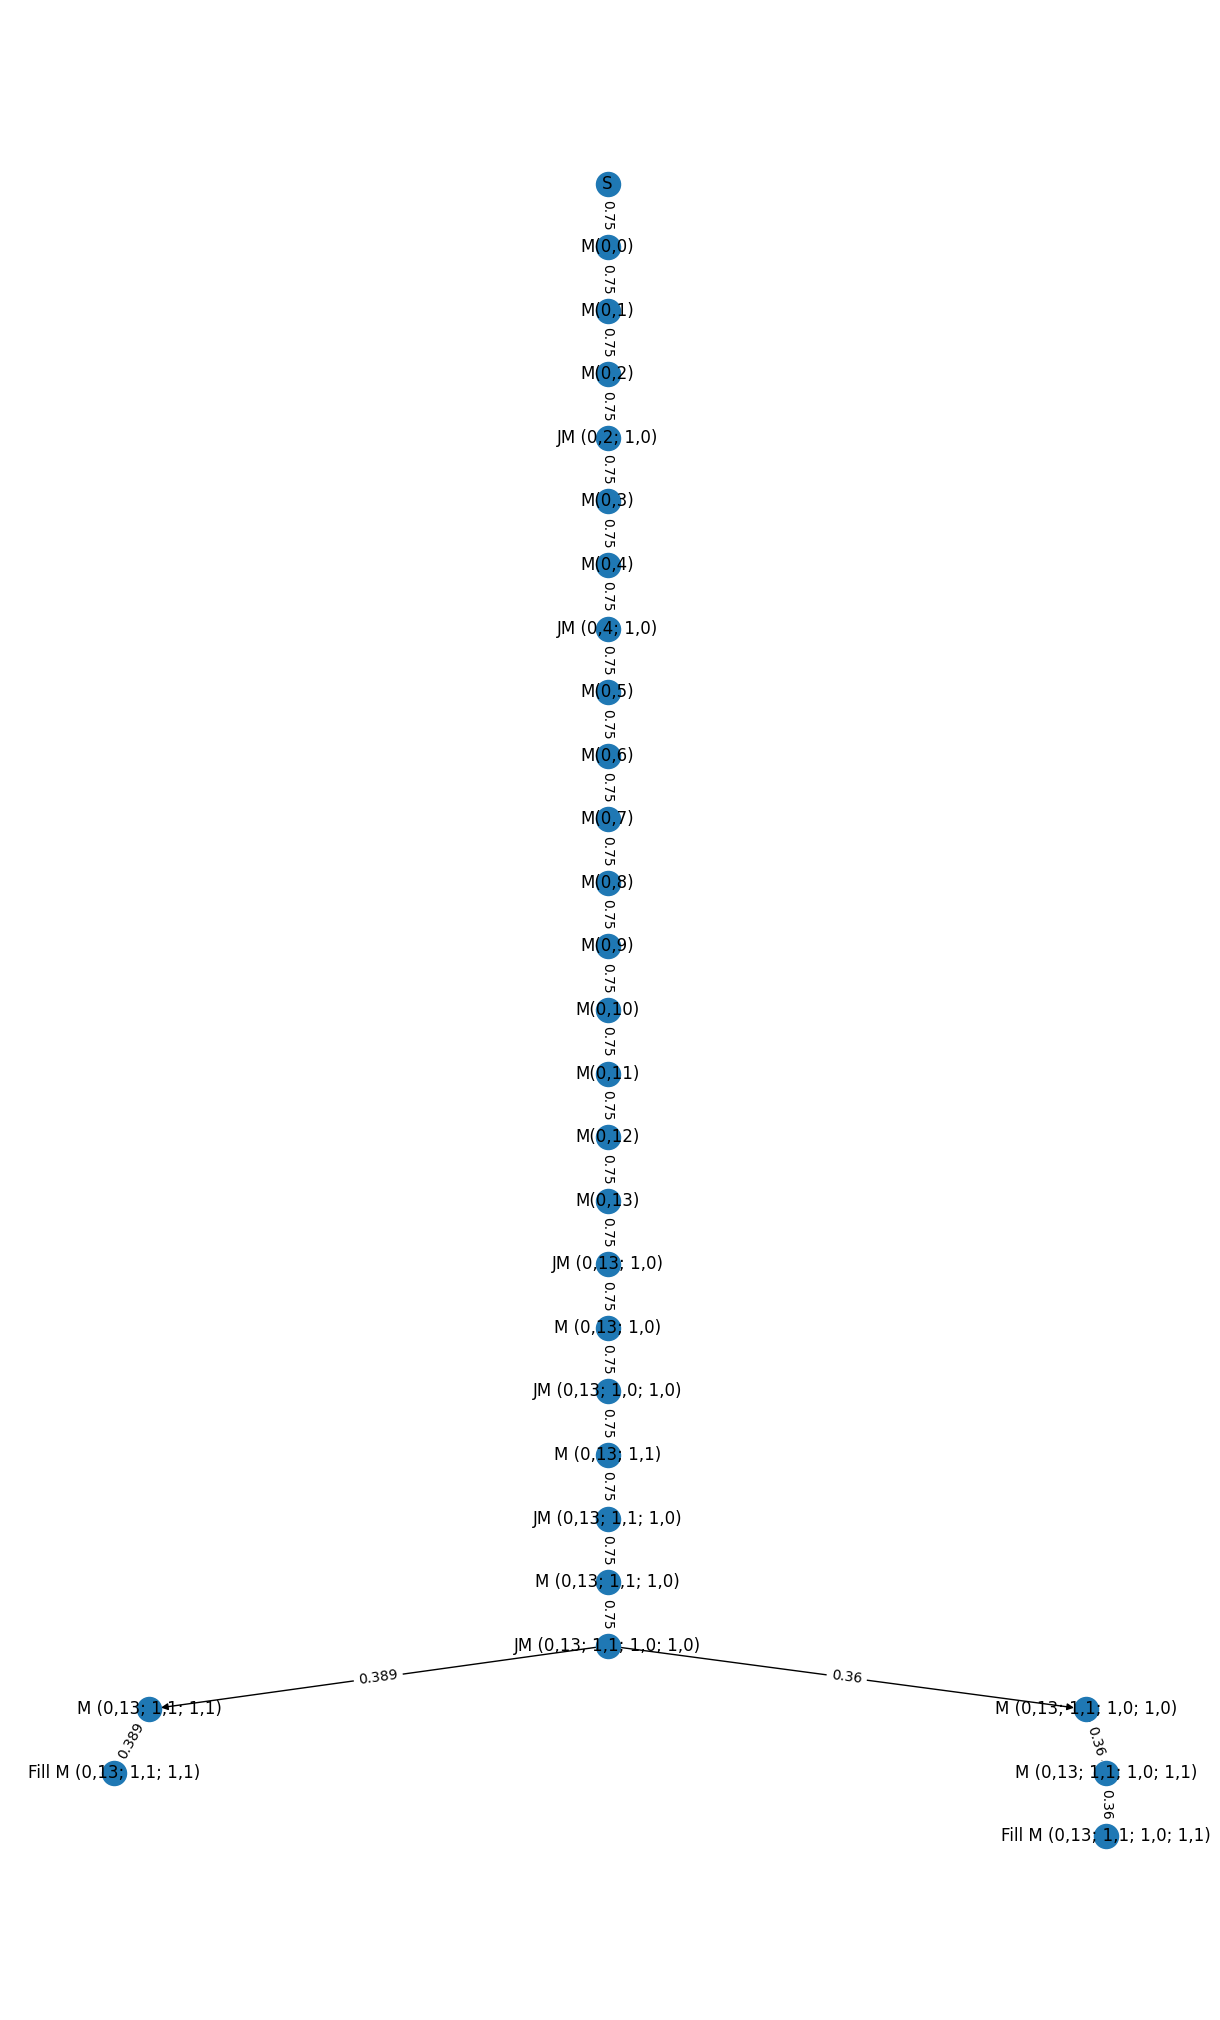


Step 37
1584 mins
Fill Area:  M (0,13; 1,1; 1,1) 37002.0


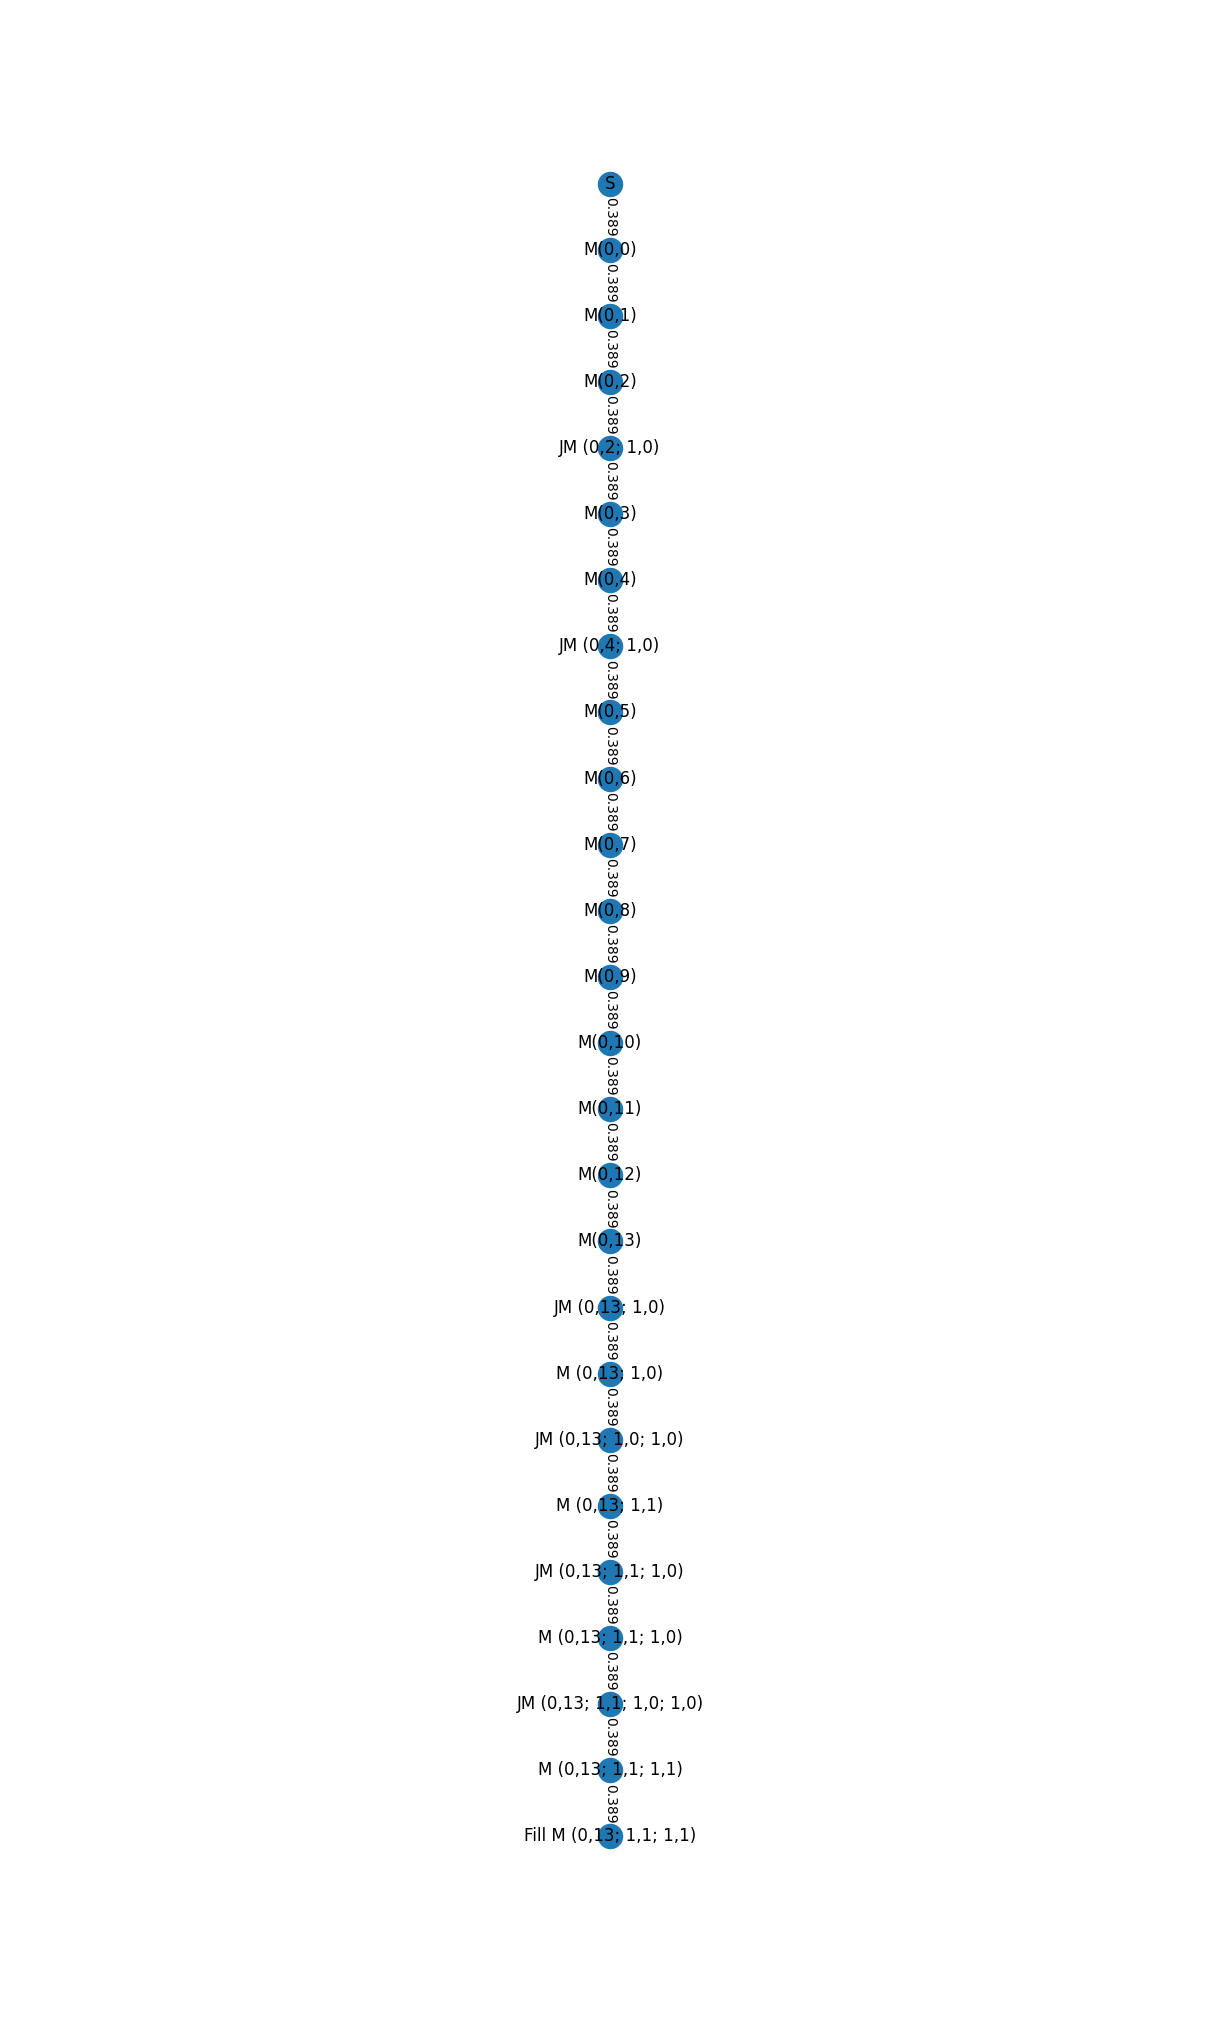

In [ ]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import warnings

def get_detail_operation(flow_dict,gate_info,minute_step):
  ret=[]
  for u in flow_dict:
    for v in flow_dict[u]:
      if flow_dict[u][v] > 0:
        if v in gate_info and 'q_max (m^3/s)' in gate_info[v]:
          if gate_info[v]['q_max (m^3/s)'] == 0:
            f_rate = flow_dict[u][v]
          else:
            f_rate = gate_info[v]['q_max (m^3/s)']
          if v == 'M(0,0)':
            ret.append({'Gate Valve':v,'Flow':flow_dict[u][v],'Time':minute_step,'Percent':round(100*flow_dict[u][v]/f_rate,2),'gate_level':-1})
          else:
            ret.append({'Gate Valve':v,'Flow':flow_dict[u][v],'Time':minute_step,'Percent':round(100*flow_dict[u][v]/f_rate,2),'gate_level':3})
  return ret

def update_gates(flow_dict,gate_info,minute_step,filled_area):
  for u in filled_area:
    gate_info[u]['Required Daily Volume (m3)'] = max(0,gate_info[u]['Required Daily Volume (m3)']-minute_step*60*filled_area[u]['q_max'])
    print('Fill Area: ',u,round(minute_step*60*filled_area[u]['q_max'],0))

def update_graph(gate_info,G):
  all_open_gates=set()
  for g in gate_info:
    if 'Required Daily Volume (m3)' in gate_info[g] and gate_info[g]['Required Daily Volume (m3)'] > 0:
      all_open_gates=all_open_gates.union(set(nx.shortest_path(G,'S',g)))
  adjustable_gates=[g for g in all_open_gates if g[0] != 'J']
  current_G=G.subgraph(all_open_gates)
  for n in adjustable_gates:
    if n in gate_info and gate_info[n]['q_max (m^3/s)'] > 0:
      current_G[gate_info[n]['parent']][n]['capacity'] = gate_info[n]['q_max (m^3/s)']
  working_G = nx.DiGraph()
  working_G.add_nodes_from(current_G.nodes(data=True))  # Include node attributes
  working_G.add_edges_from(current_G.edges(data=True))
  for g in gate_info:
    if 'Required Daily Volume (m3)' in gate_info[g]:
      if gate_info[g]['Required Daily Volume (m3)'] > 0:
        working_G.add_edge(g,'T')
  return working_G

def show_graph(flow_dict):
  show_G = nx.DiGraph()
  for u in flow_dict:
    for v in flow_dict[u]:
      if flow_dict[u][v] > 0:
        v_label = f'Fill {u}' if v == 'T' else v
        show_G.add_edge(u,v_label,label=str(round(flow_dict[u][v],3)))
  edge_labels = nx.get_edge_attributes(show_G, "label")
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(12, 20))
    pos = nx.nx_pydot.graphviz_layout(show_G, prog='dot')
    nx.draw(show_G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(show_G, pos, edge_labels=edge_labels)
    plt.show()

operations=[]
steps=1
while True:
  print('\nStep',steps)
  steps+=1
  flow_value, flow_dict = nx.algorithms.flow.maximum_flow(working_G, 'S', 'T')
  filled_area = dict()
  for u in flow_dict:
    for v in flow_dict[u]:
      if v == 'T' and flow_dict[u][v] > 0:
        filled_area[u] = {'q_max':flow_dict[u][v],'fill_time':math.ceil(gate_info[u]['Required Daily Volume (m3)']/flow_dict[u][v])}
  if len([filled_area[u]['fill_time'] for u in filled_area]) == 0:
    break
  time_step=min([filled_area[u]['fill_time'] for u in filled_area])
  minute_step=math.ceil(time_step/60)
  print(minute_step,'mins')
  operations.append(get_detail_operation(flow_dict,gate_info,minute_step))
  update_gates(flow_dict,gate_info,minute_step,filled_area)
  show_graph(flow_dict)
  working_G = update_graph(gate_info,G)
  if len(working_G.nodes) == 0:
    break

## Export output to jobs.xlsx file

In [ ]:
from datetime import datetime, timedelta
import os

def get_gate_name(gv):
  gate_name_info={'M(0,3)':{'gate_name':'gate7'},
                  'M (0,2: 1,0)':{'gate_name':'gate6'},
                  'M (0,2: 1,2)':{'gate_name':'gate4'},
                  'M(0,2; 1,1; 1,0)':{'gate_name':'gate5'},
                  'M(0,2; 1,1; 1,1)':{'gate_name':'gate3'},
                  'M(0,2; 1,1; 1,2)':{'gate_name':'gate1'},
                  'M(0,2; 1,1; 1,2; 1,0)':{'gate_name':'gate2'}}
  if gv not in gate_name_info:
    return gv
  return gate_name_info[gv]['gate_name']

def is_exist(f):
  return os.path.exists(f)

def export_excel(operations,start_time,filename,status_filename):
  if not os.path.exists(status_filename):
    current_open = set()
  else:
    current_open = set(pd.read_excel(status_filename)['Gate Valve'].unique())
  jobs=[]
  start_time = datetime.strptime(start_time, "%I:%M %p %d %b %y")
  for op in operations:
    time_step = op[0]['Time']
    newly_open = set()
    for task in op:
      task['Time'] = datetime.strftime(start_time, "%I:%M %p %d %b %y")
      task['gate_level'] = task['gate_level']
      task['gate_name'] = get_gate_name(task['Gate Valve'])
      task['completestatus'] = 1
      task['startdatetime'] = start_time
      jobs.append(task)
      newly_open.add(task['Gate Valve'])
    for g in current_open-newly_open:
      close_task = dict()
      close_task['Gate Valve'] = g
      close_task['Time'] = datetime.strftime(start_time, "%I:%M %p %d %b %y")
      close_task['Flow'] = 0
      close_task['Percent'] = 0
      close_task['gate_level'] = 0
      close_task['gate_name'] = get_gate_name(g)
      close_task['completestatus'] = 1
      close_task['startdatetime'] = start_time
      jobs.append(close_task)
    current_open = newly_open
    start_time = start_time + timedelta(minutes=time_step)
  for g in current_open:
    close_task = dict()
    close_task['Gate Valve'] = g
    close_task['Time'] = datetime.strftime(start_time, "%I:%M %p %d %b %y")
    close_task['Flow'] = 0
    close_task['Percent'] = 0
    close_task['gate_level'] = 0
    close_task['gate_name'] = get_gate_name(g)
    close_task['completestatus'] = 1
    close_task['startdatetime'] = start_time
    jobs.append(close_task)
  df=pd.DataFrame(jobs)
  df.to_excel(filename,index=None)
export_excel(operations,'8:00 am 12 Dec 23','jobs.xlsx','current_open.xlsx')

## Export to SQL Server

In [ ]:
# @title Installation
server_ip = "182.53.226.237" # @param {type:"string"}
username = "sa" # @param {type:"string"}
password = "bangkok1234" # @param {type:"string"}
database_name = "db_scada" # @param {type:"string"}

In [ ]:
%%sh
apt-get install -y unixodbc-dev
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

Reading package lists...
Building dependency tree...
Reading state information...
unixodbc-dev is already the newest version (2.3.9-5).
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.
OK
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://packages.microsoft.com/ubuntu/22.04/prod jammy InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100   983  100   983    0     0   3682      0 --:--:-- --:--:-- --:--:--  3695
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    88  100    88    0     0    512      0 --:--:-- --:--:-- --:--:--   514
W: https://packages.microsoft.com/ubuntu/22.04/prod/dists/jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.


In [ ]:
! pip install pyodbc

In [ ]:
import pyodbc

def clear_table(conn_str,table_name):
  connection = pyodbc.connect(conn_str)
  cursor = connection.cursor()
  table_query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"
  cursor.execute(table_query)
  tables = cursor.fetchall()
  if table_name.split('.')[-1] in [table.TABLE_NAME for table in tables]:
      cursor.execute(f'DROP TABLE {table_name}')
      connection.commit()
  cursor.close()
  connection.close()

conn_str = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={server_ip};DATABASE={database_name};UID={username};PWD={password}'
clear_table(conn_str,'dbo.tb_tasks')
clear_table(conn_str,'dbo.tb_gatelevel_command')
connection = pyodbc.connect(conn_str)
cursor = connection.cursor()
df = pd.read_excel('jobs.xlsx')
table_name = 'dbo.tb_tasks'
create_table_query = f"CREATE TABLE {table_name} (gate_name VARCHAR(255), gate_level INT, startdatetime DATETIME, completestatus INT)"
cursor.execute(create_table_query)
connection.commit()
insert_query = f"INSERT INTO {table_name} ({', '.join(['gate_name','gate_level','startdatetime','completestatus'])}) VALUES (?, ?, ?, ?)"
cursor.executemany(insert_query, df[['gate_name','gate_level','startdatetime','completestatus']].values.tolist())
connection.commit()
table_name = 'dbo.tb_gatelevel_command'
create_table_query = f"CREATE TABLE {table_name} (gate_name VARCHAR(255), gate_level INT, startdatetime DATETIME, completestatus INT)"
cursor.execute(create_table_query)
connection.commit()
insert_query = f"INSERT INTO {table_name} ({', '.join(['gate_name','gate_level','startdatetime','completestatus'])}) VALUES (?, ?, ?, ?)"
cursor.executemany(insert_query, df[df['gate_name'].str.contains('gate')][['gate_name','gate_level','startdatetime','completestatus']].values.tolist())
connection.commit()
cursor.close()
connection.close()